# Cross-competition for epitope binning

Here, we analyze cross-competition experiments for epitope binning. Experiments were performed using biolayer interferometry on the ForteBio Octet instrument.

In [3]:
import sys
import os
import time
import random
import copy
import math

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 500
   }
mpl.rcParams.update(params)

sns.set_style("ticks")

savefig_args = {"dpi": 500, "bbox_inches": "tight", "pad_inches": 0.05}
mpl.rc('savefig', dpi=500)
output_dir = "outs"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data_dir = "../data/"

# Load data

In [4]:
infile = data_dir + "L3_competition_kinetics.csv"

Exp_All_Raw = pd.read_csv(infile, header=0, usecols=[0, 1, 3, 5, 7, 9, 11, 13, 15])
columns = ["time"] + ["A11", "B11", "C11", "D11", "E11", "F11", "G11", "H11"]
Exp_All_Raw.columns = columns
print Exp_All_Raw.shape
Exp_All_Raw.head()

(52500, 9)


time       A11       B11       C11       D11       E11       F11       G11       H11
0  0.00  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1  0.19 -0.054325 -0.049846 -0.053126 -0.059402 -0.046677 -0.061166 -0.046518 -0.052793
2  0.41 -0.102038 -0.098520 -0.097895 -0.099500 -0.094784 -0.102064 -0.084052 -0.097086
3  0.61 -0.138723 -0.130128 -0.134780 -0.134097 -0.122713 -0.138387 -0.125160 -0.130455
4  0.80 -0.176246 -0.163821 -0.172025 -0.165530 -0.152683 -0.167334 -0.146034 -0.158778

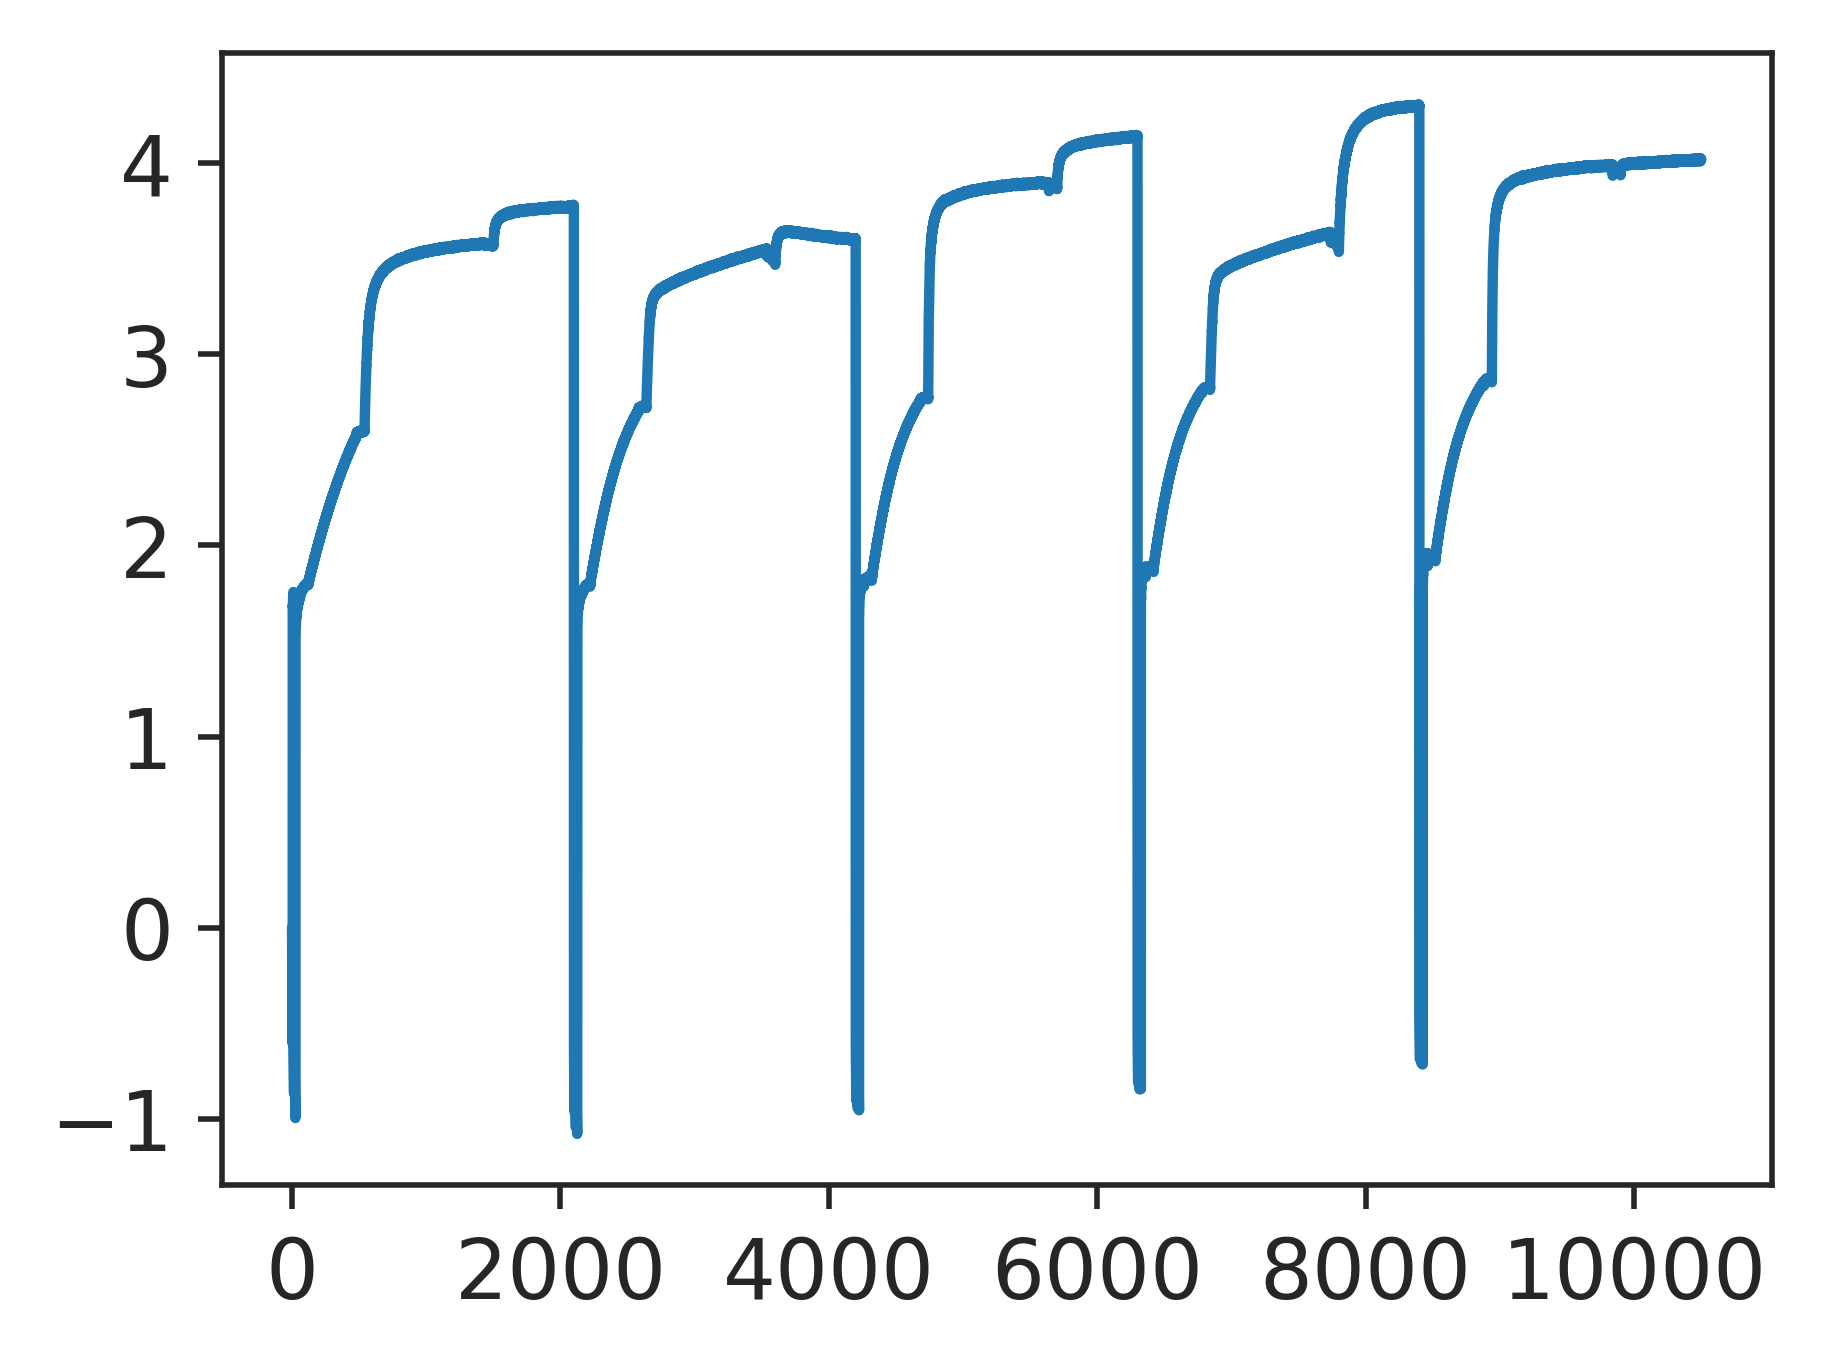

In [5]:
# Visualize data

x = Exp_All_Raw["time"]
y = Exp_All_Raw["A11"]

fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.plot(x, y)

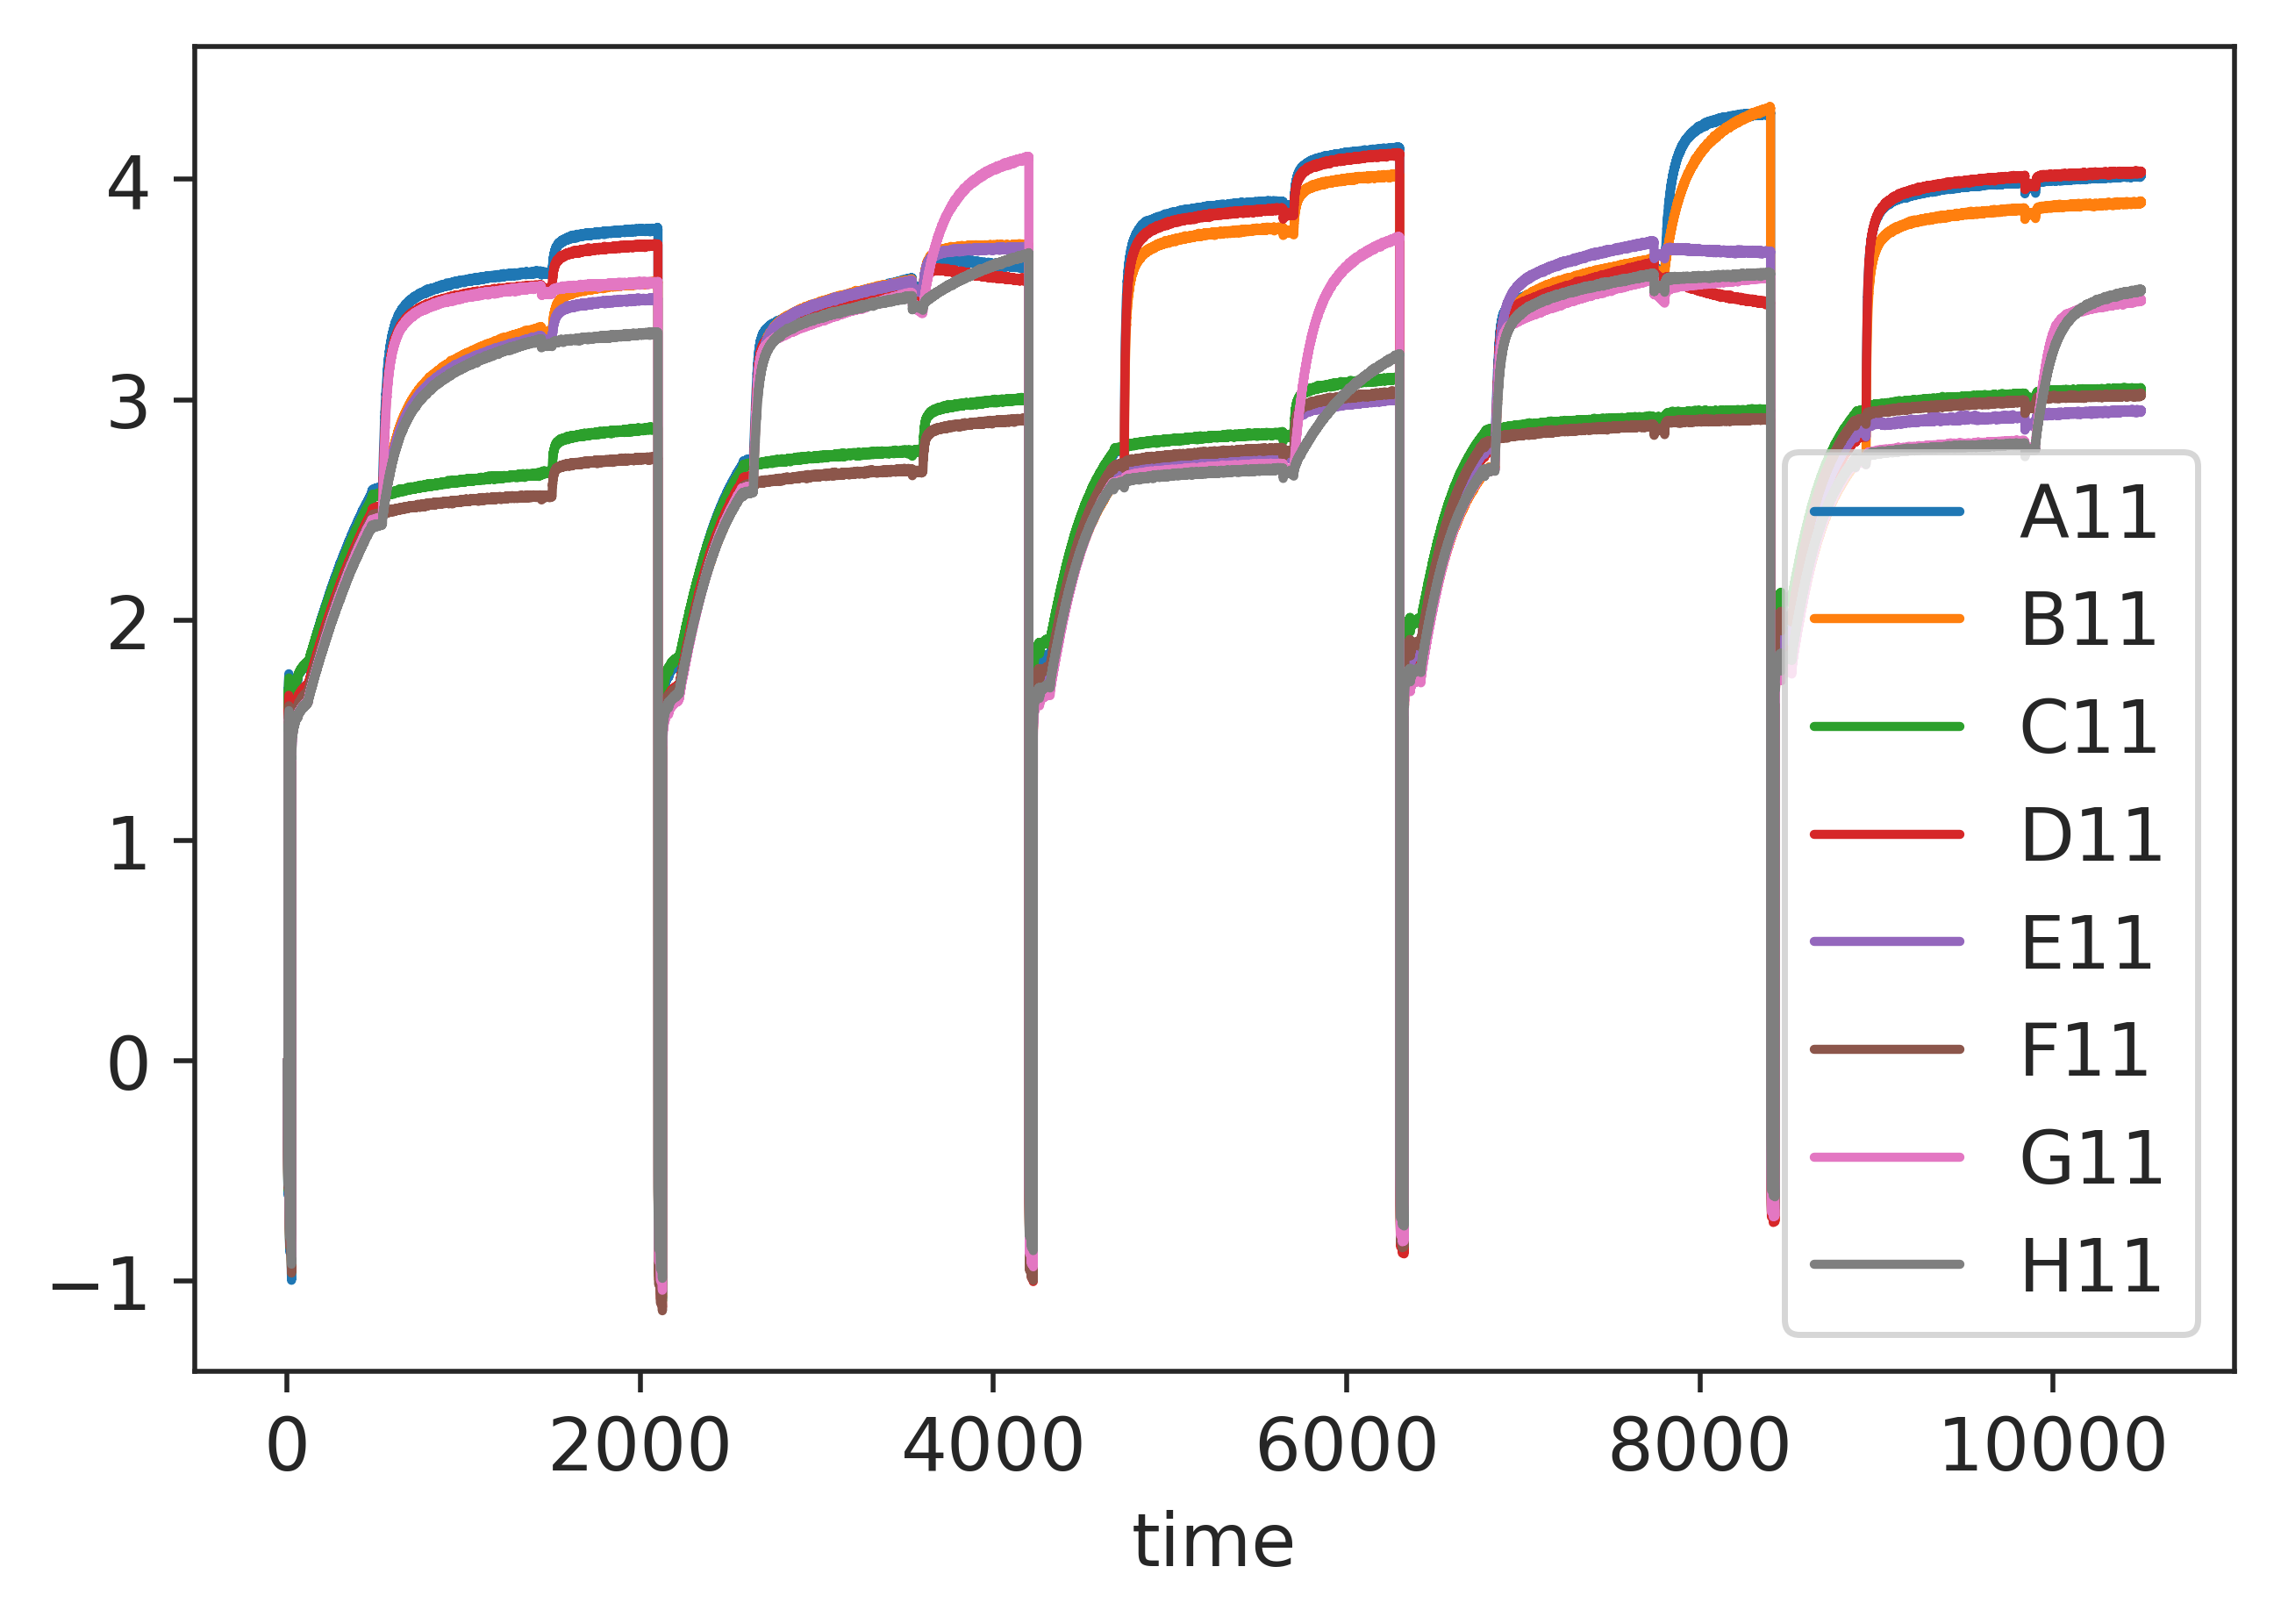

In [6]:
Exp_All_Raw.plot(x="time")

# Develop way to select a single assay and perform baseline subtraction

In [7]:
def idx_start_end(idx_assay):
    
    T_assay_total = 25 * 6 + 150 + 300 + 1800 + 300 + 4500 + 300 + 3000
    T_assay_to_Assoc2 = 25 * 6 + 150 + 300 + 1800 + 300 + 4500 + 300
    
    T_start = T_assay_total * (idx_assay - 1) + T_assay_to_Assoc2 - 1
    T_end = T_start + 3000
    
    return T_start, T_end

def assay_select_baseline(Exp_All_Raw, idx_assay, sensors):
    idx_start, idx_end = idx_start_end(idx_assay) # get start and end points of assay
    columns = ["time"] + sensors
    Exp_Raw = Exp_All_Raw.loc[idx_start:idx_end][columns] # select timepoints and sensors
    Exp = Exp_Raw - Exp_Raw.iloc[0] # subtract initial value
    return Exp

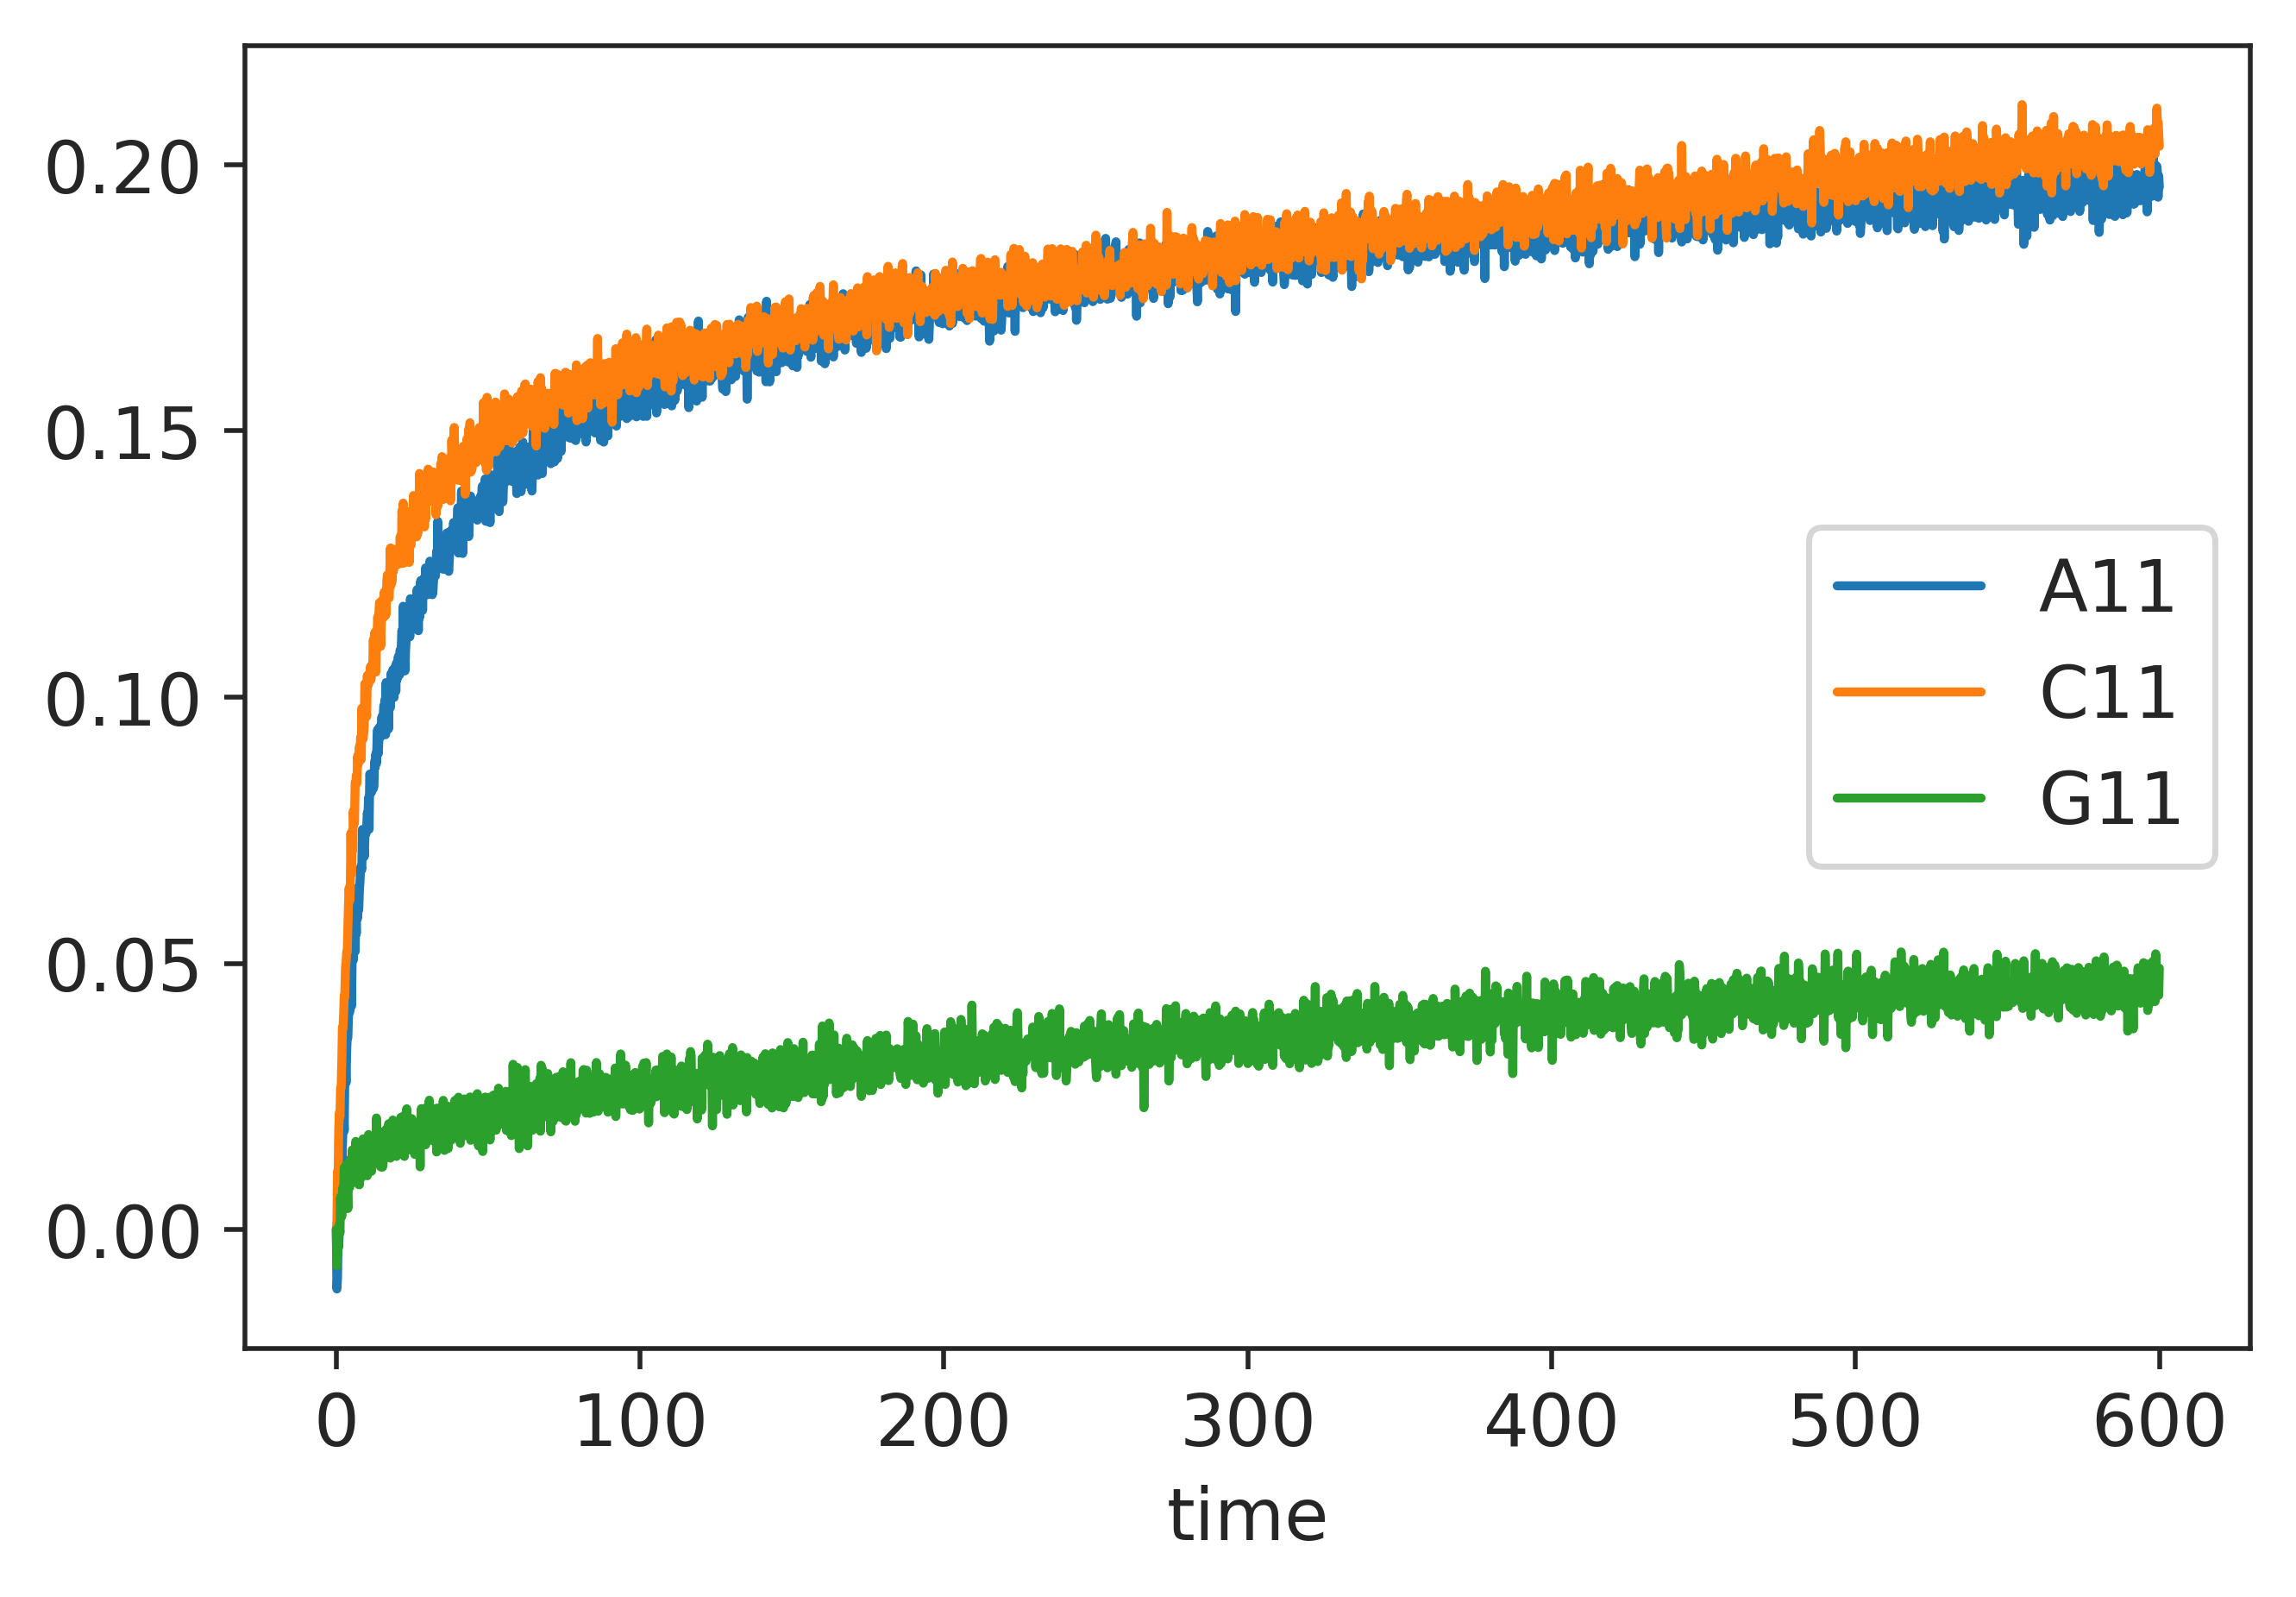

In [8]:
idx_assay = 1
sensors = ['A11', 'C11', 'G11']

Exp = assay_select_baseline(Exp_All_Raw, idx_assay, sensors)

Exp.plot(x="time")

# Plot data for all assays

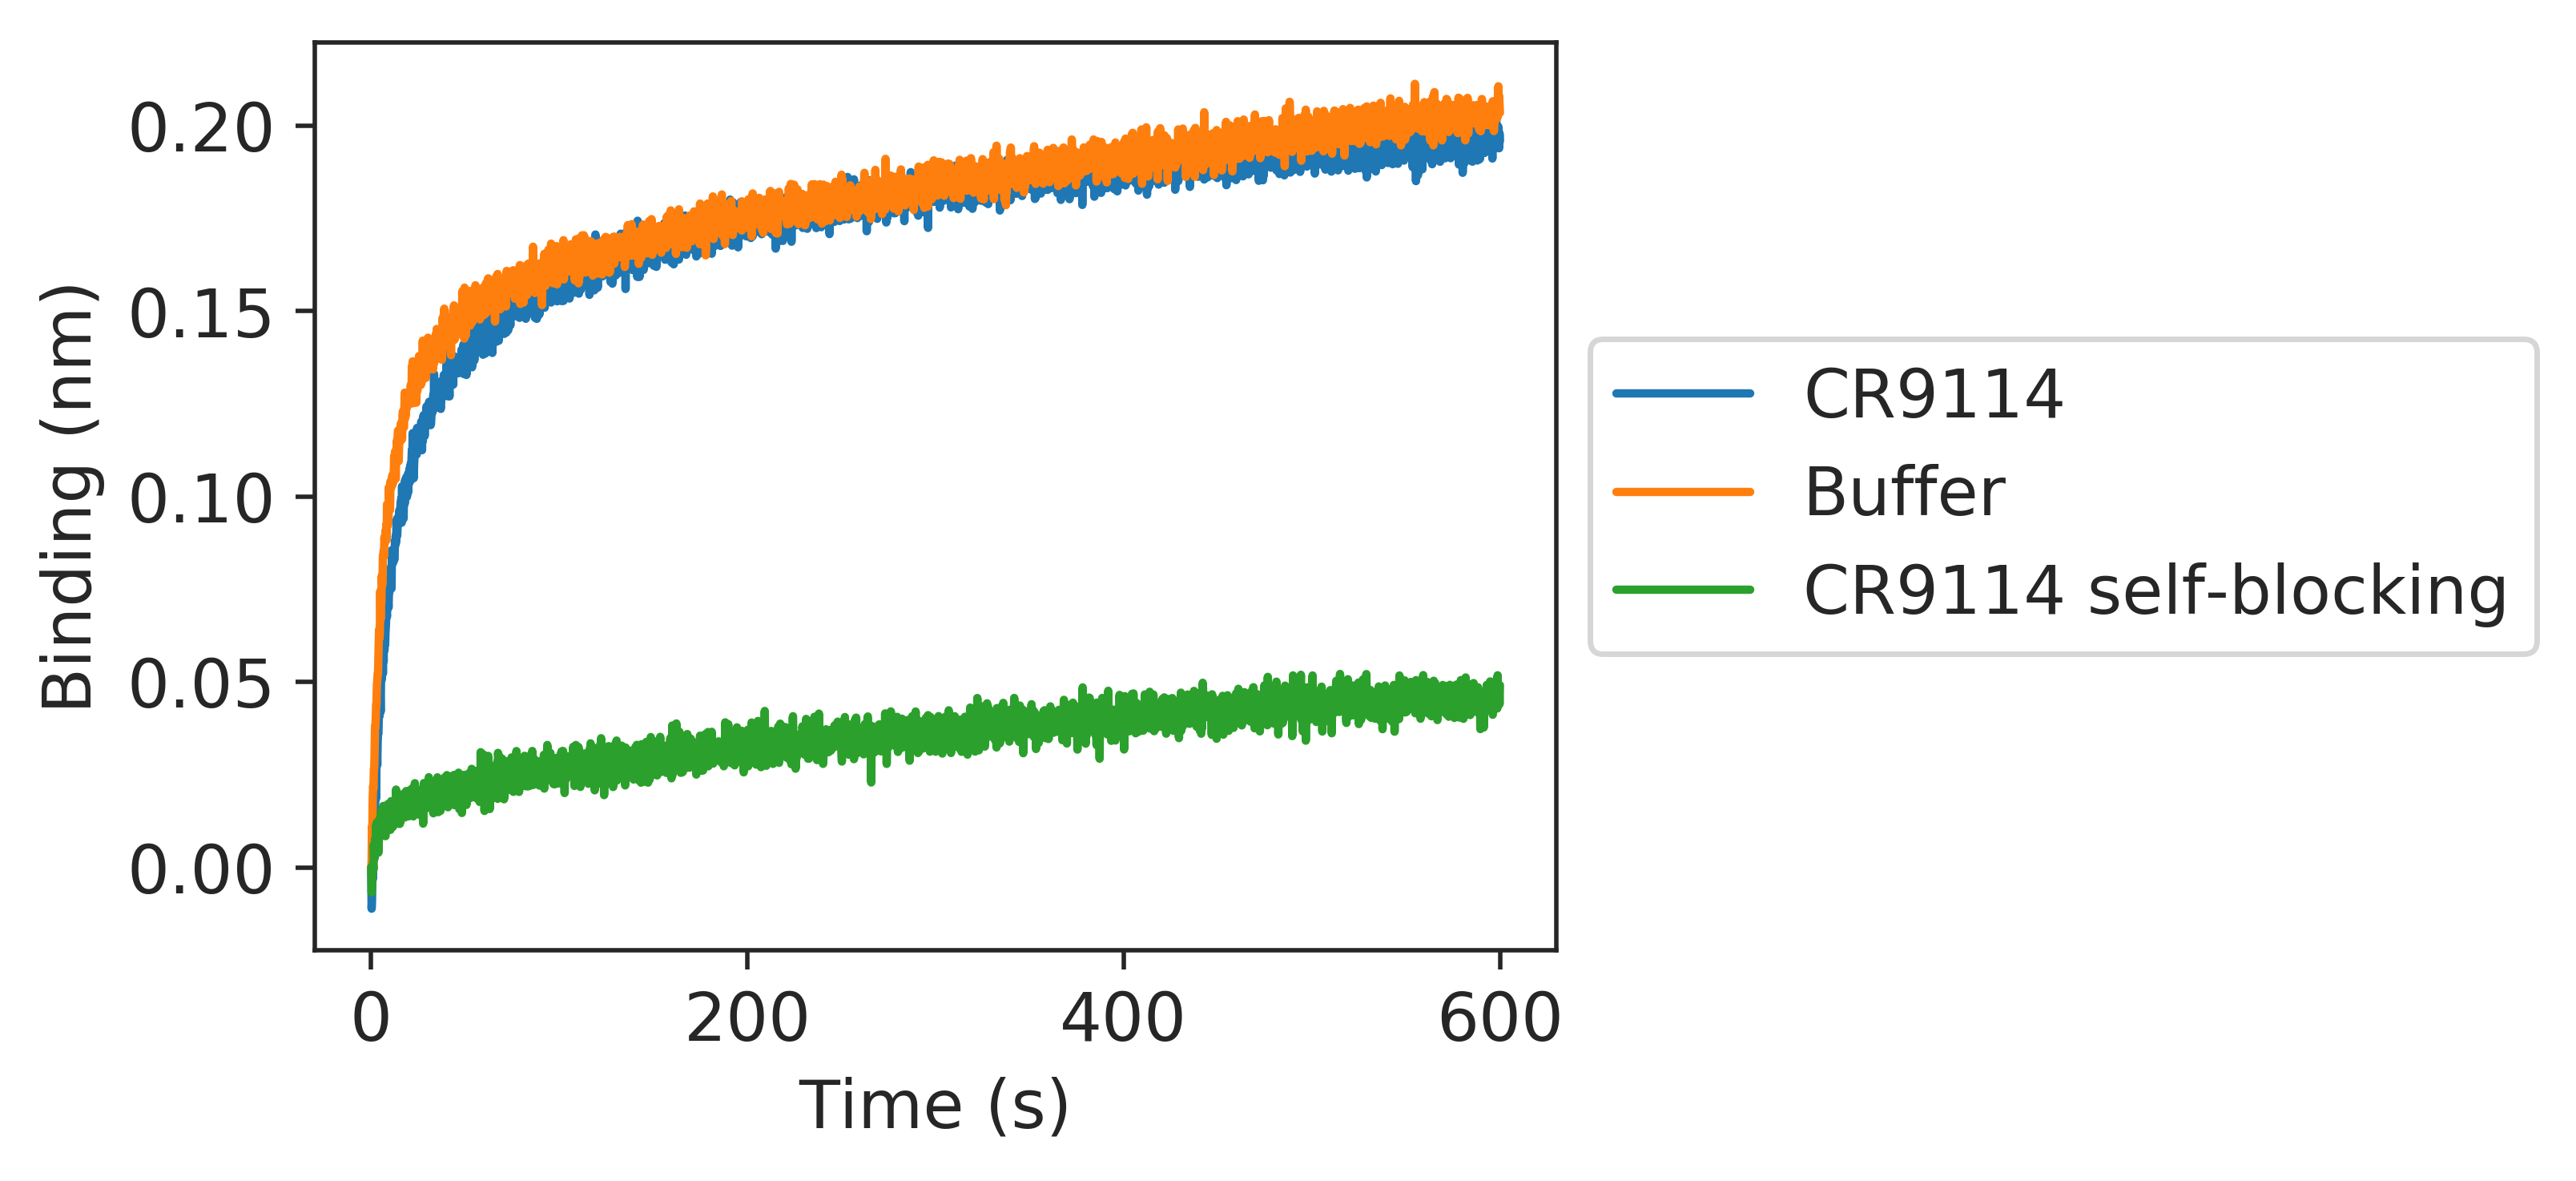

In [9]:
# Plot one assay

idx_assay = 1
sensors = ['A11', 'C11', 'G11']

labels = ["CR9114", "Buffer", "CR9114 self-blocking"]

Exp = assay_select_baseline(Exp_All_Raw, idx_assay, sensors)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
Exp.plot(ax=ax, x="time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Binding (nm)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=labels)

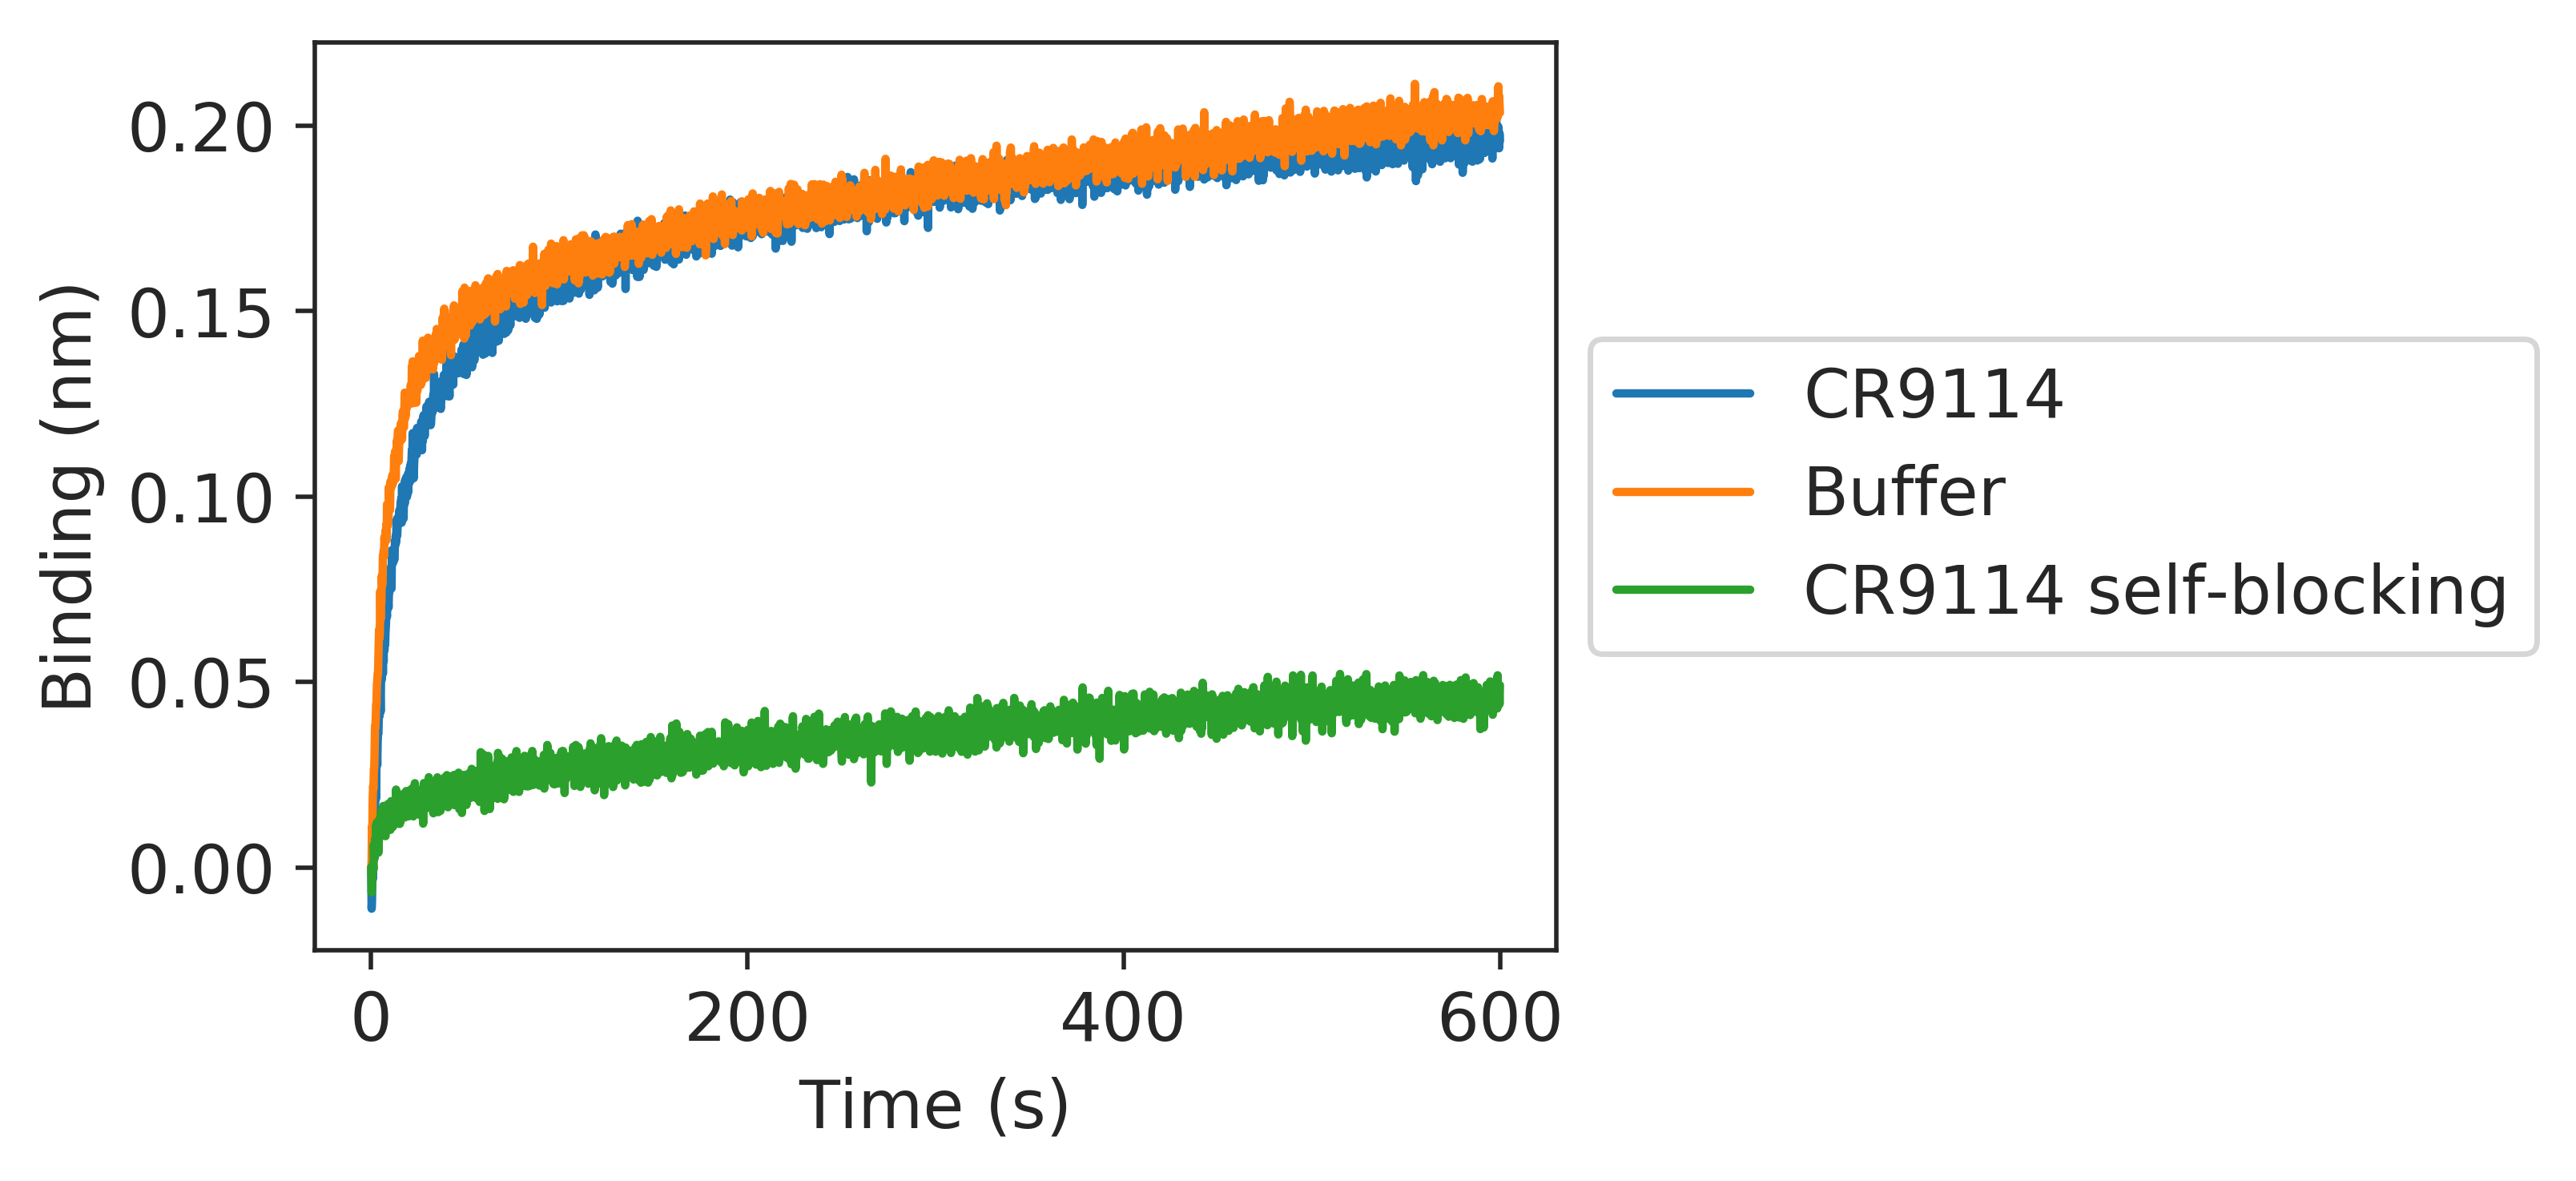

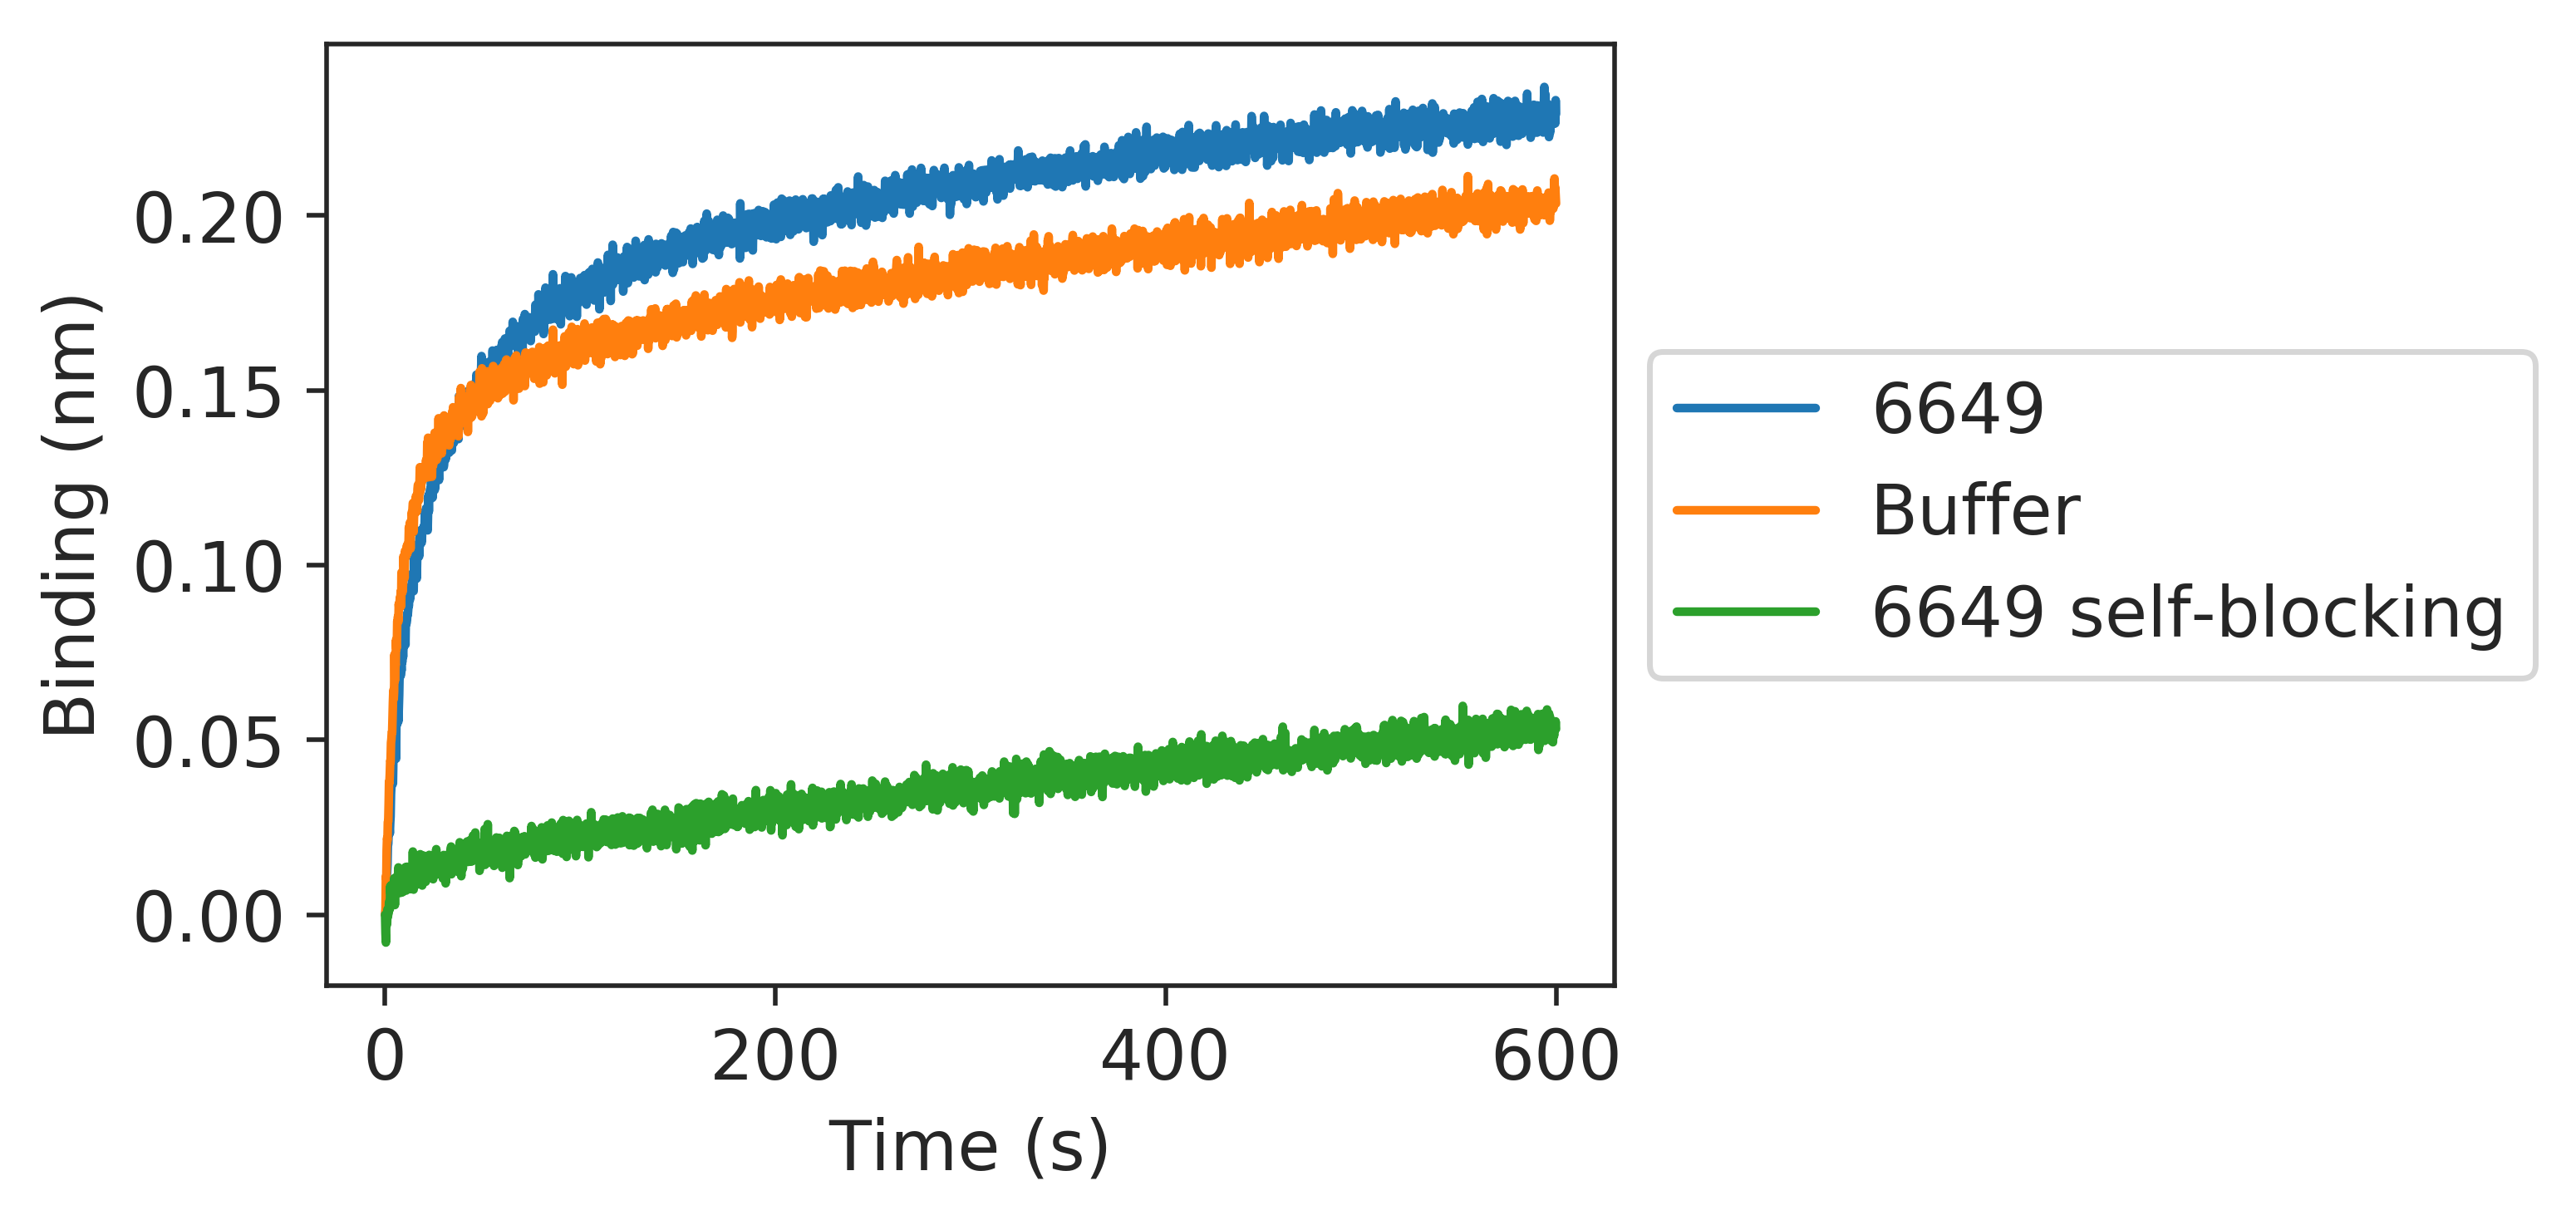

In [10]:
# Plot several assays

idx_assay = [1, 1]
sensors = [['A11', 'C11', 'G11'], ['B11', 'C11', 'H11']]
labels = [["CR9114", "Buffer", "CR9114 self-blocking"],
          ["6649", "Buffer", "6649 self-blocking"]]

for idx_assay_i, sensors_i, labels_i in zip(idx_assay, sensors, labels):

    Exp = assay_select_baseline(Exp_All_Raw, idx_assay_i, sensors_i)

    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    Exp.plot(ax=ax, x="time")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Binding (nm)")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=labels_i)

# Develop way to select specific samples from different assay steps

In [11]:
def assay_select_specific_baseline(Exp_All_Raw, selectors):
    
    Exp_Raw = pd.DataFrame()
    
    Exp_Raw["time"] = Exp_All_Raw["time"]
    
    for (idx_assay, sensor, label) in selectors:
        
        idx_start, idx_end = idx_start_end(idx_assay) # get start and end points of assay
        Exp_Raw_i = Exp_All_Raw.loc[idx_start:idx_end][sensor].reset_index(drop=True) # select timepoints and sensors
        Exp_Raw_i.name = label # set column name as label
        Exp_Raw = Exp_Raw.join(Exp_Raw_i, how="right") # join to result
                
    Exp = Exp_Raw - Exp_Raw.iloc[0] # subtract initial value
    
    return Exp

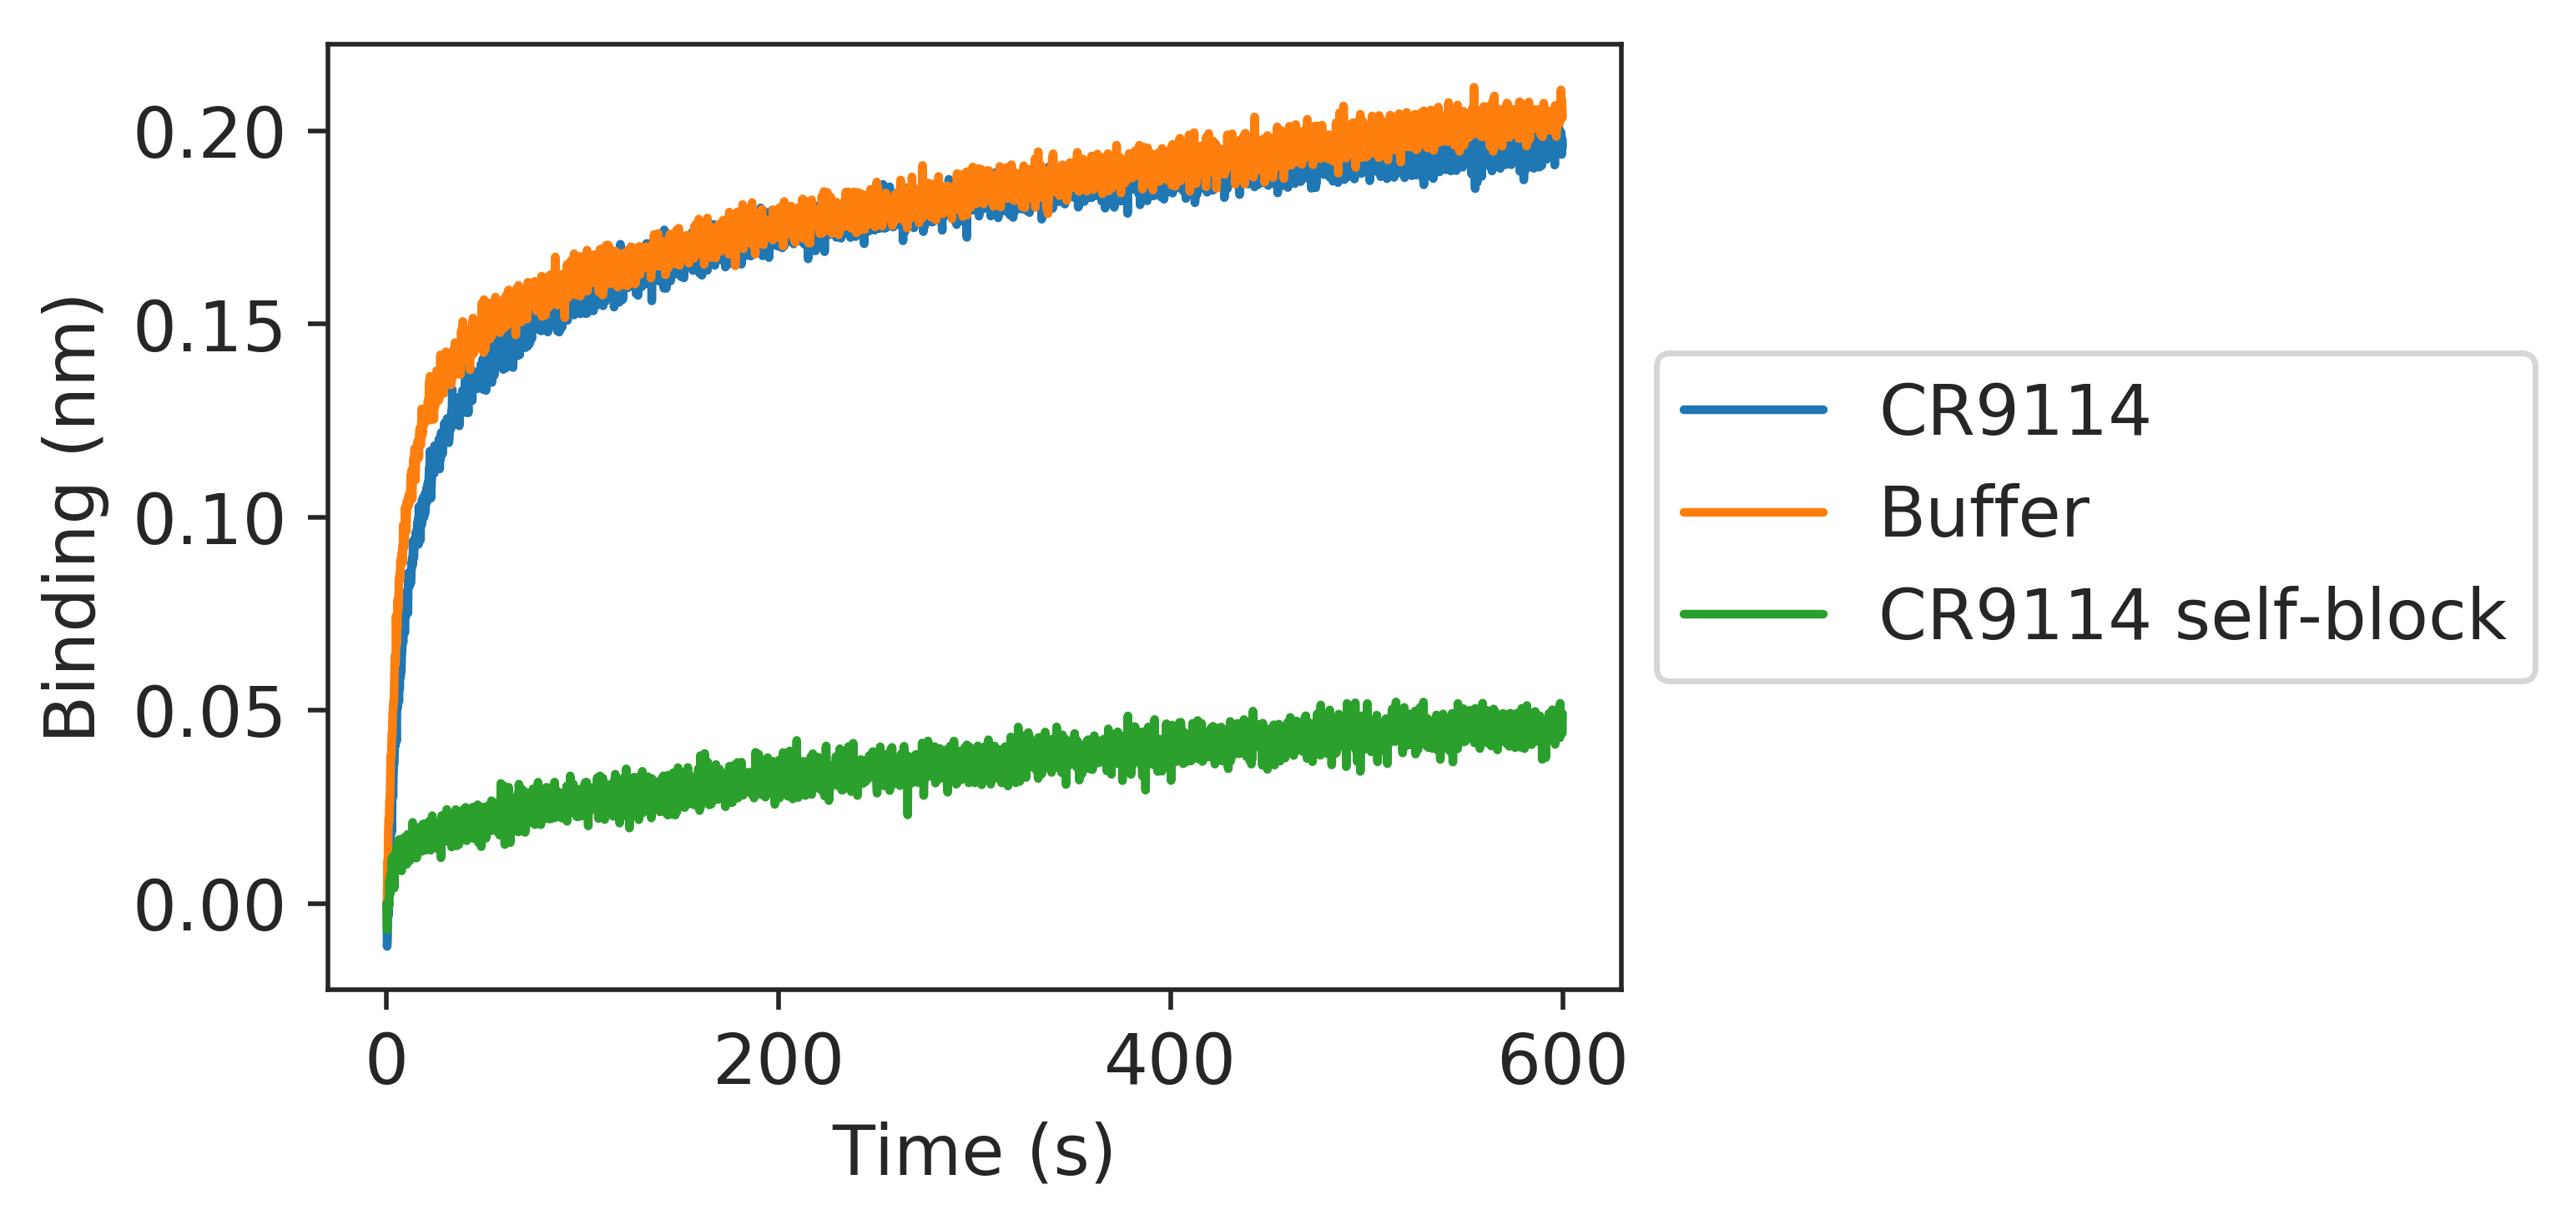

In [12]:
selectors = [(1, "A11", "CR9114"), (1, "C11", "Buffer"), (1, "G11", "CR9114 self-block")]

Exp = assay_select_specific_baseline(Exp_All_Raw, selectors)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
Exp.plot(ax=ax, x="time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Binding (nm)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Plot all assays

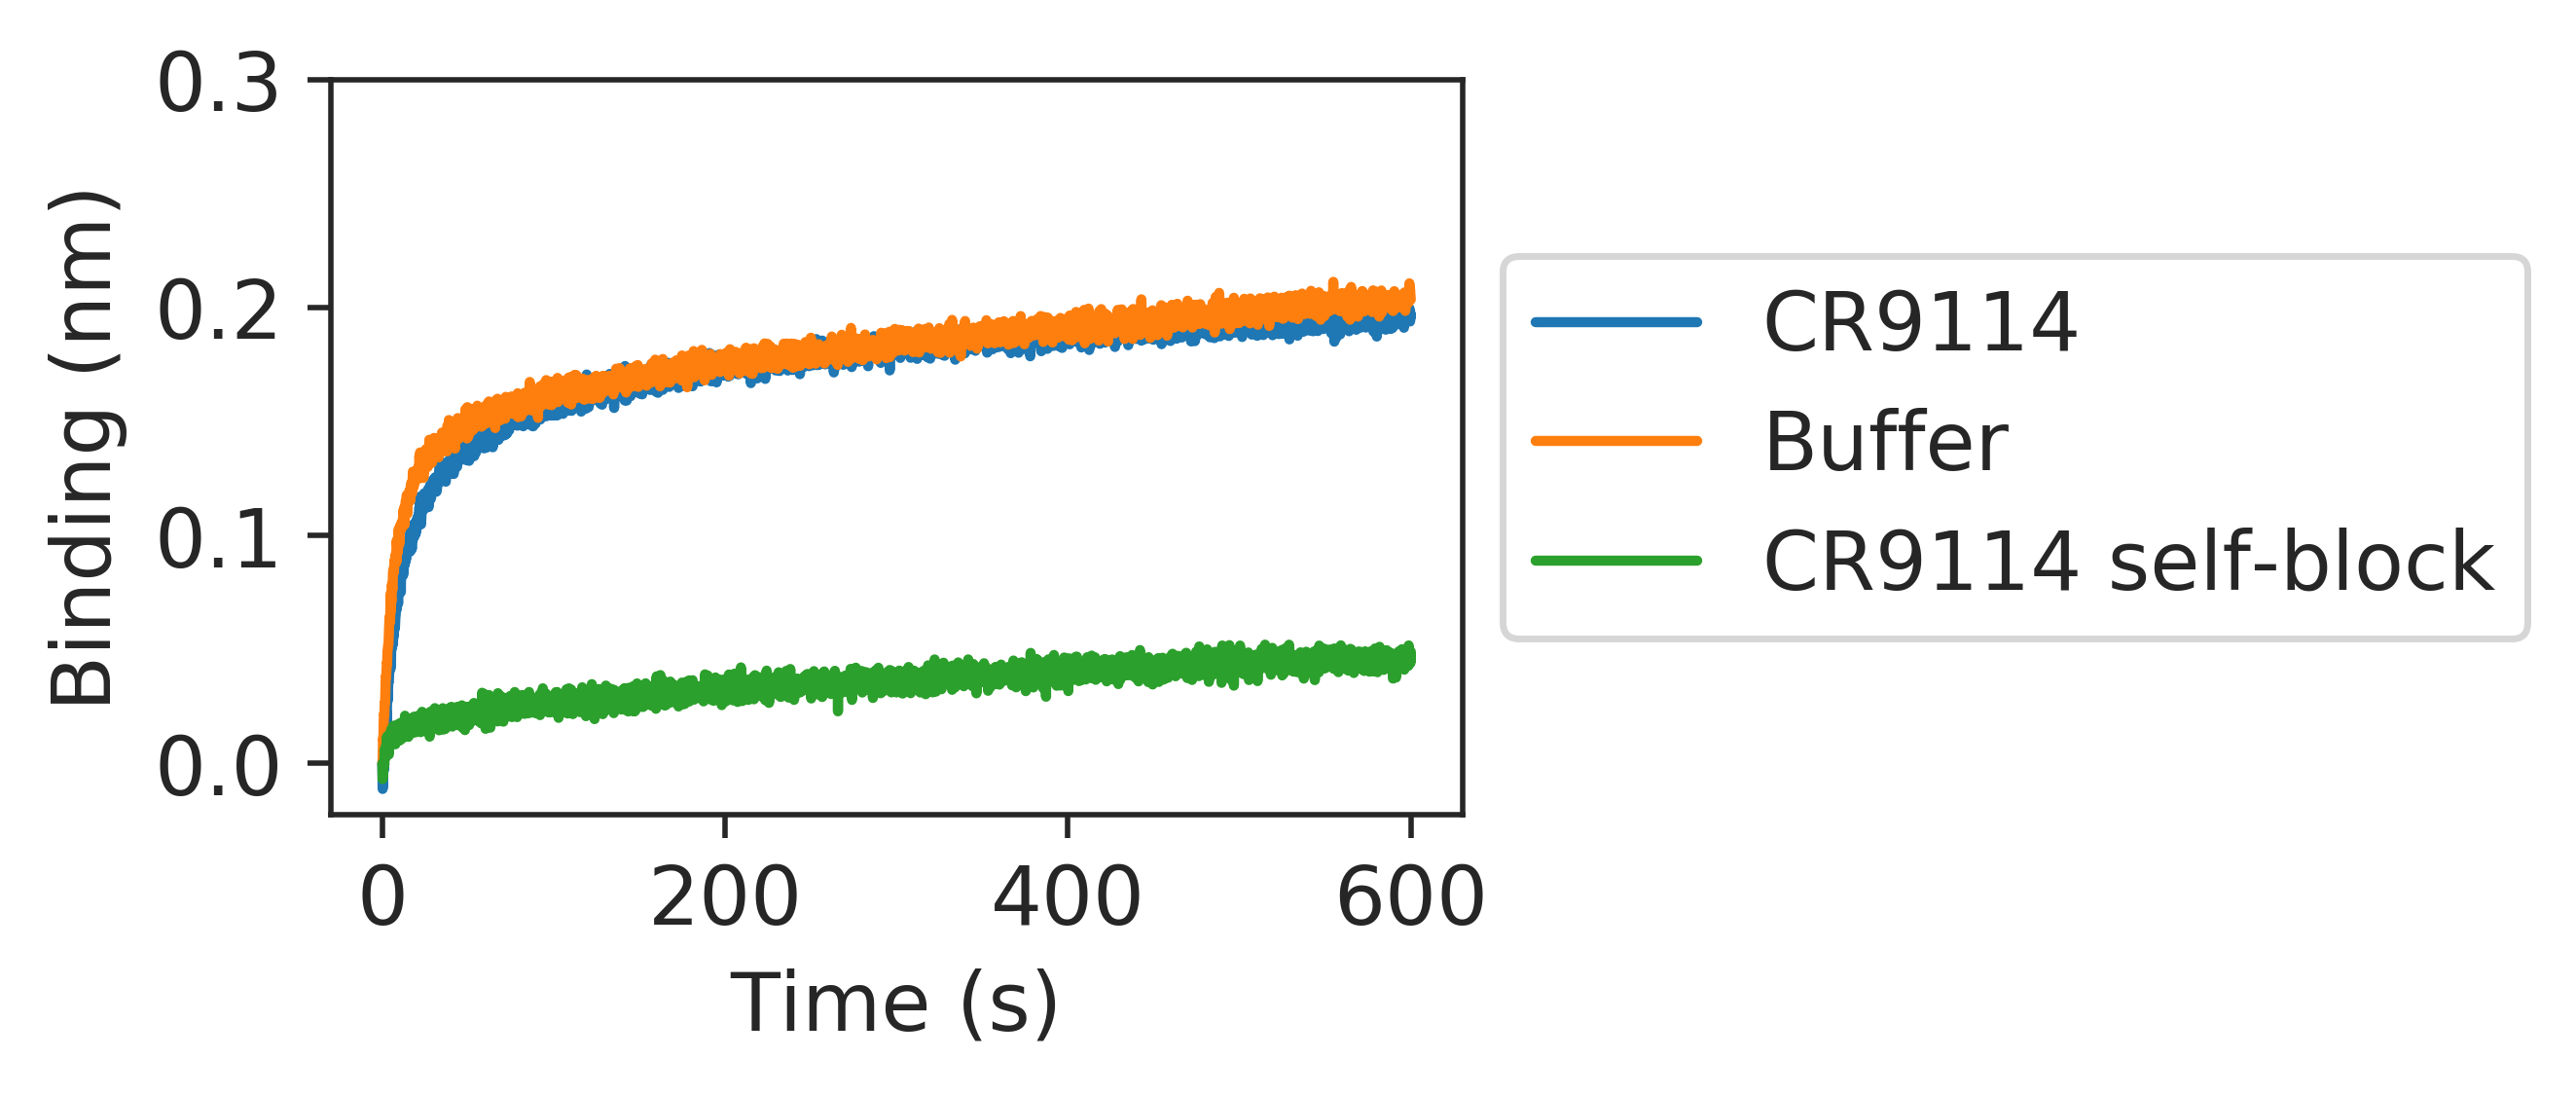

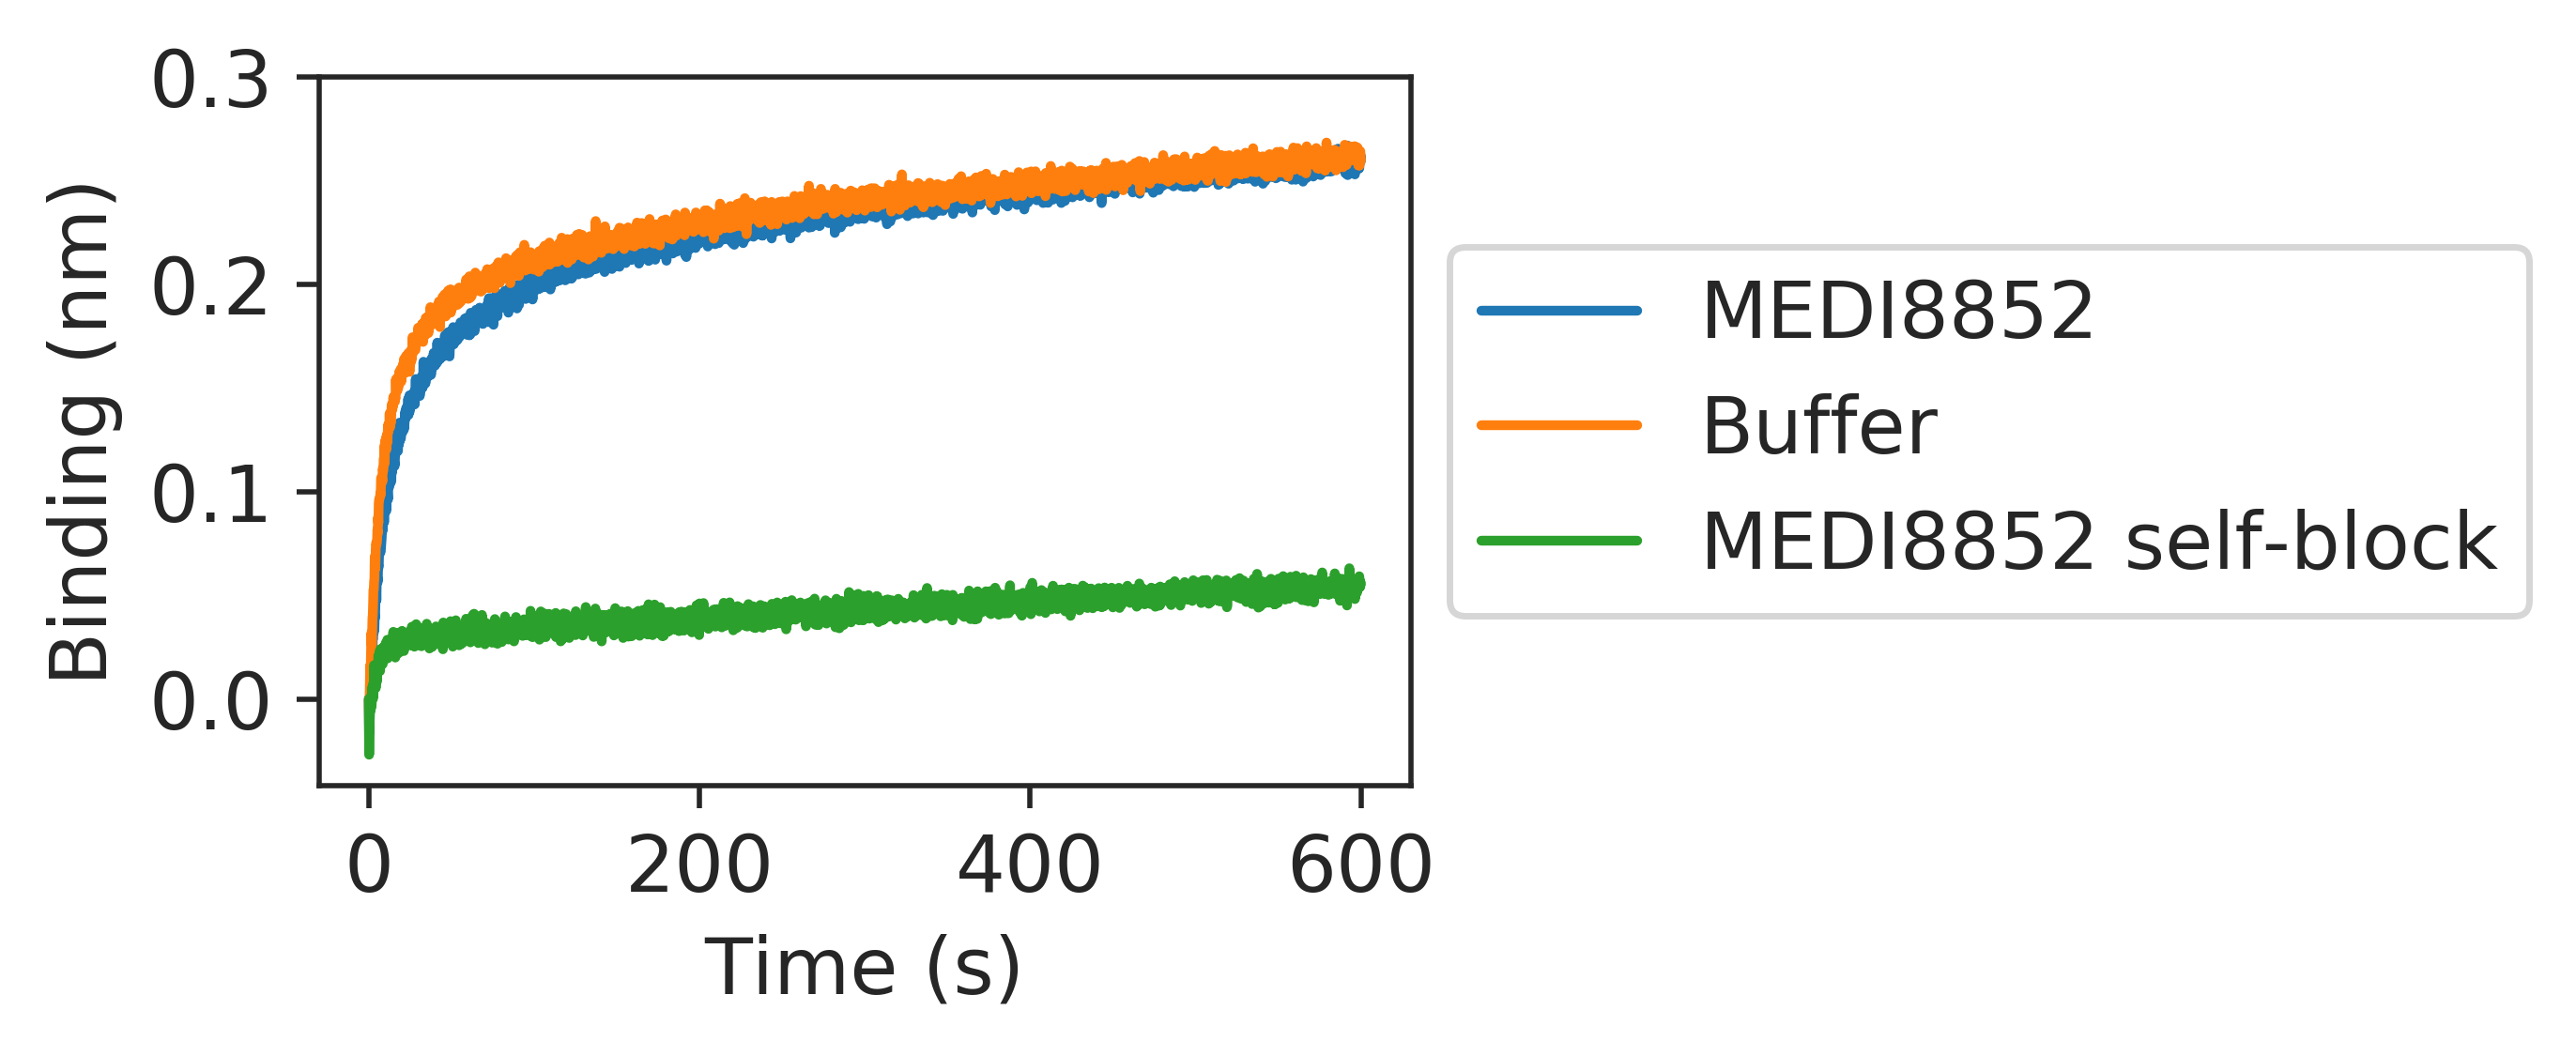

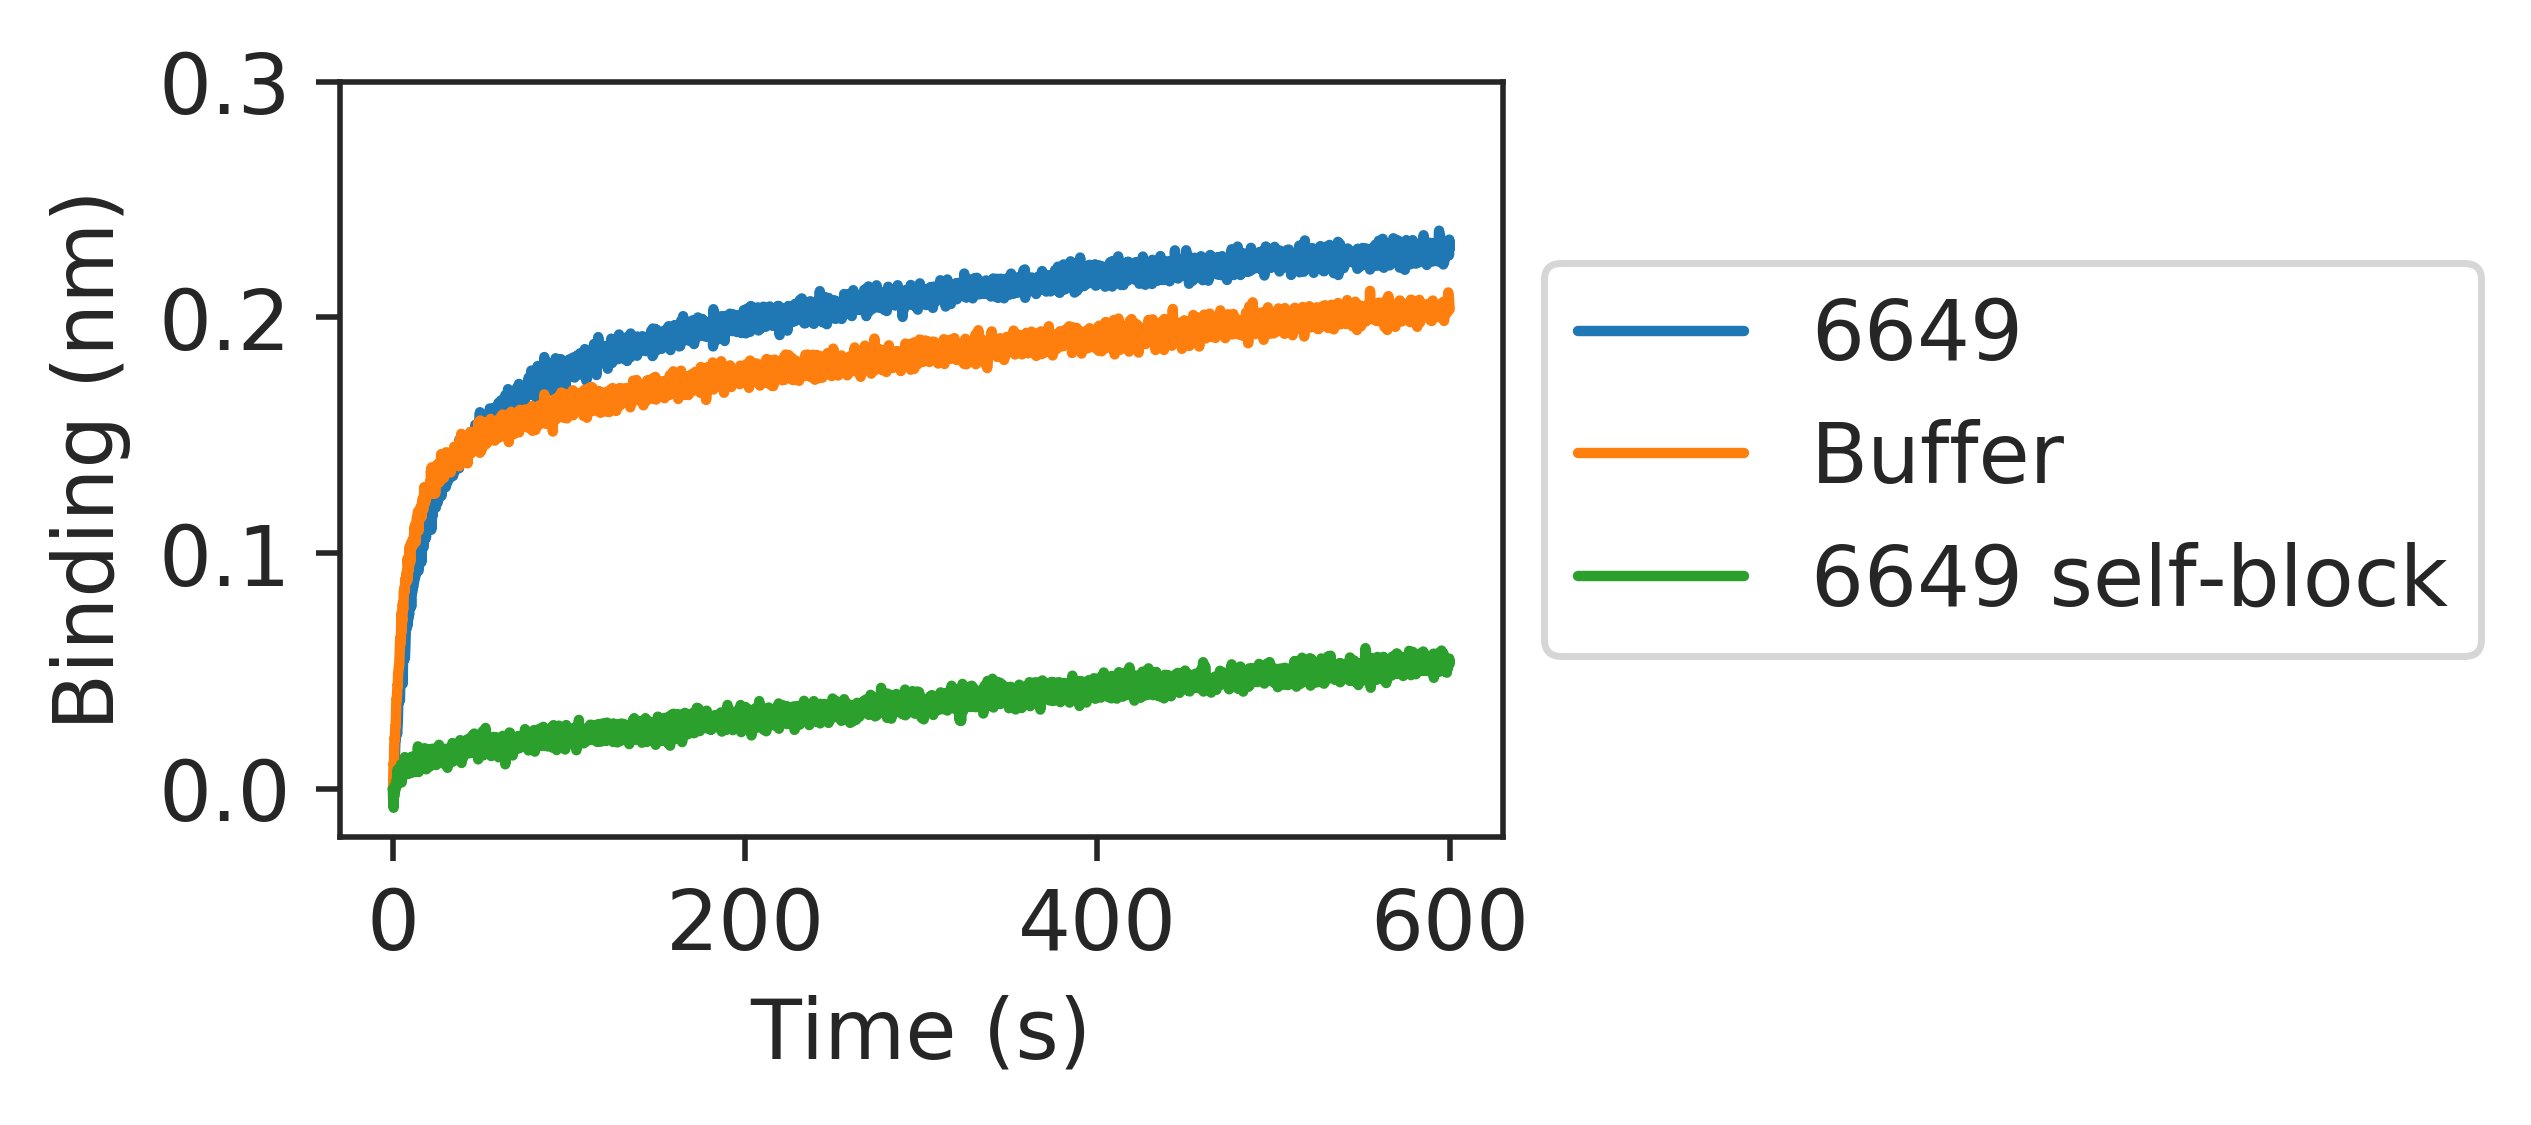

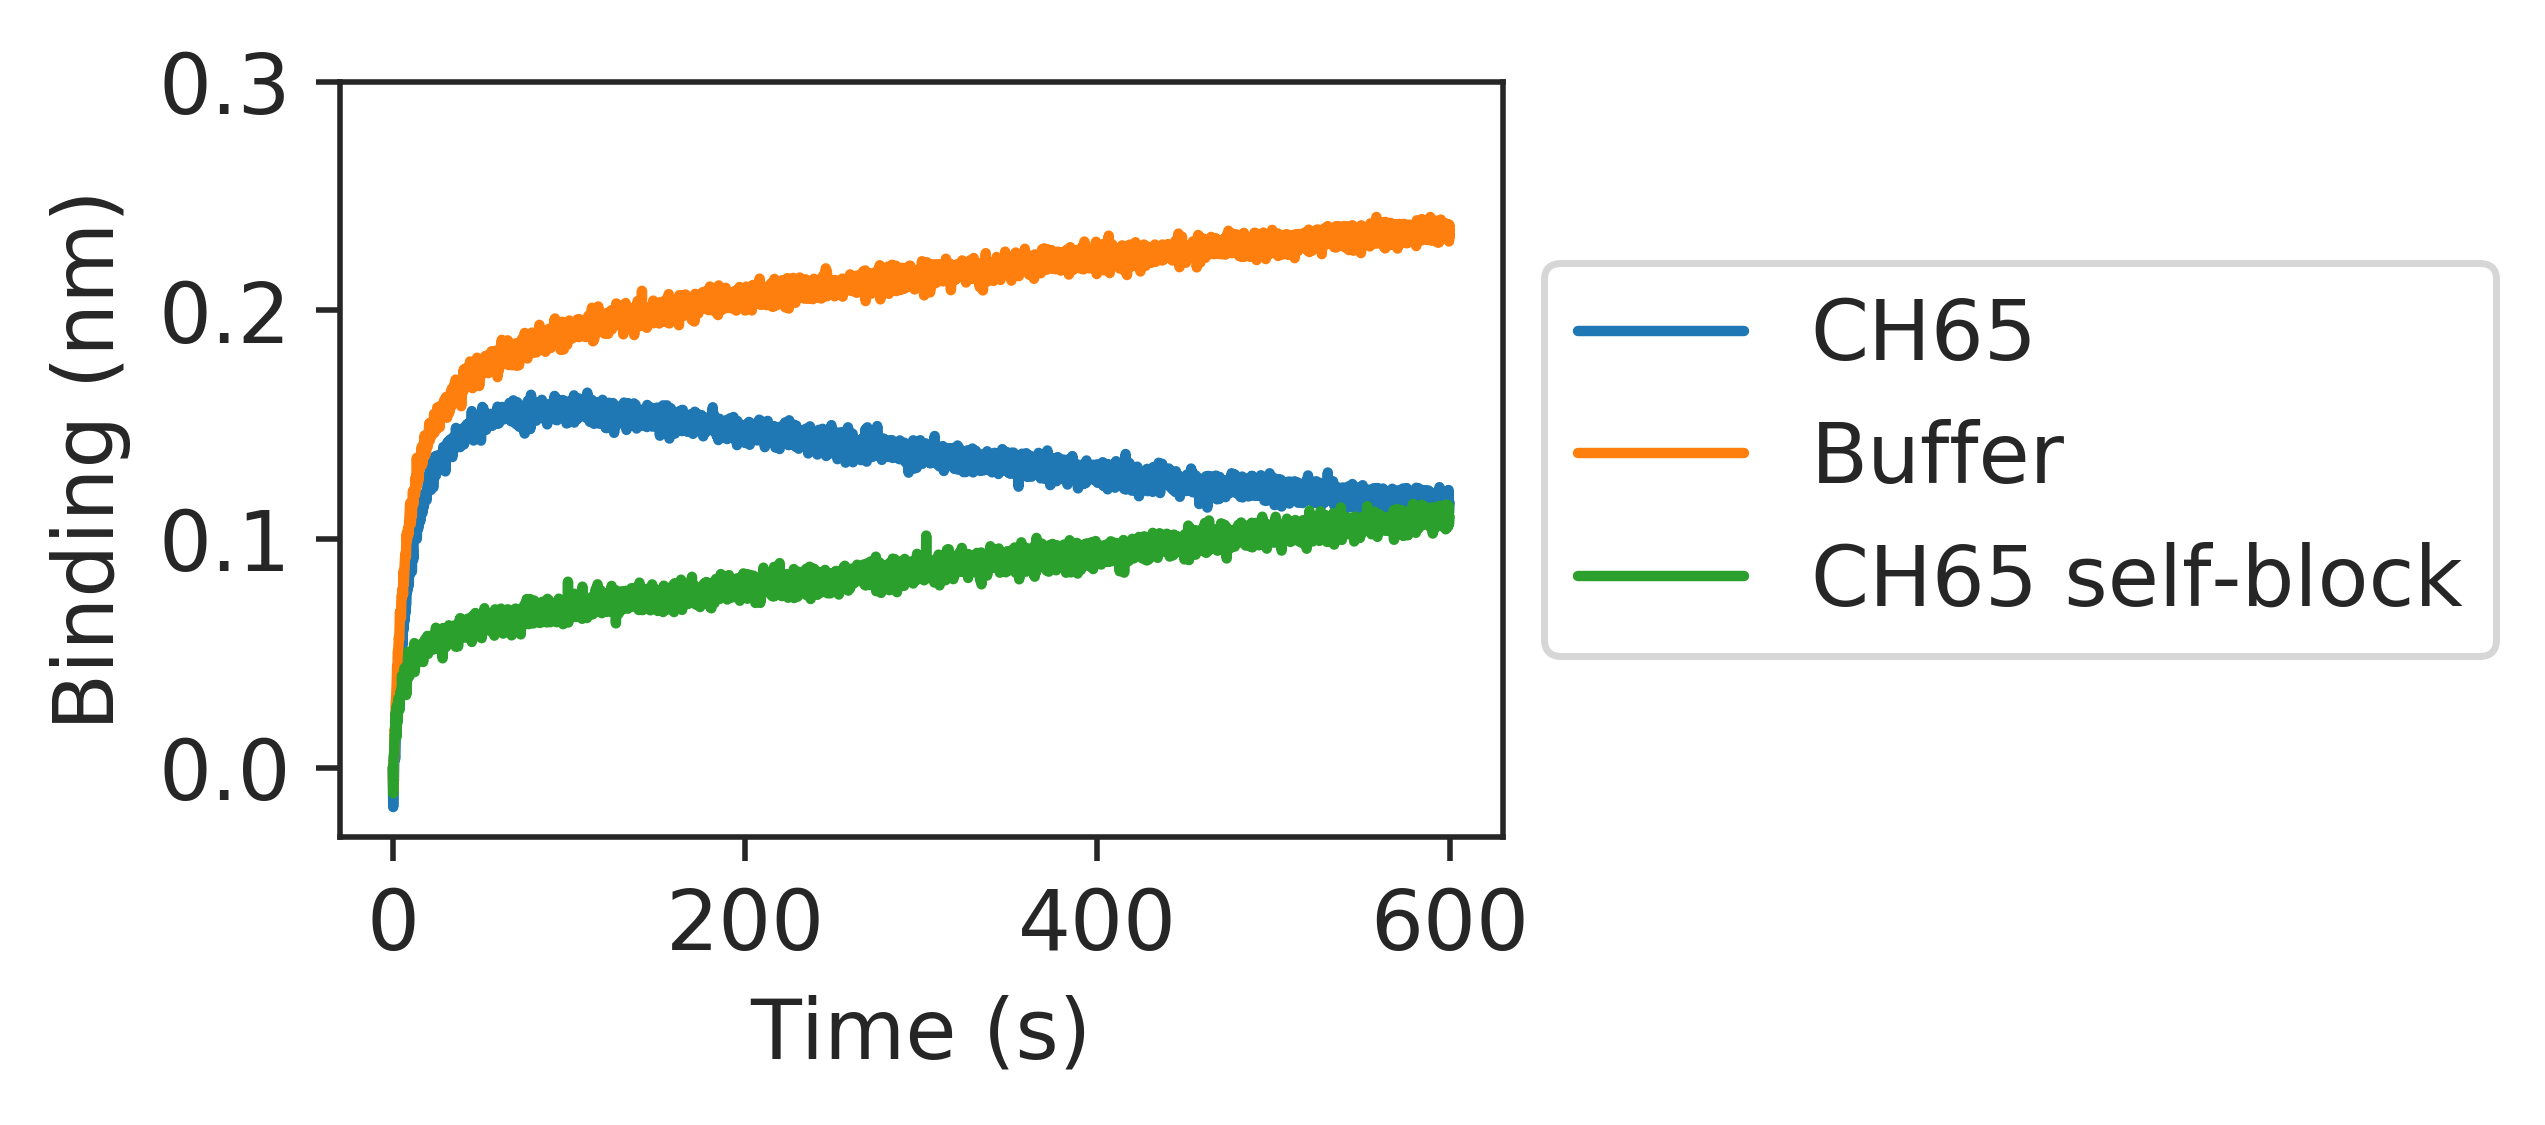

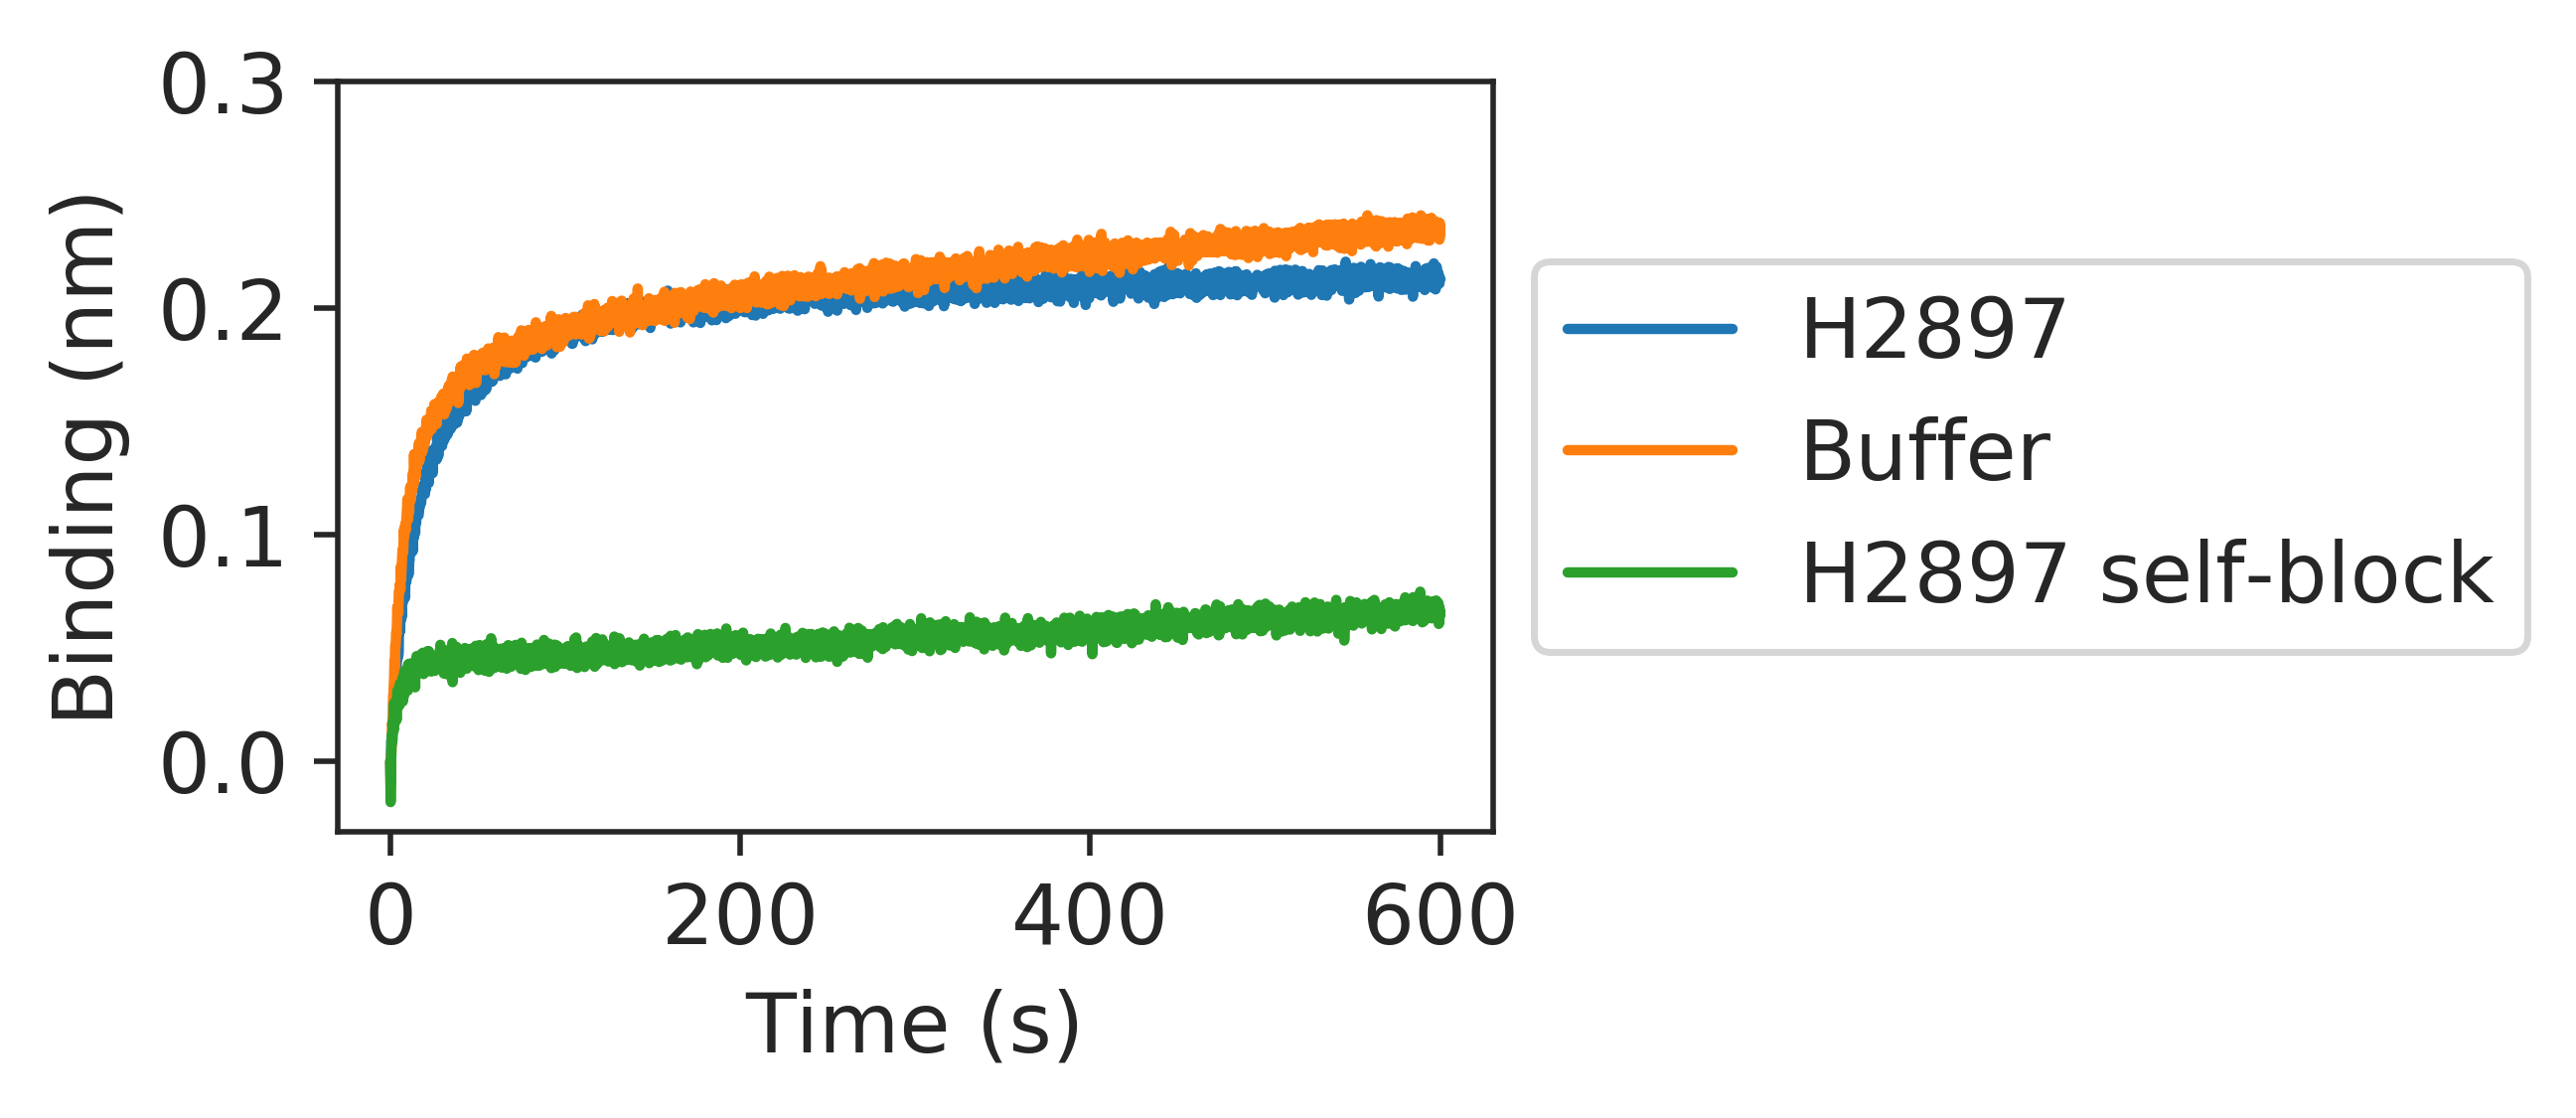

In [13]:
# N1

selectors = [[(1, "A11", "CR9114"), (1, "C11", "Buffer"), (1, "G11", "CR9114 self-block")],
             [(3, "A11", "MEDI8852"), (3, "C11", "Buffer"), (5, "A11", "MEDI8852 self-block")],
             [(1, "B11", "6649"), (1, "C11", "Buffer"), (1, "H11", "6649 self-block")],
             [(2, "A11", "CH65"), (2, "C11", "Buffer"), (4, "G11", "CH65 self-block")],
             [(2, "B11", "H2897"), (2, "C11", "Buffer"), (4, "H11", "H2897 self-block")]]

for selector in selectors:
    Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    Exp.plot(ax=ax, x="time")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Binding (nm)")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_ylim(top=0.3)

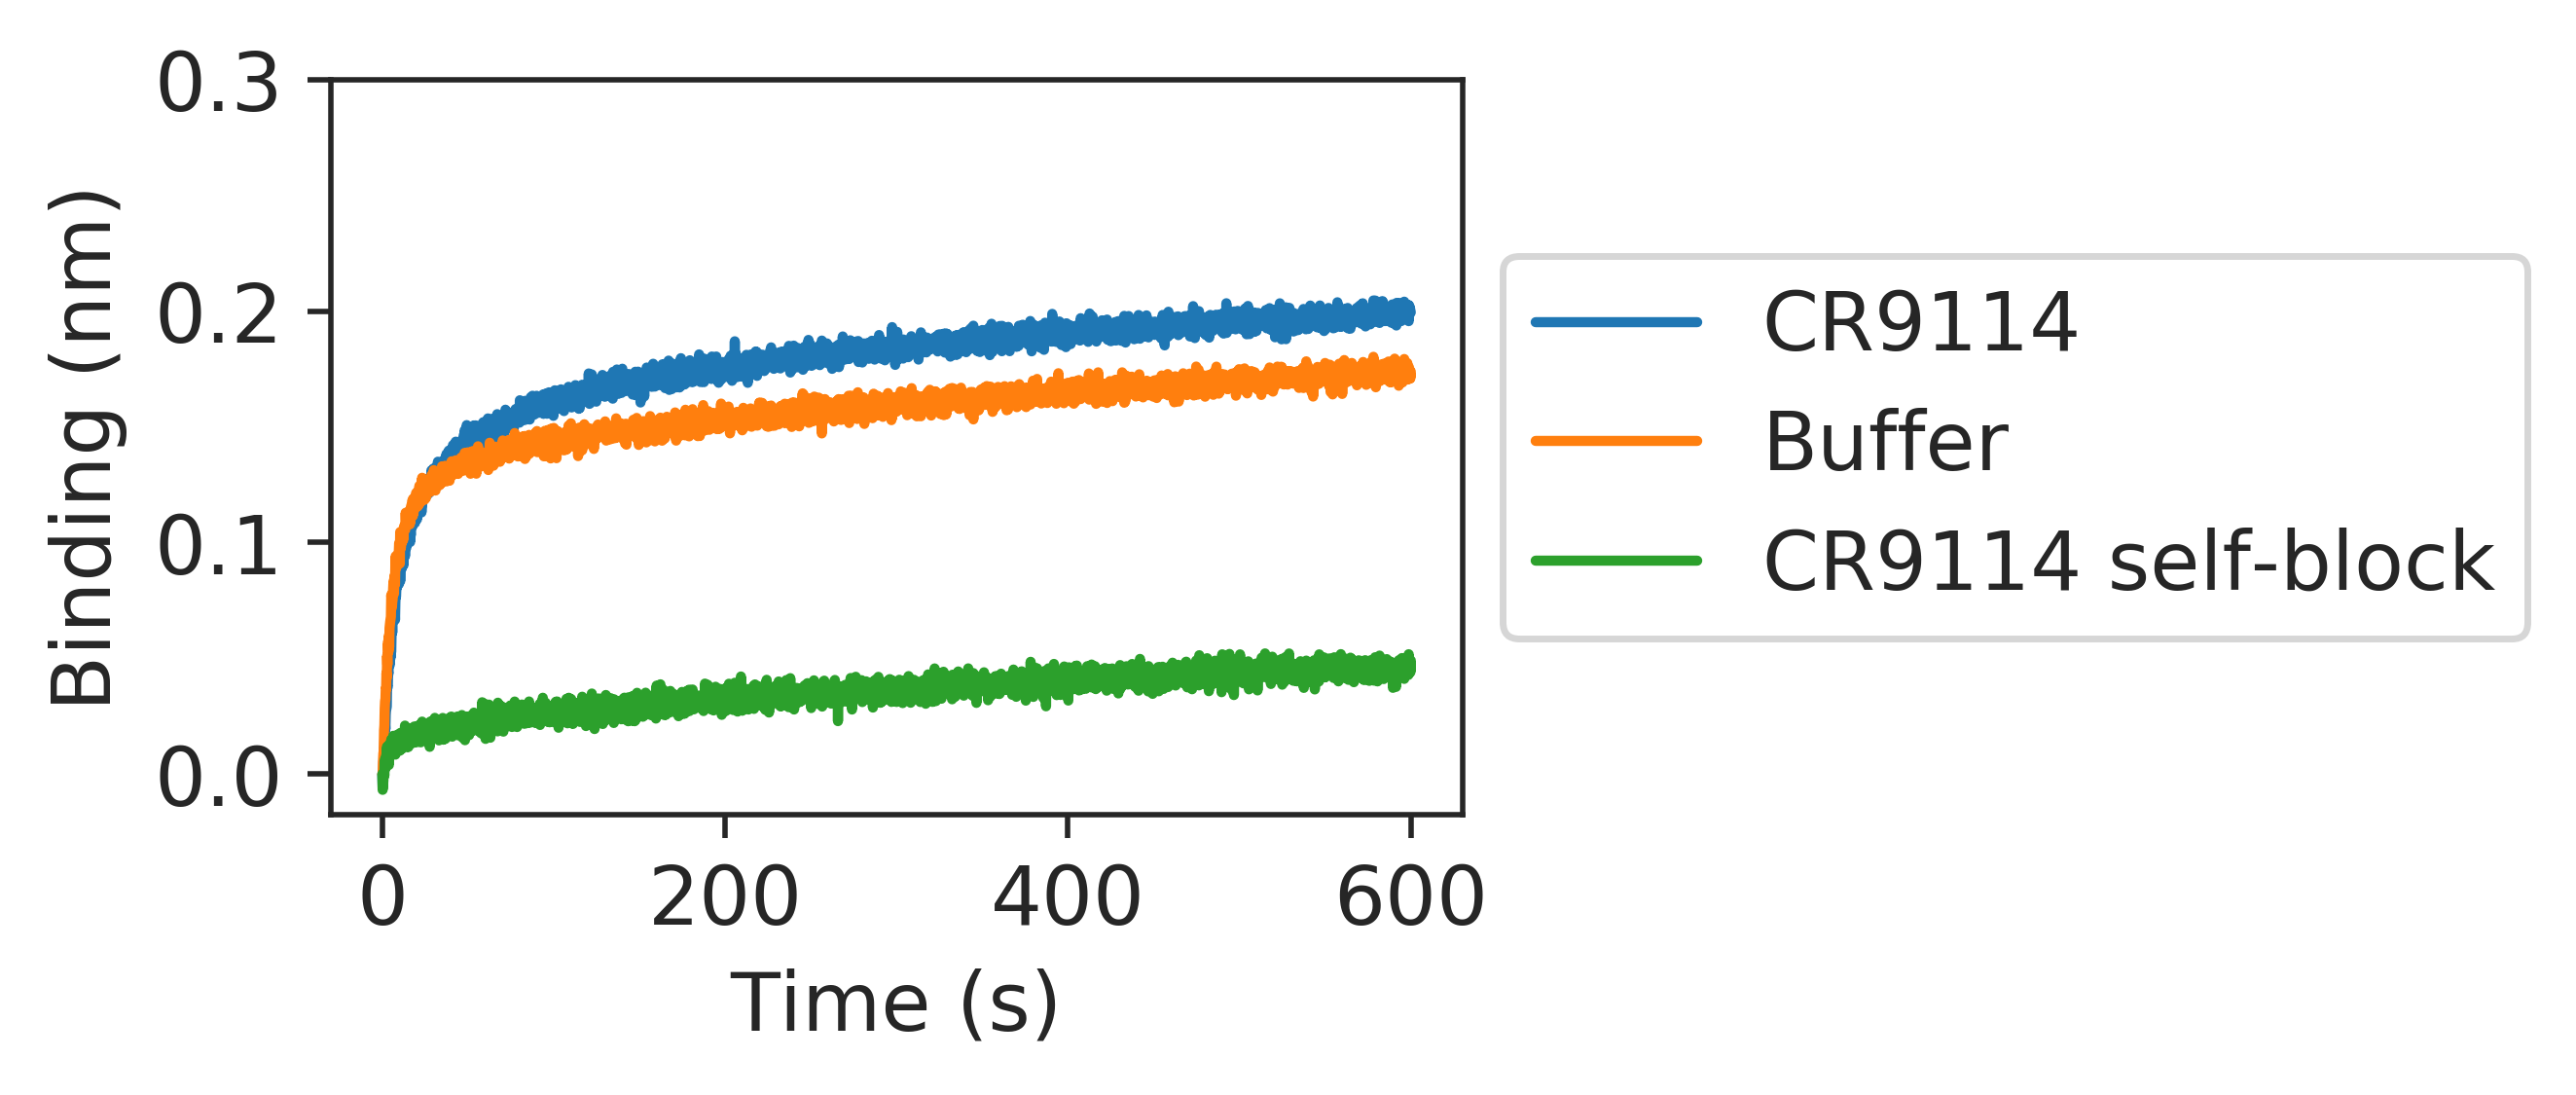

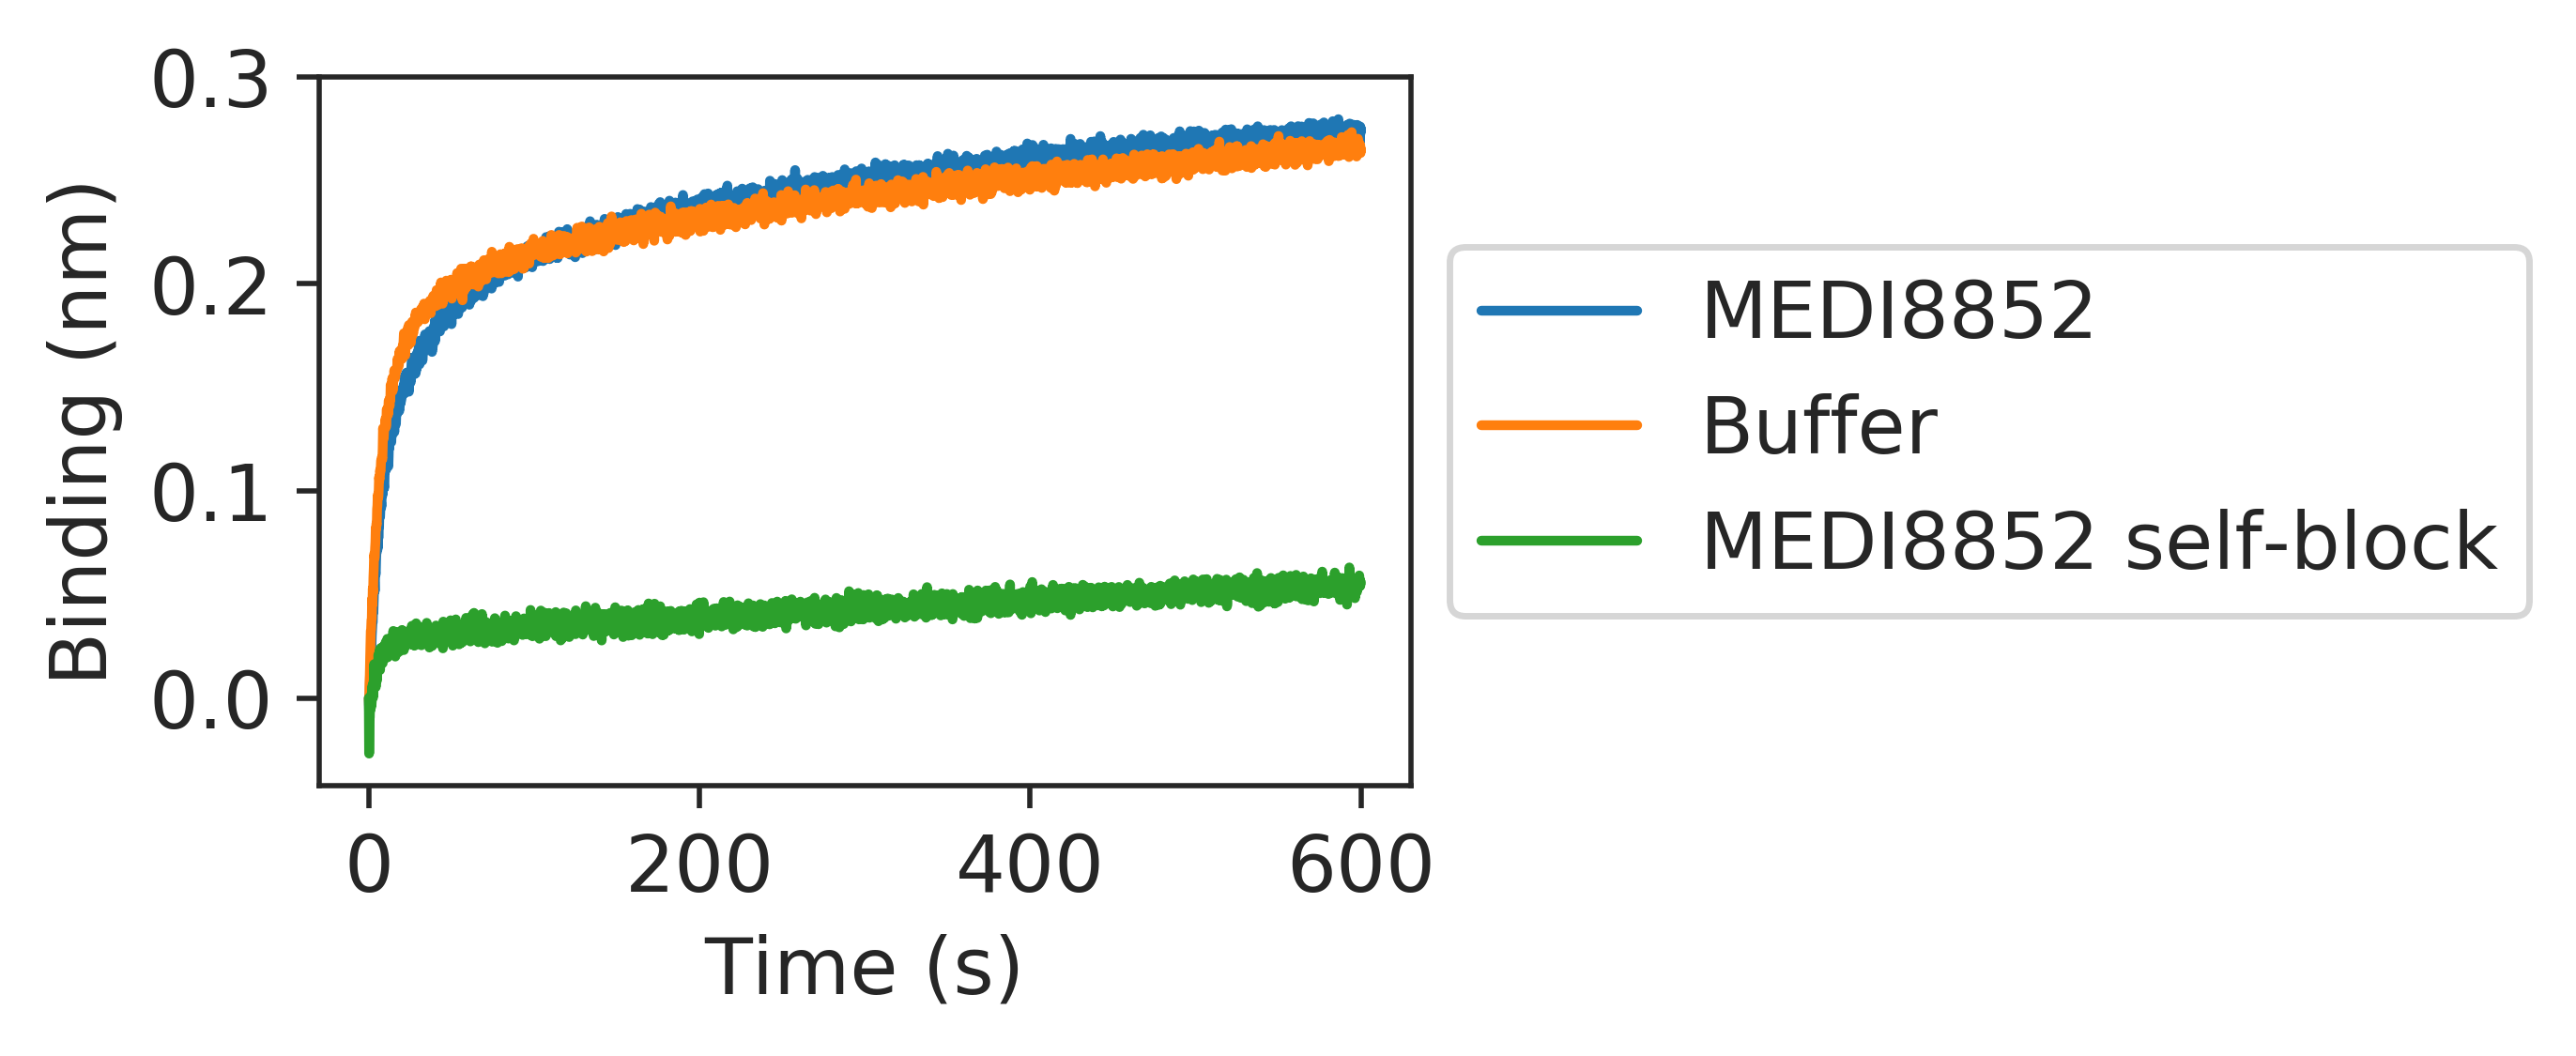

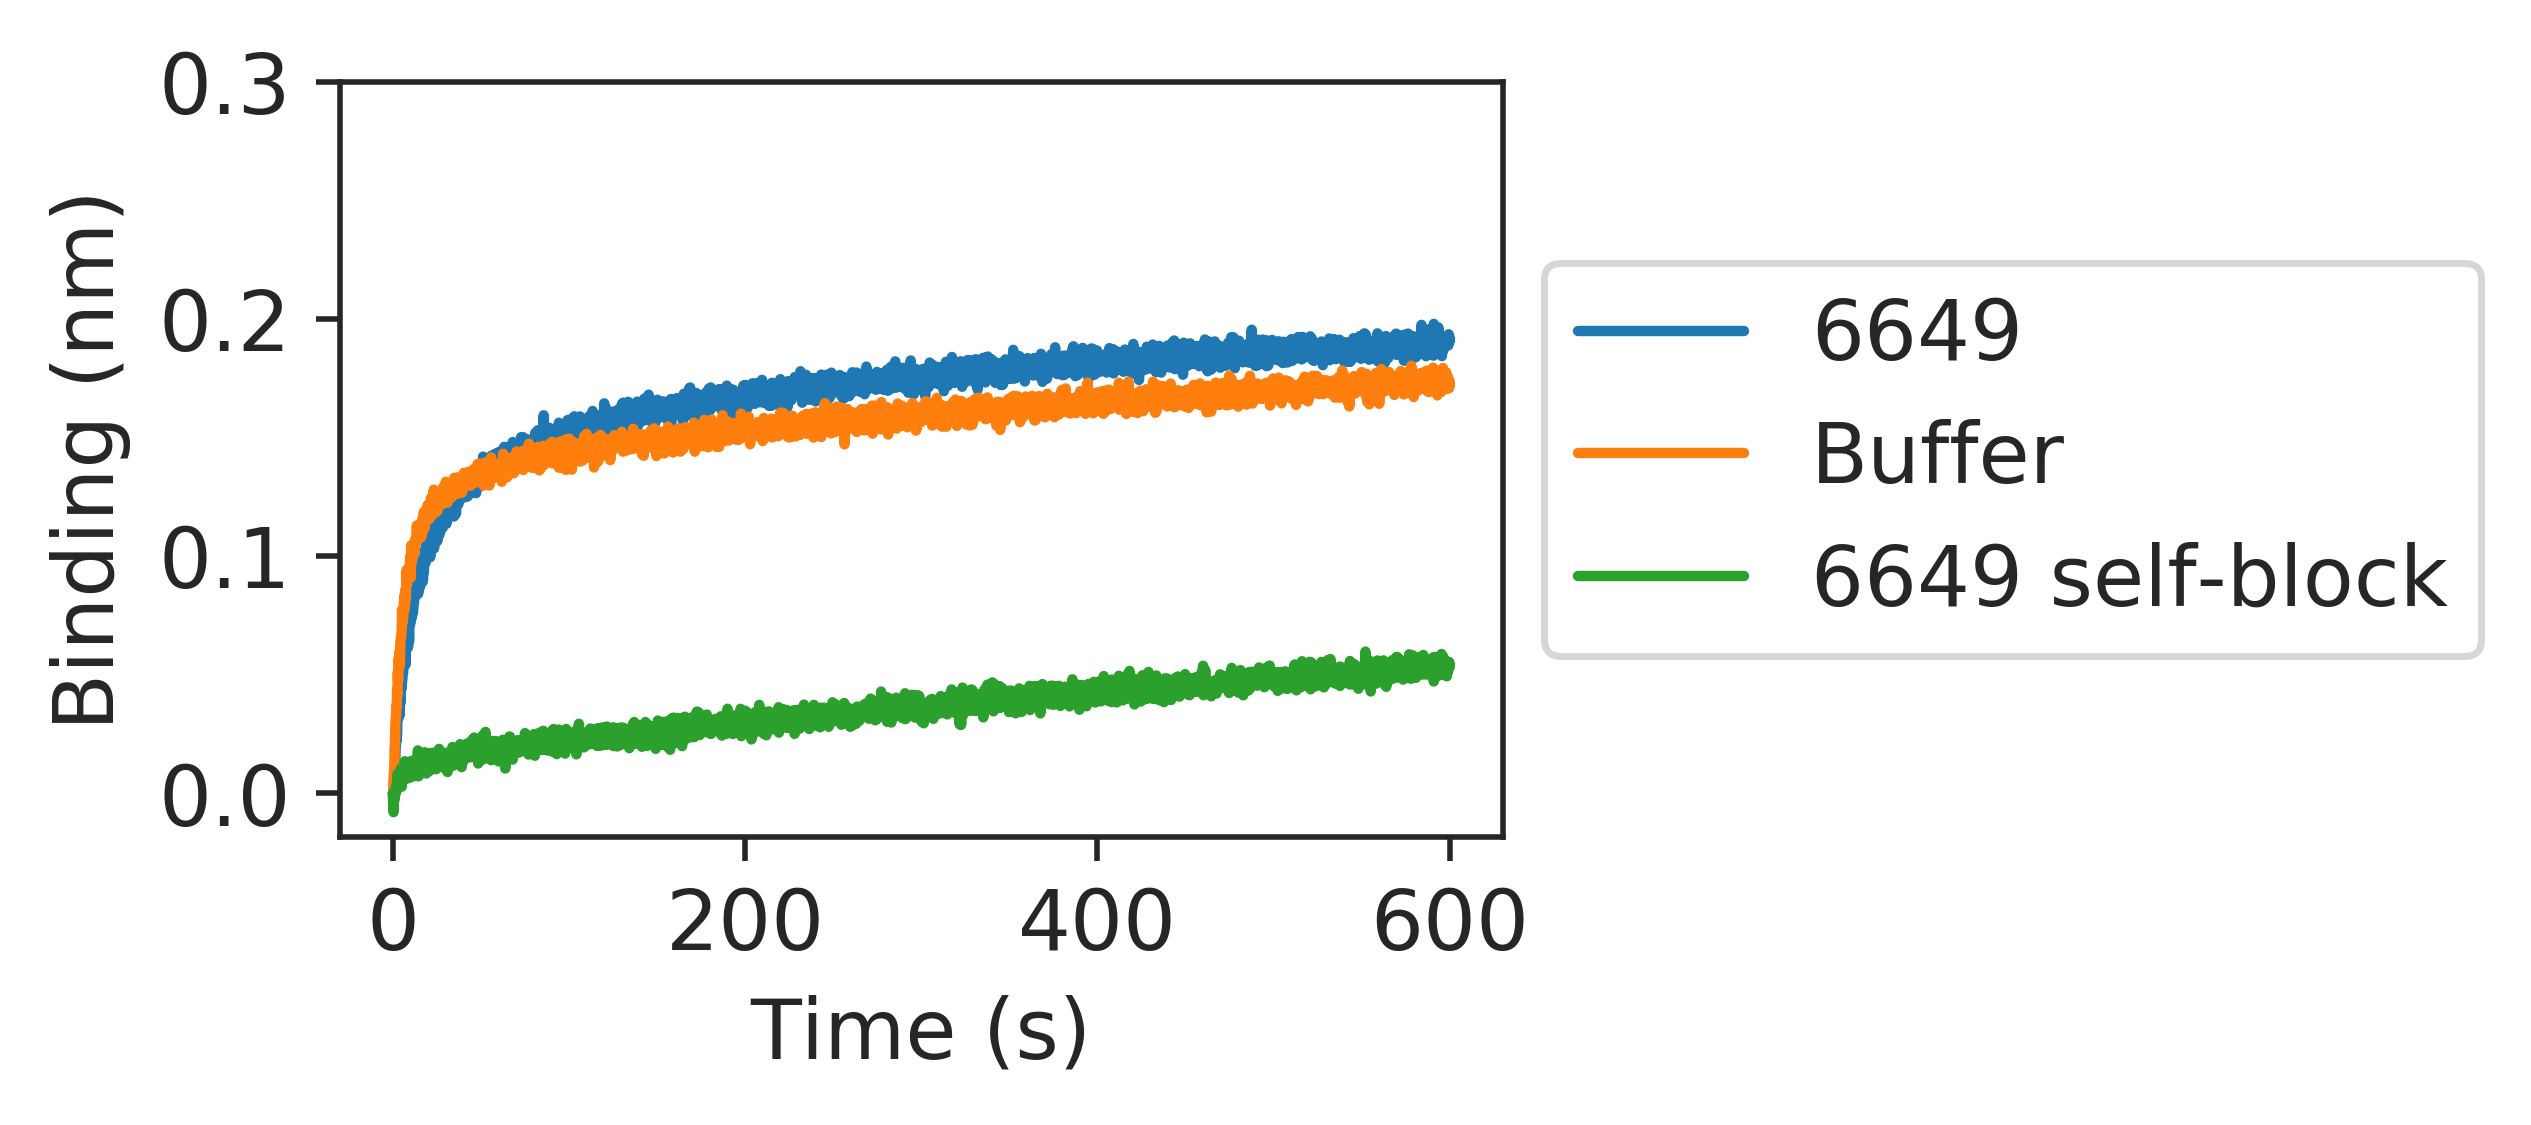

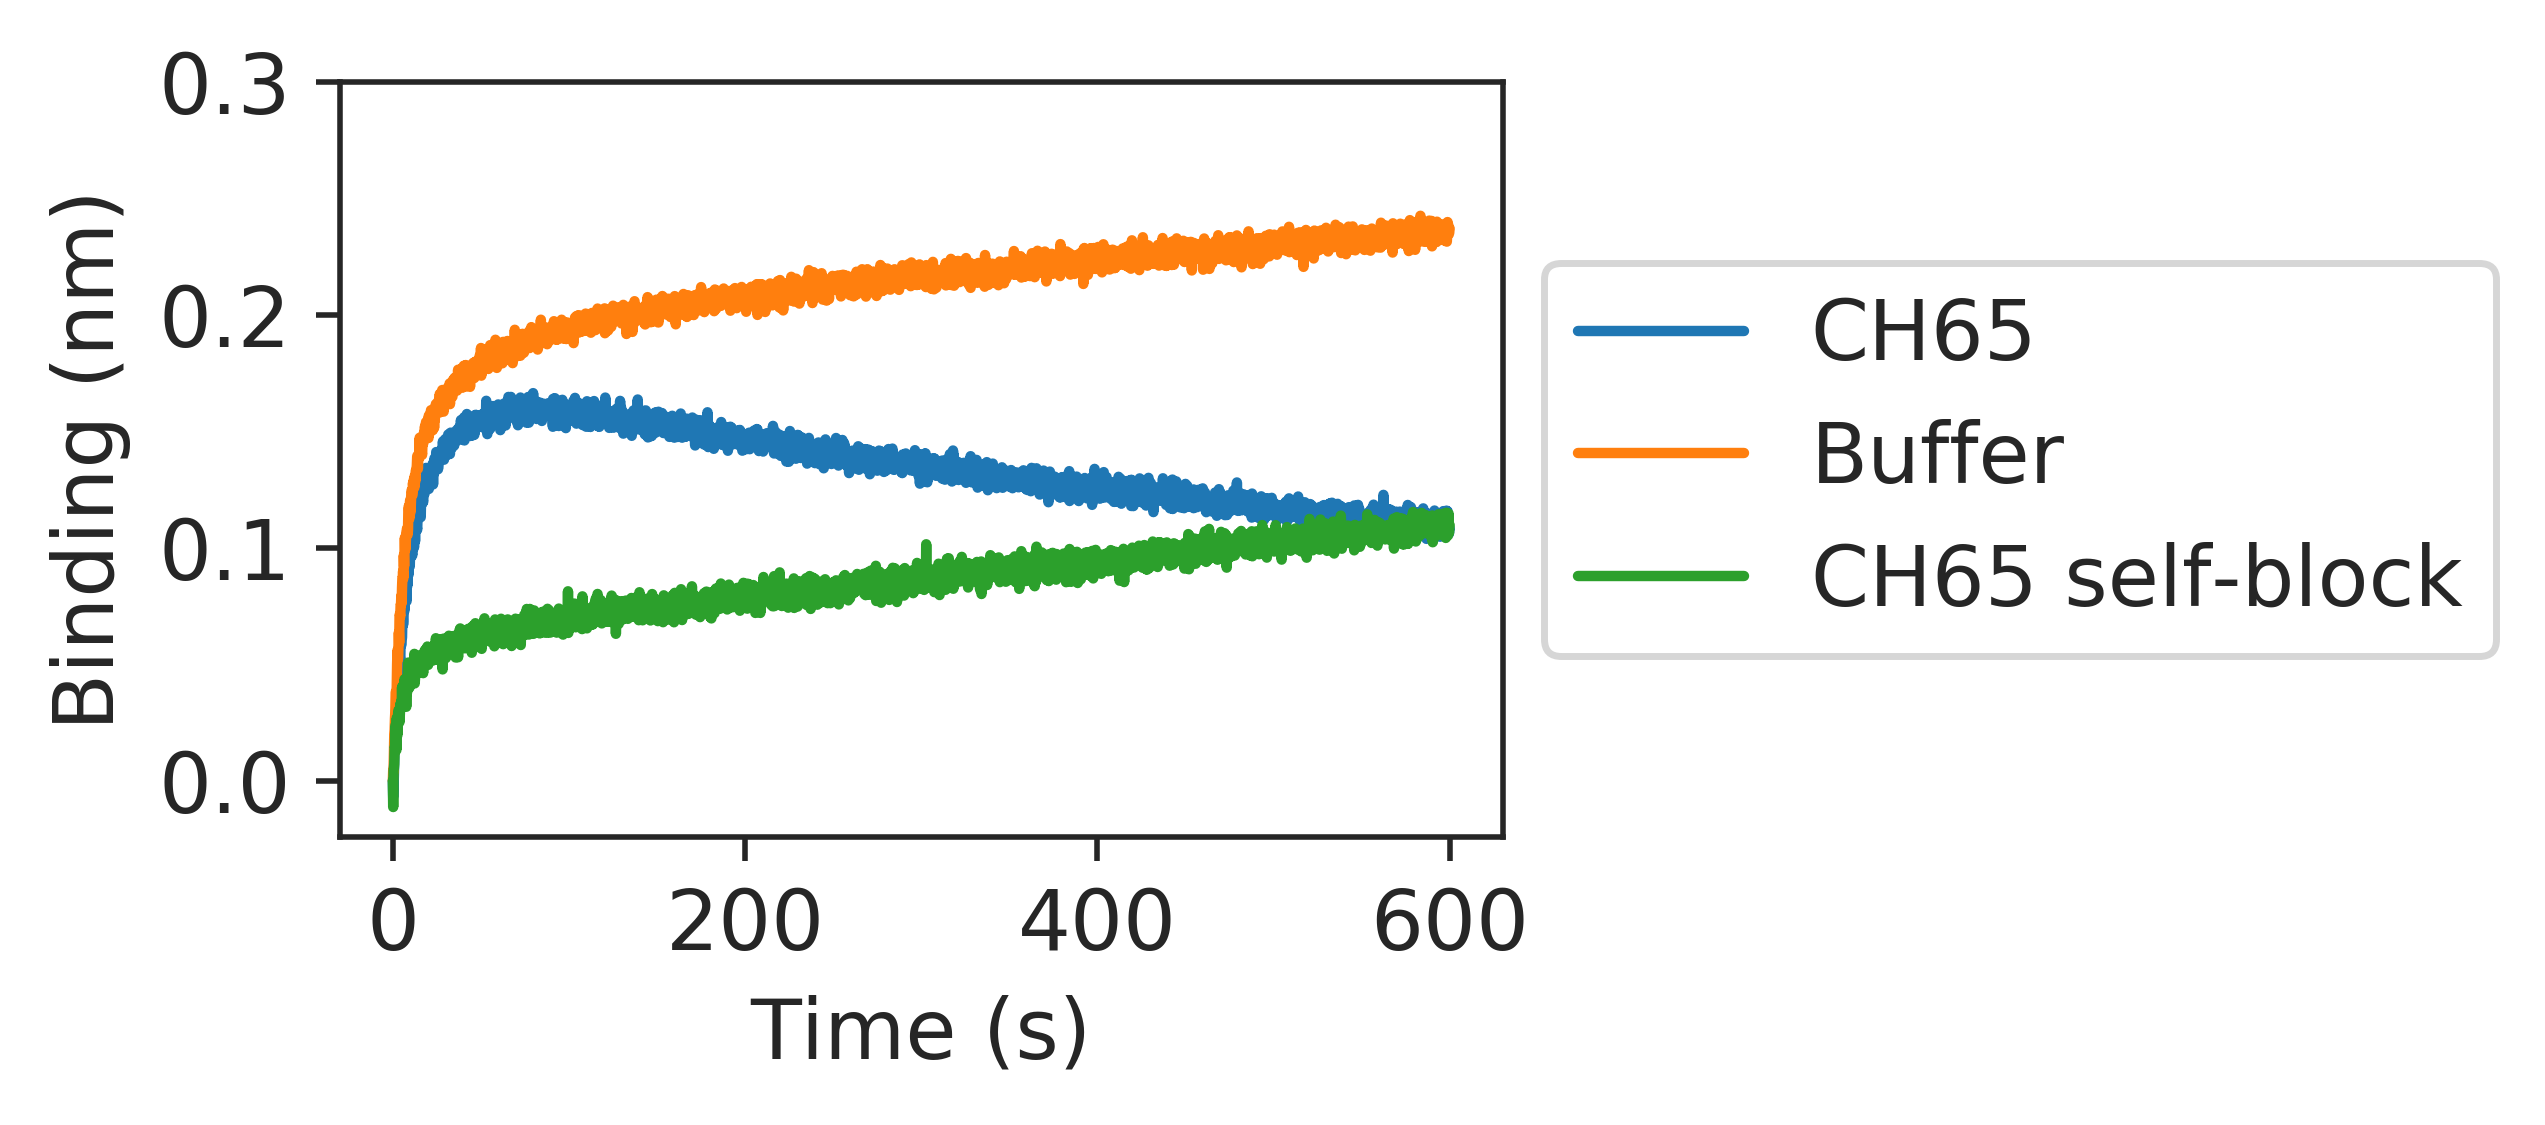

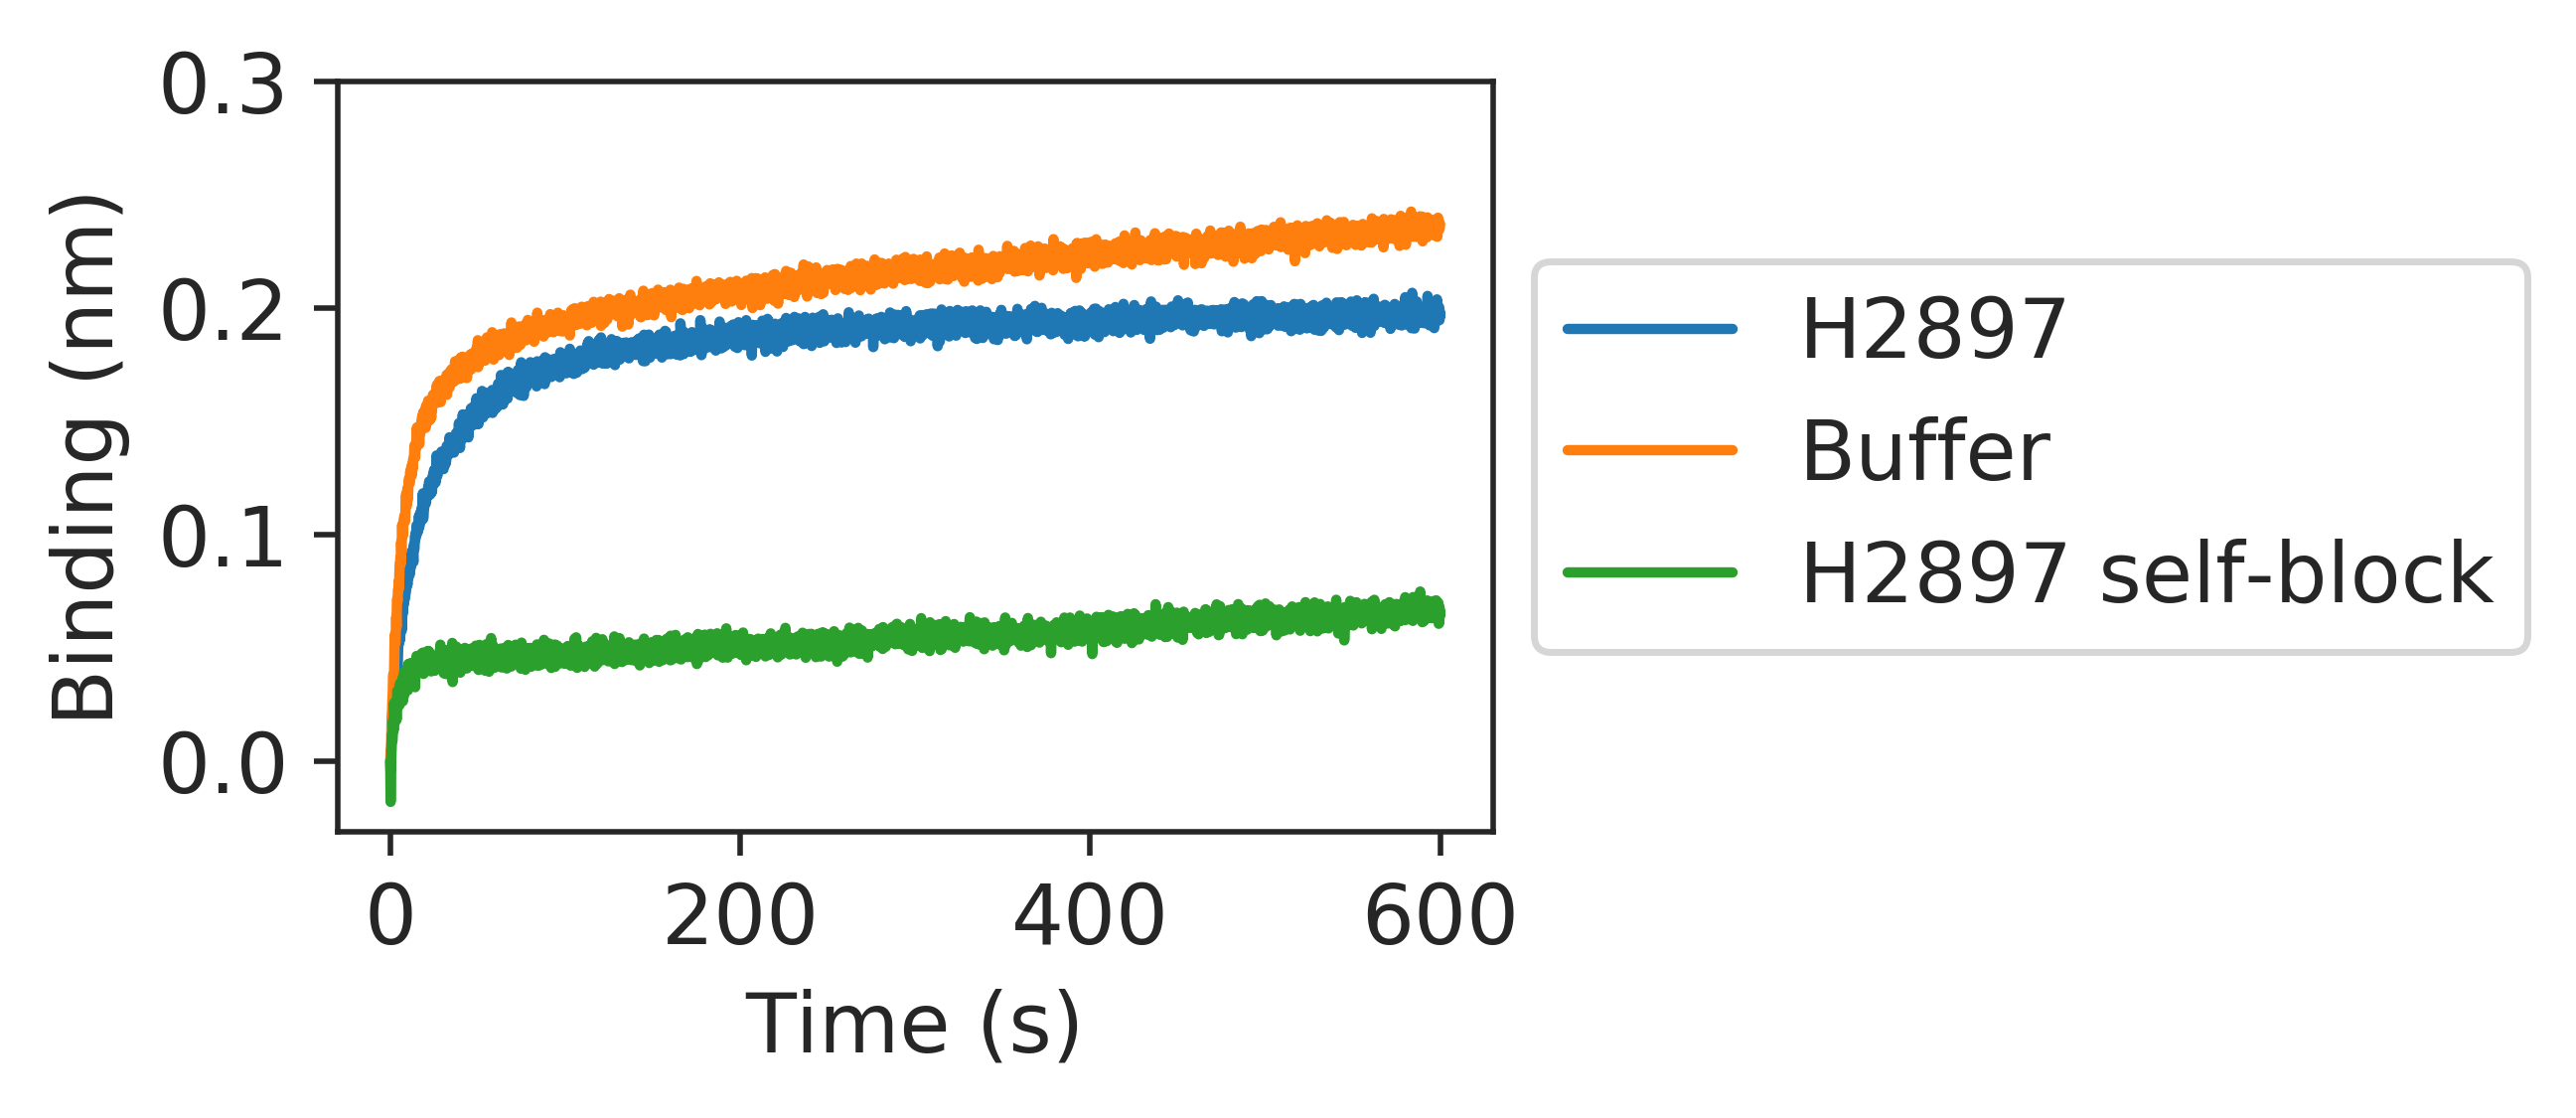

In [14]:
# N6

selectors = [[(1, "D11", "CR9114"), (1, "F11", "Buffer"), (1, "G11", "CR9114 self-block")],
             [(3, "D11", "MEDI8852"), (3, "E11", "Buffer"), (5, "A11", "MEDI8852 self-block")],
             [(1, "E11", "6649"), (1, "F11", "Buffer"), (1, "H11", "6649 self-block")],
             [(2, "D11", "CH65"), (2, "F11", "Buffer"), (4, "G11", "CH65 self-block")],
             [(2, "E11", "H2897"), (2, "F11", "Buffer"), (4, "H11", "H2897 self-block")]]

for selector in selectors:
    Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    Exp.plot(ax=ax, x="time")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Binding (nm)")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_ylim(top=0.3)

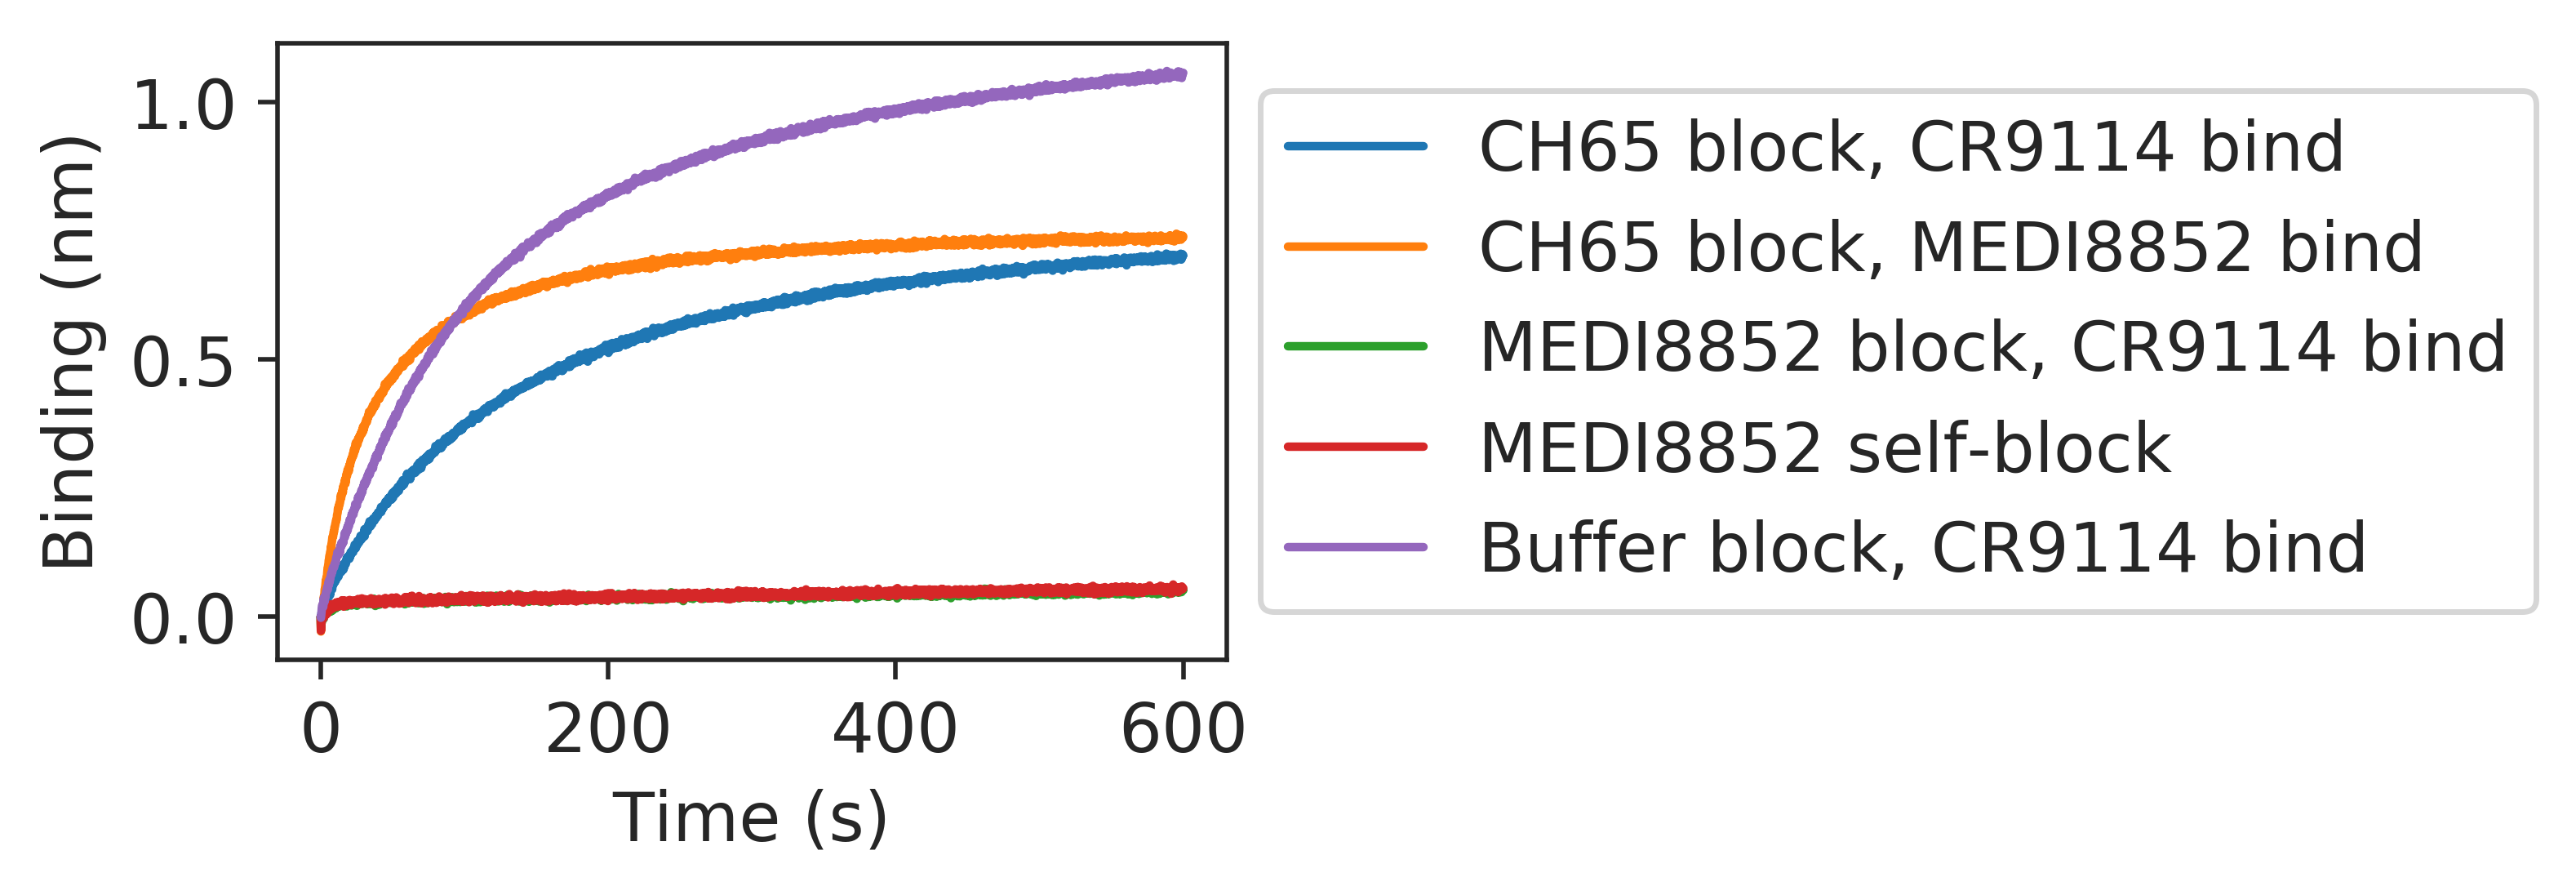

In [15]:
# Cross-competition

selectors = [[(2, "G11", "CH65 block, CR9114 bind"), 
              (4, "A11", "CH65 block, MEDI8852 bind"),
              (5, "B11", "MEDI8852 block, CR9114 bind"),
              (5, "A11", "MEDI8852 self-block"),
              (3, "G11", "Buffer block, CR9114 bind")]]

for selector in selectors:
    Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    Exp.plot(ax=ax, x="time")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Binding (nm)")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

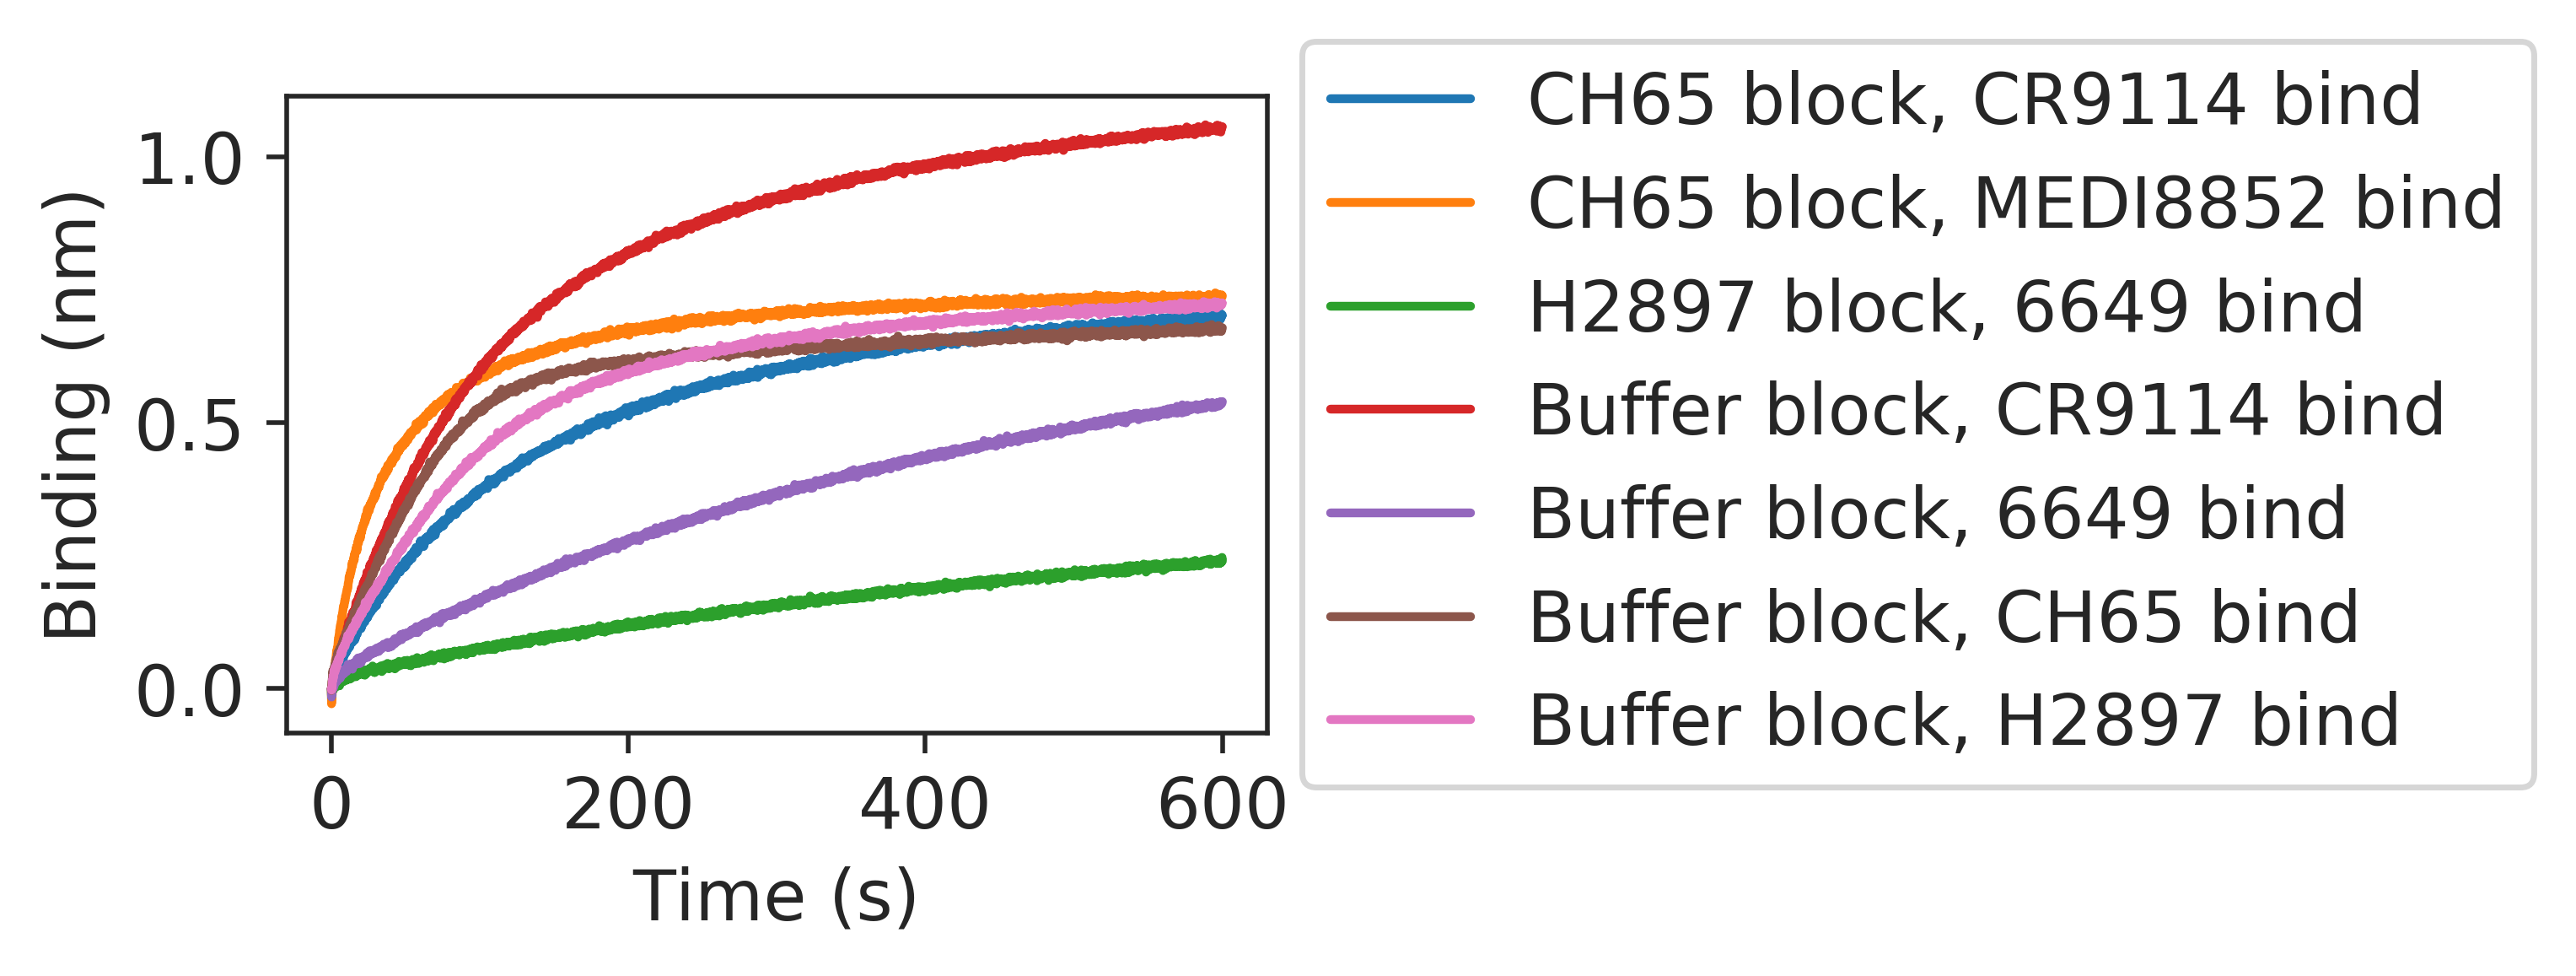

In [16]:
# Cross-competition

selectors = [[(2, "G11", "CH65 block, CR9114 bind"), 
              (4, "A11", "CH65 block, MEDI8852 bind"),
              (2, "H11", "H2897 block, 6649 bind"),
              (3, "G11", "Buffer block, CR9114 bind"),
              (3, "H11", "Buffer block, 6649 bind"),
              (5, "G11", "Buffer block, CH65 bind"),
              (5, "H11", "Buffer block, H2897 bind")]]

for selector in selectors:
    Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    Exp.plot(ax=ax, x="time")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Binding (nm)")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    

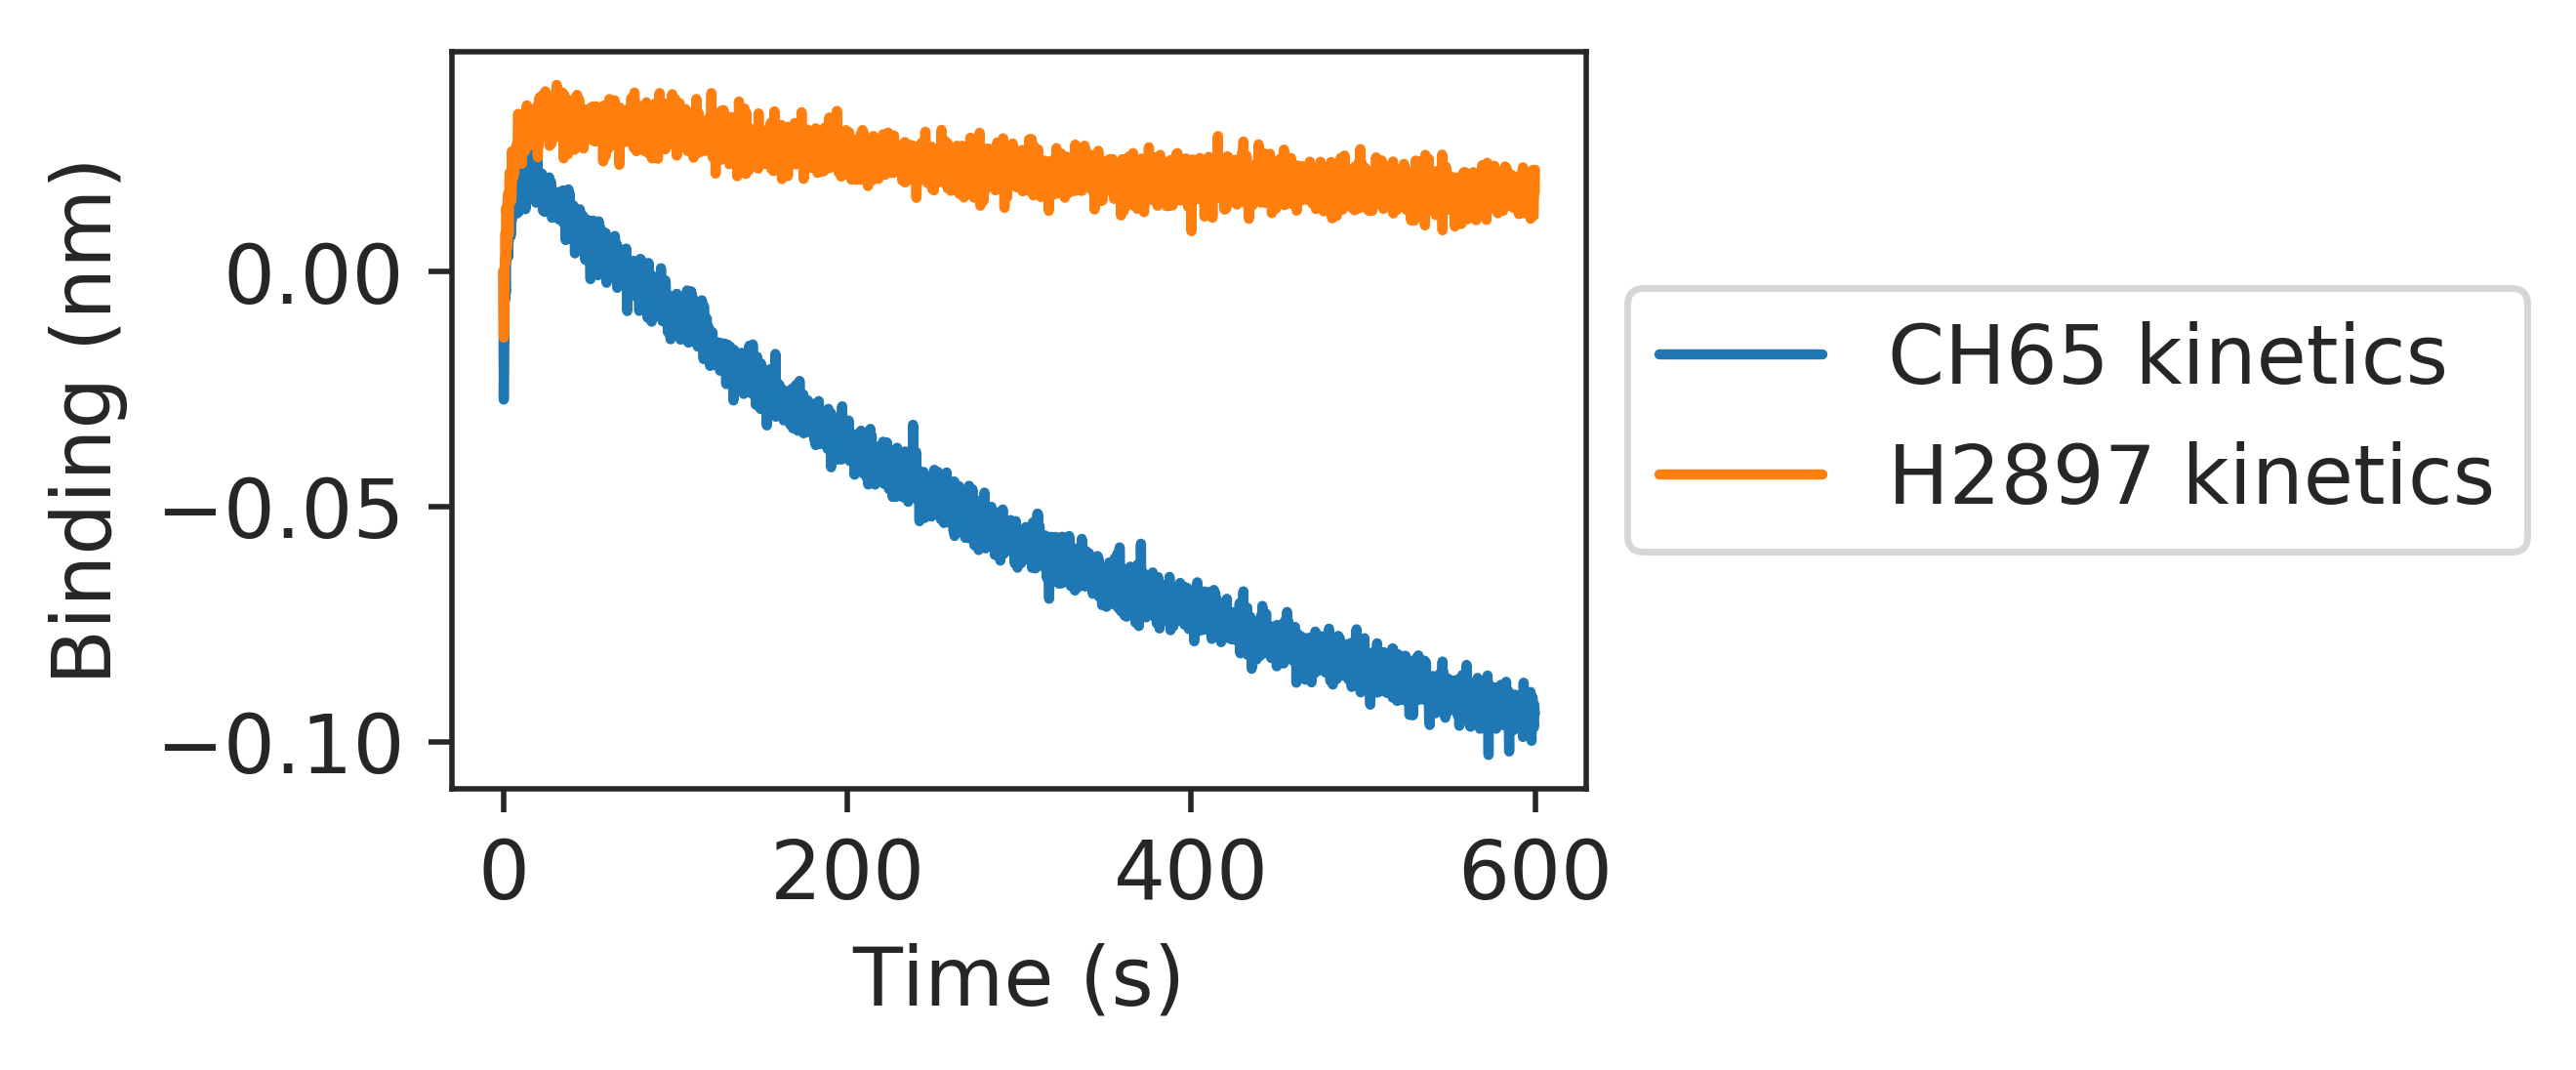

In [17]:
# Off rate

selectors = [[(4, "D11", "CH65 kinetics"), 
              (4, "E11", "H2897 kinetics")]]

for selector in selectors:
    Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    Exp.plot(ax=ax, x="time")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Binding (nm)")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Plot all assays as subplots

Text(0,0.5,'Binding (nm)')

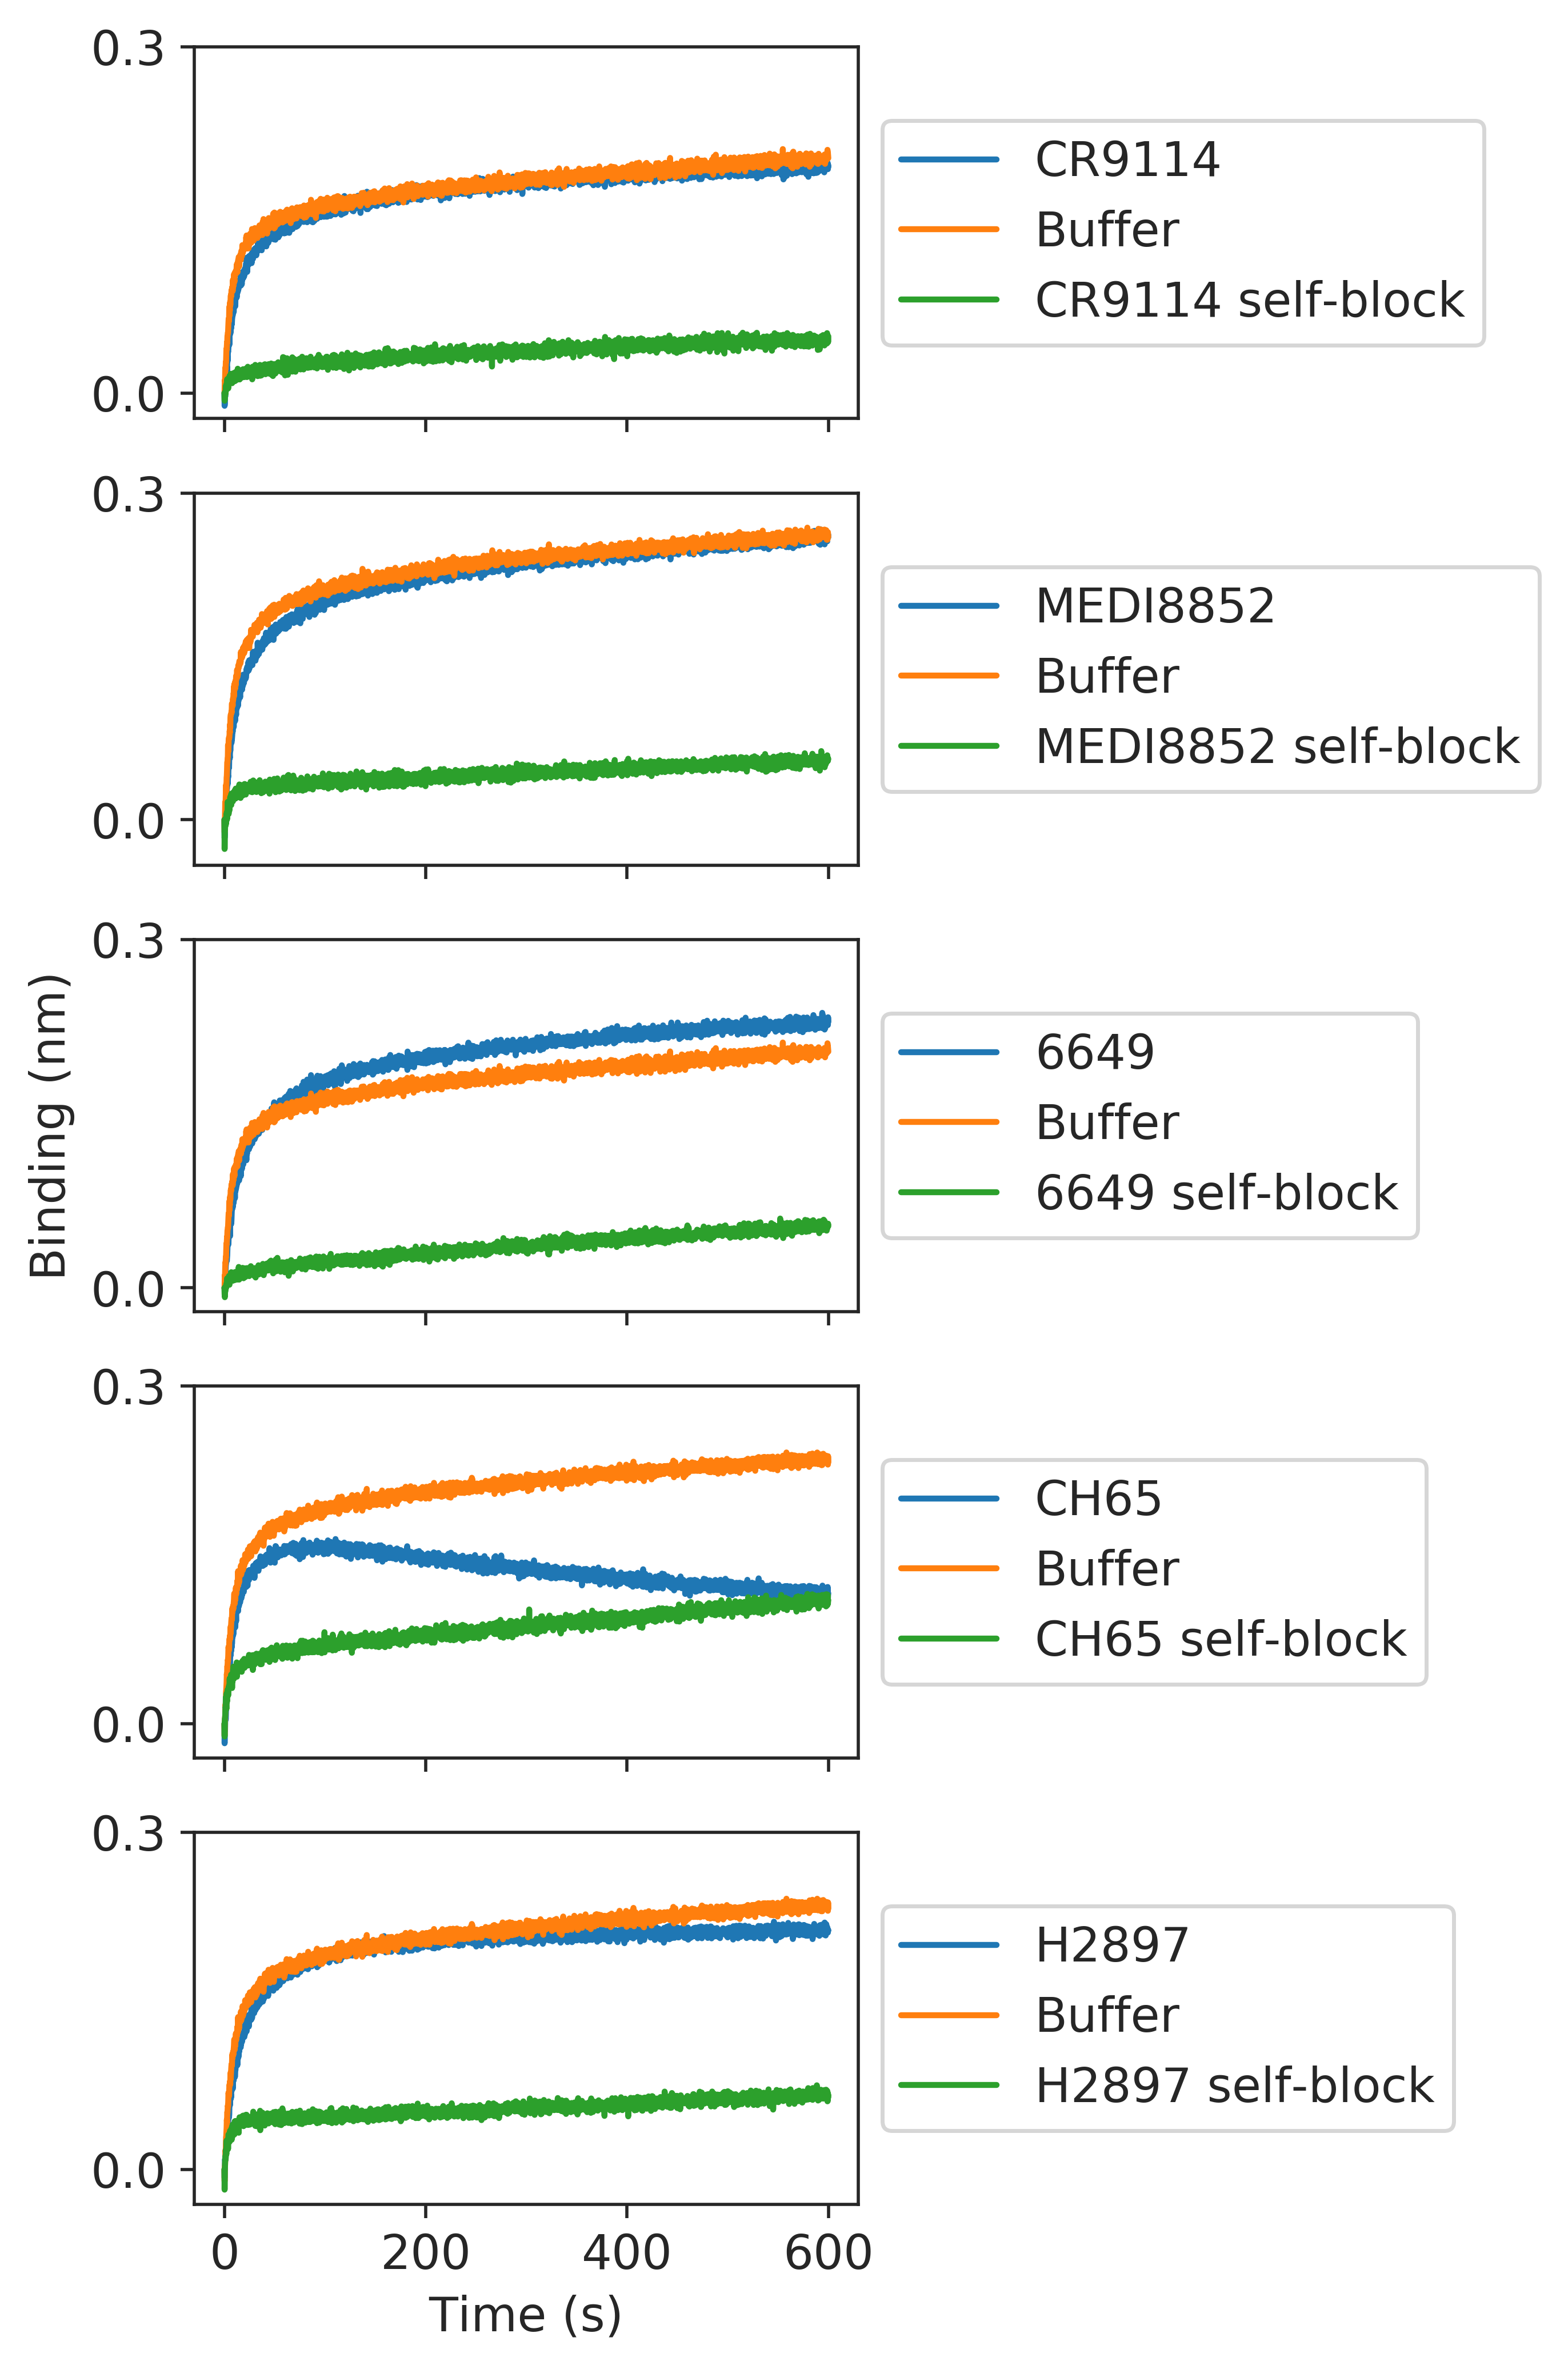

In [18]:
# N1

selectors = [[(1, "A11", "CR9114"), (1, "C11", "Buffer"), (1, "G11", "CR9114 self-block")],
             [(3, "A11", "MEDI8852"), (3, "C11", "Buffer"), (5, "A11", "MEDI8852 self-block")],
             [(1, "B11", "6649"), (1, "C11", "Buffer"), (1, "H11", "6649 self-block")],
             [(2, "A11", "CH65"), (2, "C11", "Buffer"), (4, "G11", "CH65 self-block")],
             [(2, "B11", "H2897"), (2, "C11", "Buffer"), (4, "H11", "H2897 self-block")]]

fig, axes = plt.subplots(len(selectors), 1, figsize=(3,2*len(selectors)), sharex=True)

for ax, selector in zip(axes, selectors):

    Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
    Exp.plot(ax=ax, x="time")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_ylim(top=0.3)
    ax.set_yticks([0, 0.3])
    
axes[-1].set_xlabel("Time (s)")
axes[2].set_ylabel("Binding (nm)")

Text(0,0.5,'Binding (nm)')

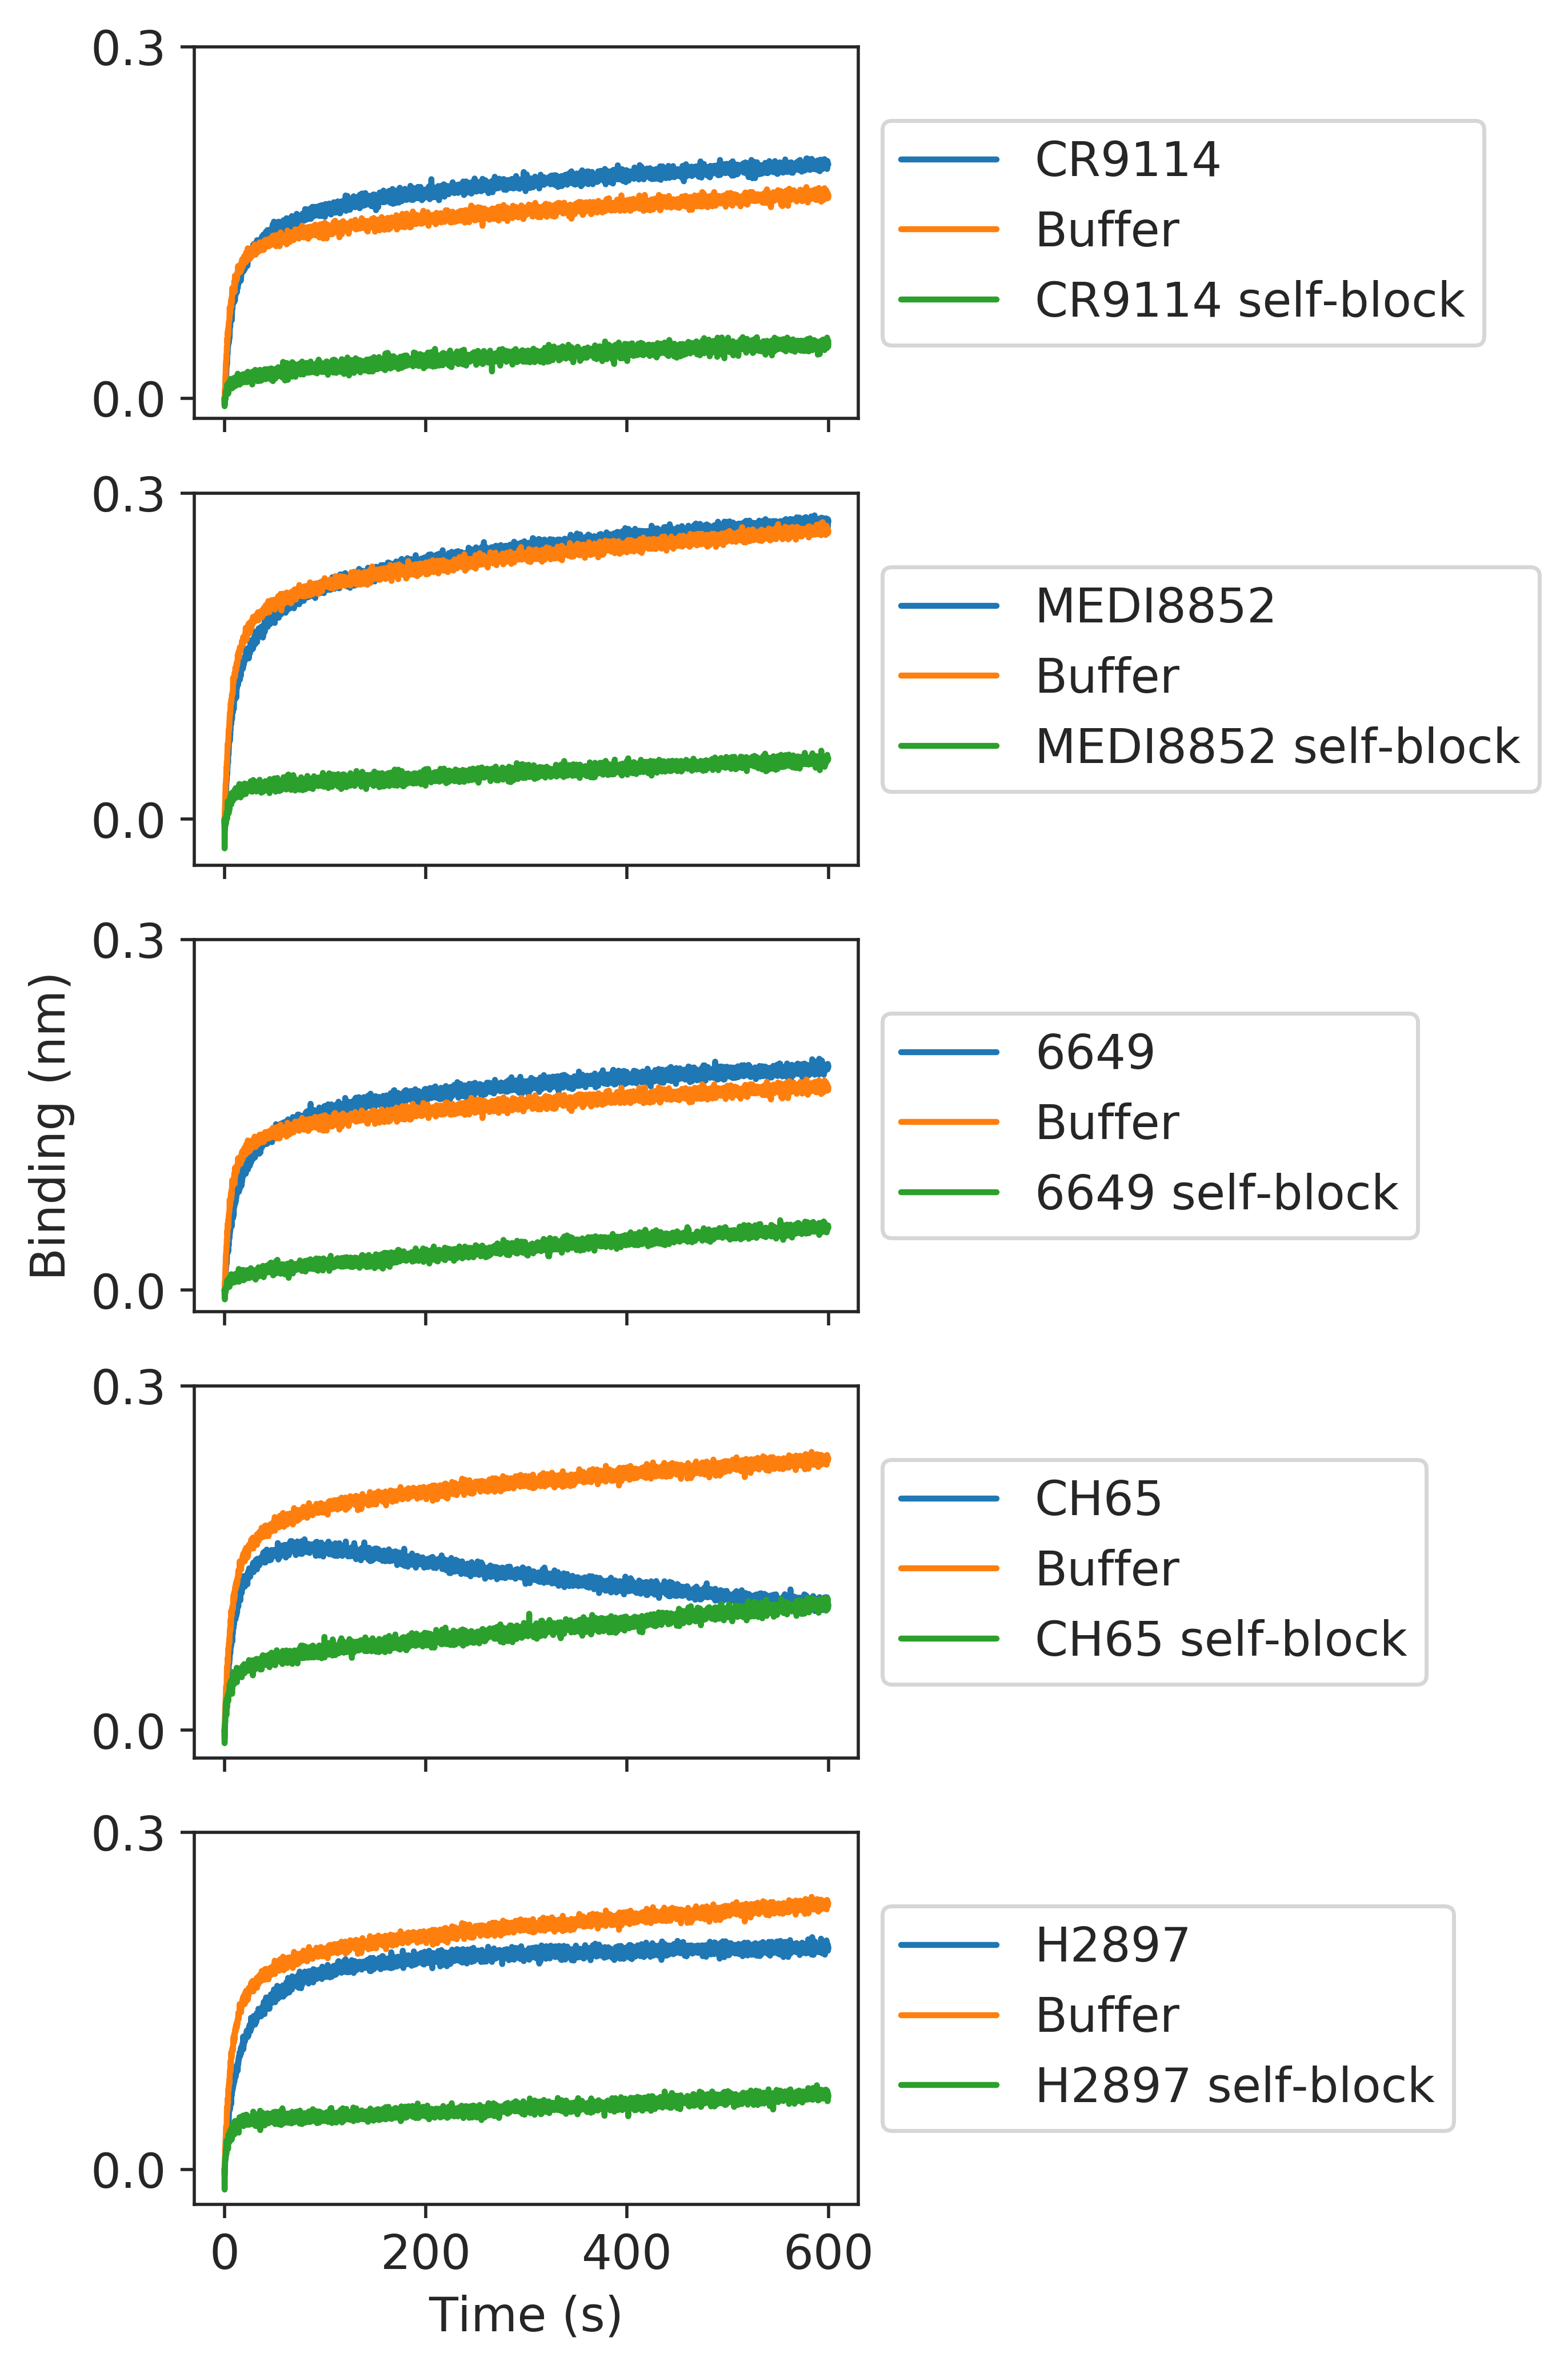

In [19]:
# N6

selectors = [[(1, "D11", "CR9114"), (1, "F11", "Buffer"), (1, "G11", "CR9114 self-block")],
             [(3, "D11", "MEDI8852"), (3, "E11", "Buffer"), (5, "A11", "MEDI8852 self-block")],
             [(1, "E11", "6649"), (1, "F11", "Buffer"), (1, "H11", "6649 self-block")],
             [(2, "D11", "CH65"), (2, "F11", "Buffer"), (4, "G11", "CH65 self-block")],
             [(2, "E11", "H2897"), (2, "F11", "Buffer"), (4, "H11", "H2897 self-block")]]

fig, axes = plt.subplots(len(selectors), 1, figsize=(3,2*len(selectors)), sharex=True)

for ax, selector in zip(axes, selectors):

    Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
    Exp.plot(ax=ax, x="time")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_ylim(top=0.3)
    ax.set_yticks([0, 0.3])
    
axes[-1].set_xlabel("Time (s)")
axes[2].set_ylabel("Binding (nm)")

# Plot example of full assay curve

In [20]:
def idx_start_end(idx_assay):
    
    T_assay_total = 25 * 6 + 150 + 300 + 1800 + 300 + 4500 + 300 + 3000
    T_assay_to_Assoc2 = 25 * 6 + 150 + 300 + 1800 + 300 + 4500 + 300
    
    T_start = T_assay_total * (idx_assay - 1) + T_assay_to_Assoc2 - 1
    T_end = T_start + 3000
    
    return T_start, T_end

def assay_select_baseline(Exp_All_Raw, idx_assay, sensors):
    idx_start, idx_end = idx_start_end(idx_assay) # get start and end points of assay
    columns = ["time"] + sensors
    Exp_Raw = Exp_All_Raw.loc[idx_start:idx_end][columns] # select timepoints and sensors
    Exp = Exp_Raw - Exp_Raw.iloc[0] # subtract initial value
    return Exp

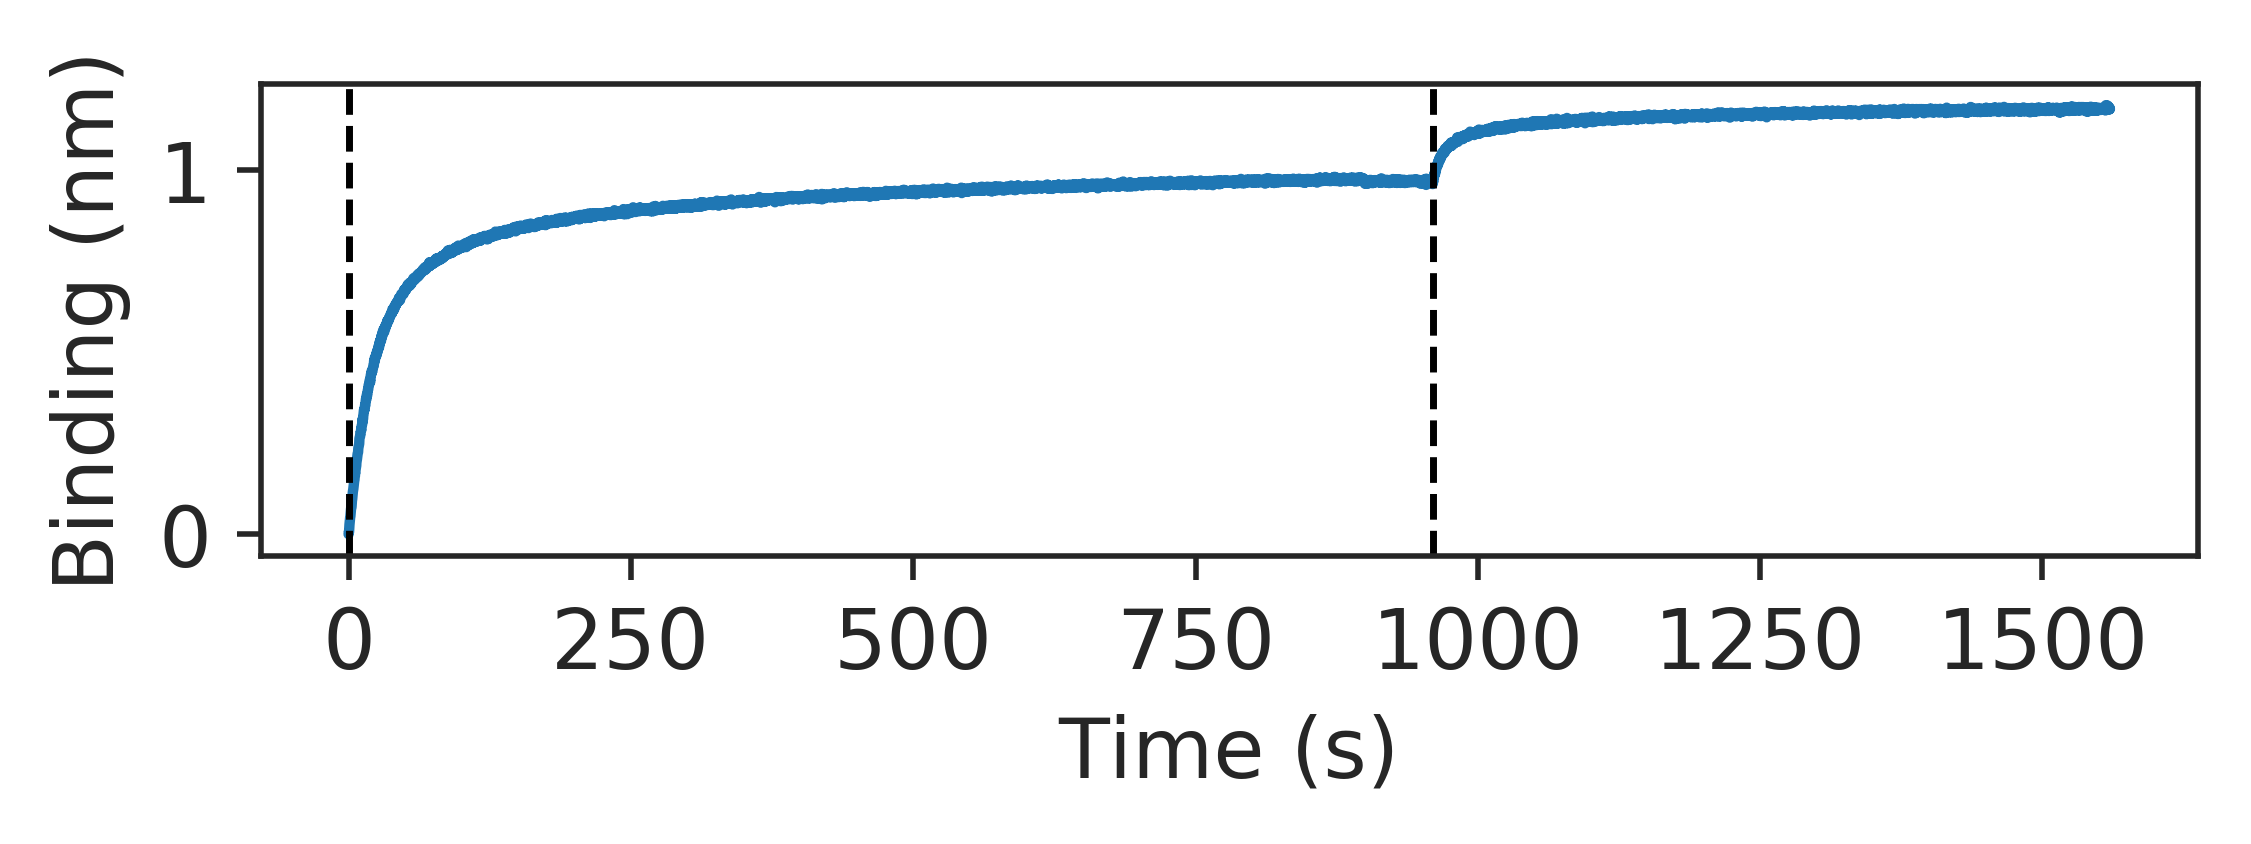

In [21]:
# Visualize data

T_start = 25 * 6 + 150 + 300 + 1800 + 300
T_end = T_start + 4500 + 300 + 3000 - 1
Exp_temp = Exp_All_Raw.loc[T_start:T_end]
Exp_temp = Exp_temp - Exp_temp.iloc[0]

x = Exp_temp["time"]
y = Exp_temp["A11"]

fig, ax = plt.subplots(1, 1, figsize=(5,1.25))
ax.plot(x, y)
ax.set_ylabel("Binding (nm)")
ax.set_xlabel("Time (s)")
ax.axvline(0, color="k", ls="--", lw=1)
ax.axvline(960, color="k", ls="--", lw=1)

# Plot all assays as subplots for Figure

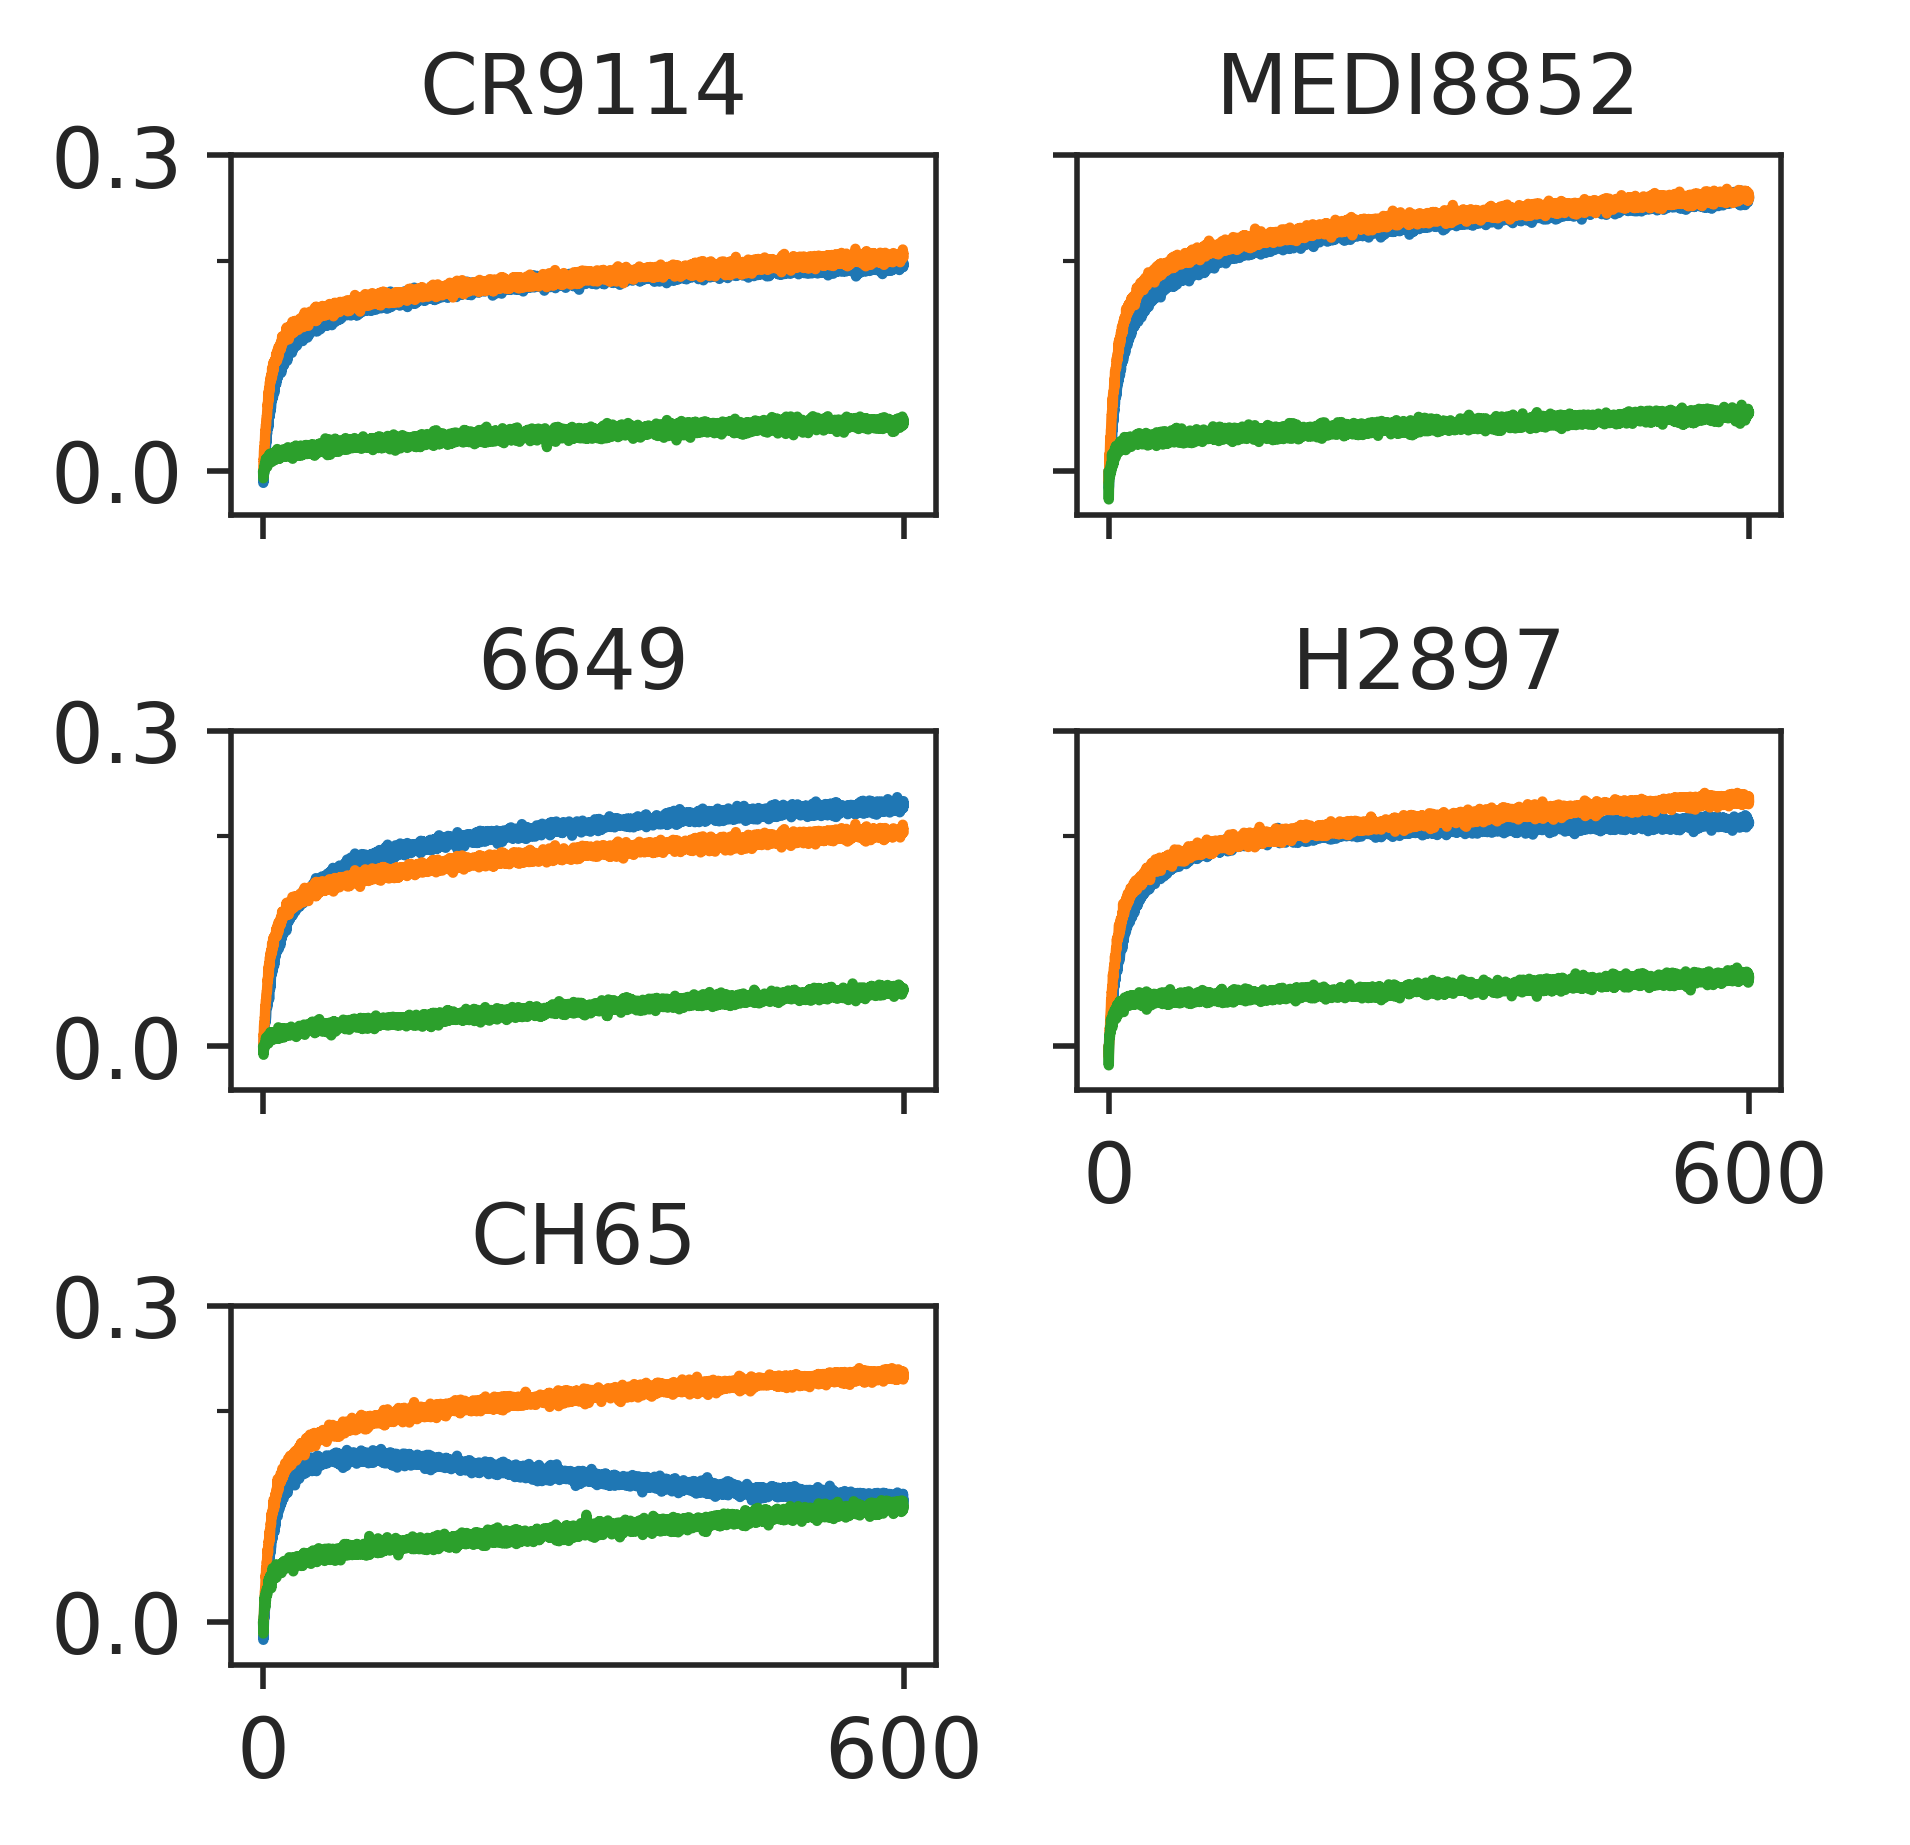

In [22]:
# N1

selectors = [[(1, "A11", "CR9114"), (1, "C11", "Buffer"), (1, "G11", "CR9114 self-block")],
             [(3, "A11", "MEDI8852"), (3, "C11", "Buffer"), (5, "A11", "MEDI8852 self-block")],
             [(1, "B11", "6649"), (1, "C11", "Buffer"), (1, "H11", "6649 self-block")],
             [(2, "A11", "CH65"), (2, "C11", "Buffer"), (4, "G11", "CH65 self-block")],
             [(2, "B11", "H2897"), (2, "C11", "Buffer"), (4, "H11", "H2897 self-block")]]

fig, axes = plt.subplots(3, 2, figsize=(4,4), sharex=False, sharey=True)

ax = axes[0,0]
selector = selectors[0]
Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
Exp.plot(ax=ax, x="time", legend=None)
ax.set_title("CR9114")

ax = axes[0,1]
selector = selectors[1]
Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
Exp.plot(ax=ax, x="time", legend=None)
ax.set_title("MEDI8852")

ax = axes[1,0]
selector = selectors[2]
Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
Exp.plot(ax=ax, x="time", legend=None)
ax.set_title("6649")

ax = axes[1,1]
selector = selectors[4]
Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
Exp.plot(ax=ax, x="time", legend=None)
ax.set_title("H2897")

ax = axes[2,0]
selector = selectors[3]
Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
Exp.plot(ax=ax, x="time", legend=None)
ax.set_title("CH65")

axes[2,1].axis('off') # hide last subplot

for ax_row in axes:
    for ax in ax_row:
        if ax is not None:
            ax.set_xticks([0,600])
            ax.set_ylim(top=0.3)
            ax.set_yticks([0, 0.3])
            # ax.get_legend().remove()
            ax.set_xlabel("")

axes[0,0].set_xticklabels([])
axes[0,1].set_xticklabels([])
axes[1,0].set_xticklabels([])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)

save_figure(fig, "Competition_N1")


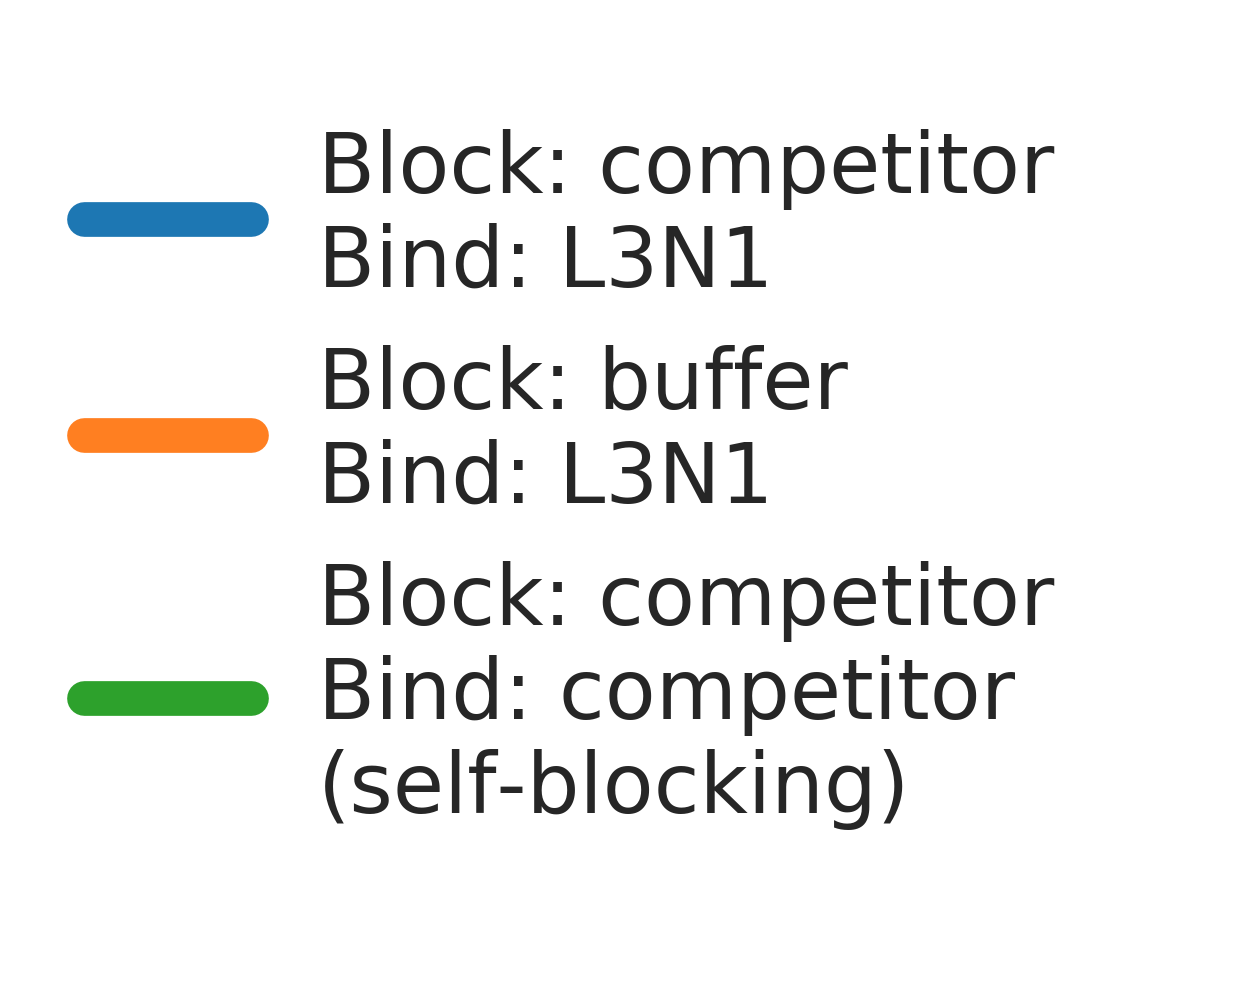

In [23]:
# Legend for N1

labels = ["Block: competitor\nBind: L3N1", "Block: buffer\nBind: L3N1", "Block: competitor\nBind: competitor\n(self-blocking)"]
colors = ["#1D77B3", "#FF7F21", "#2DA12C"]

fig, ax = plt.subplots(1, 1, figsize=(2,2))

for color, label in zip(colors, labels):
    ax.plot(0, 0, color=color, label=label, lw=5)

ax.set_axis_off() 
ax.legend(frameon=False)

save_figure(fig, "Competition_N1_legend", savefig_args={"bbox_inches": "tight", "pad_inches": 0})

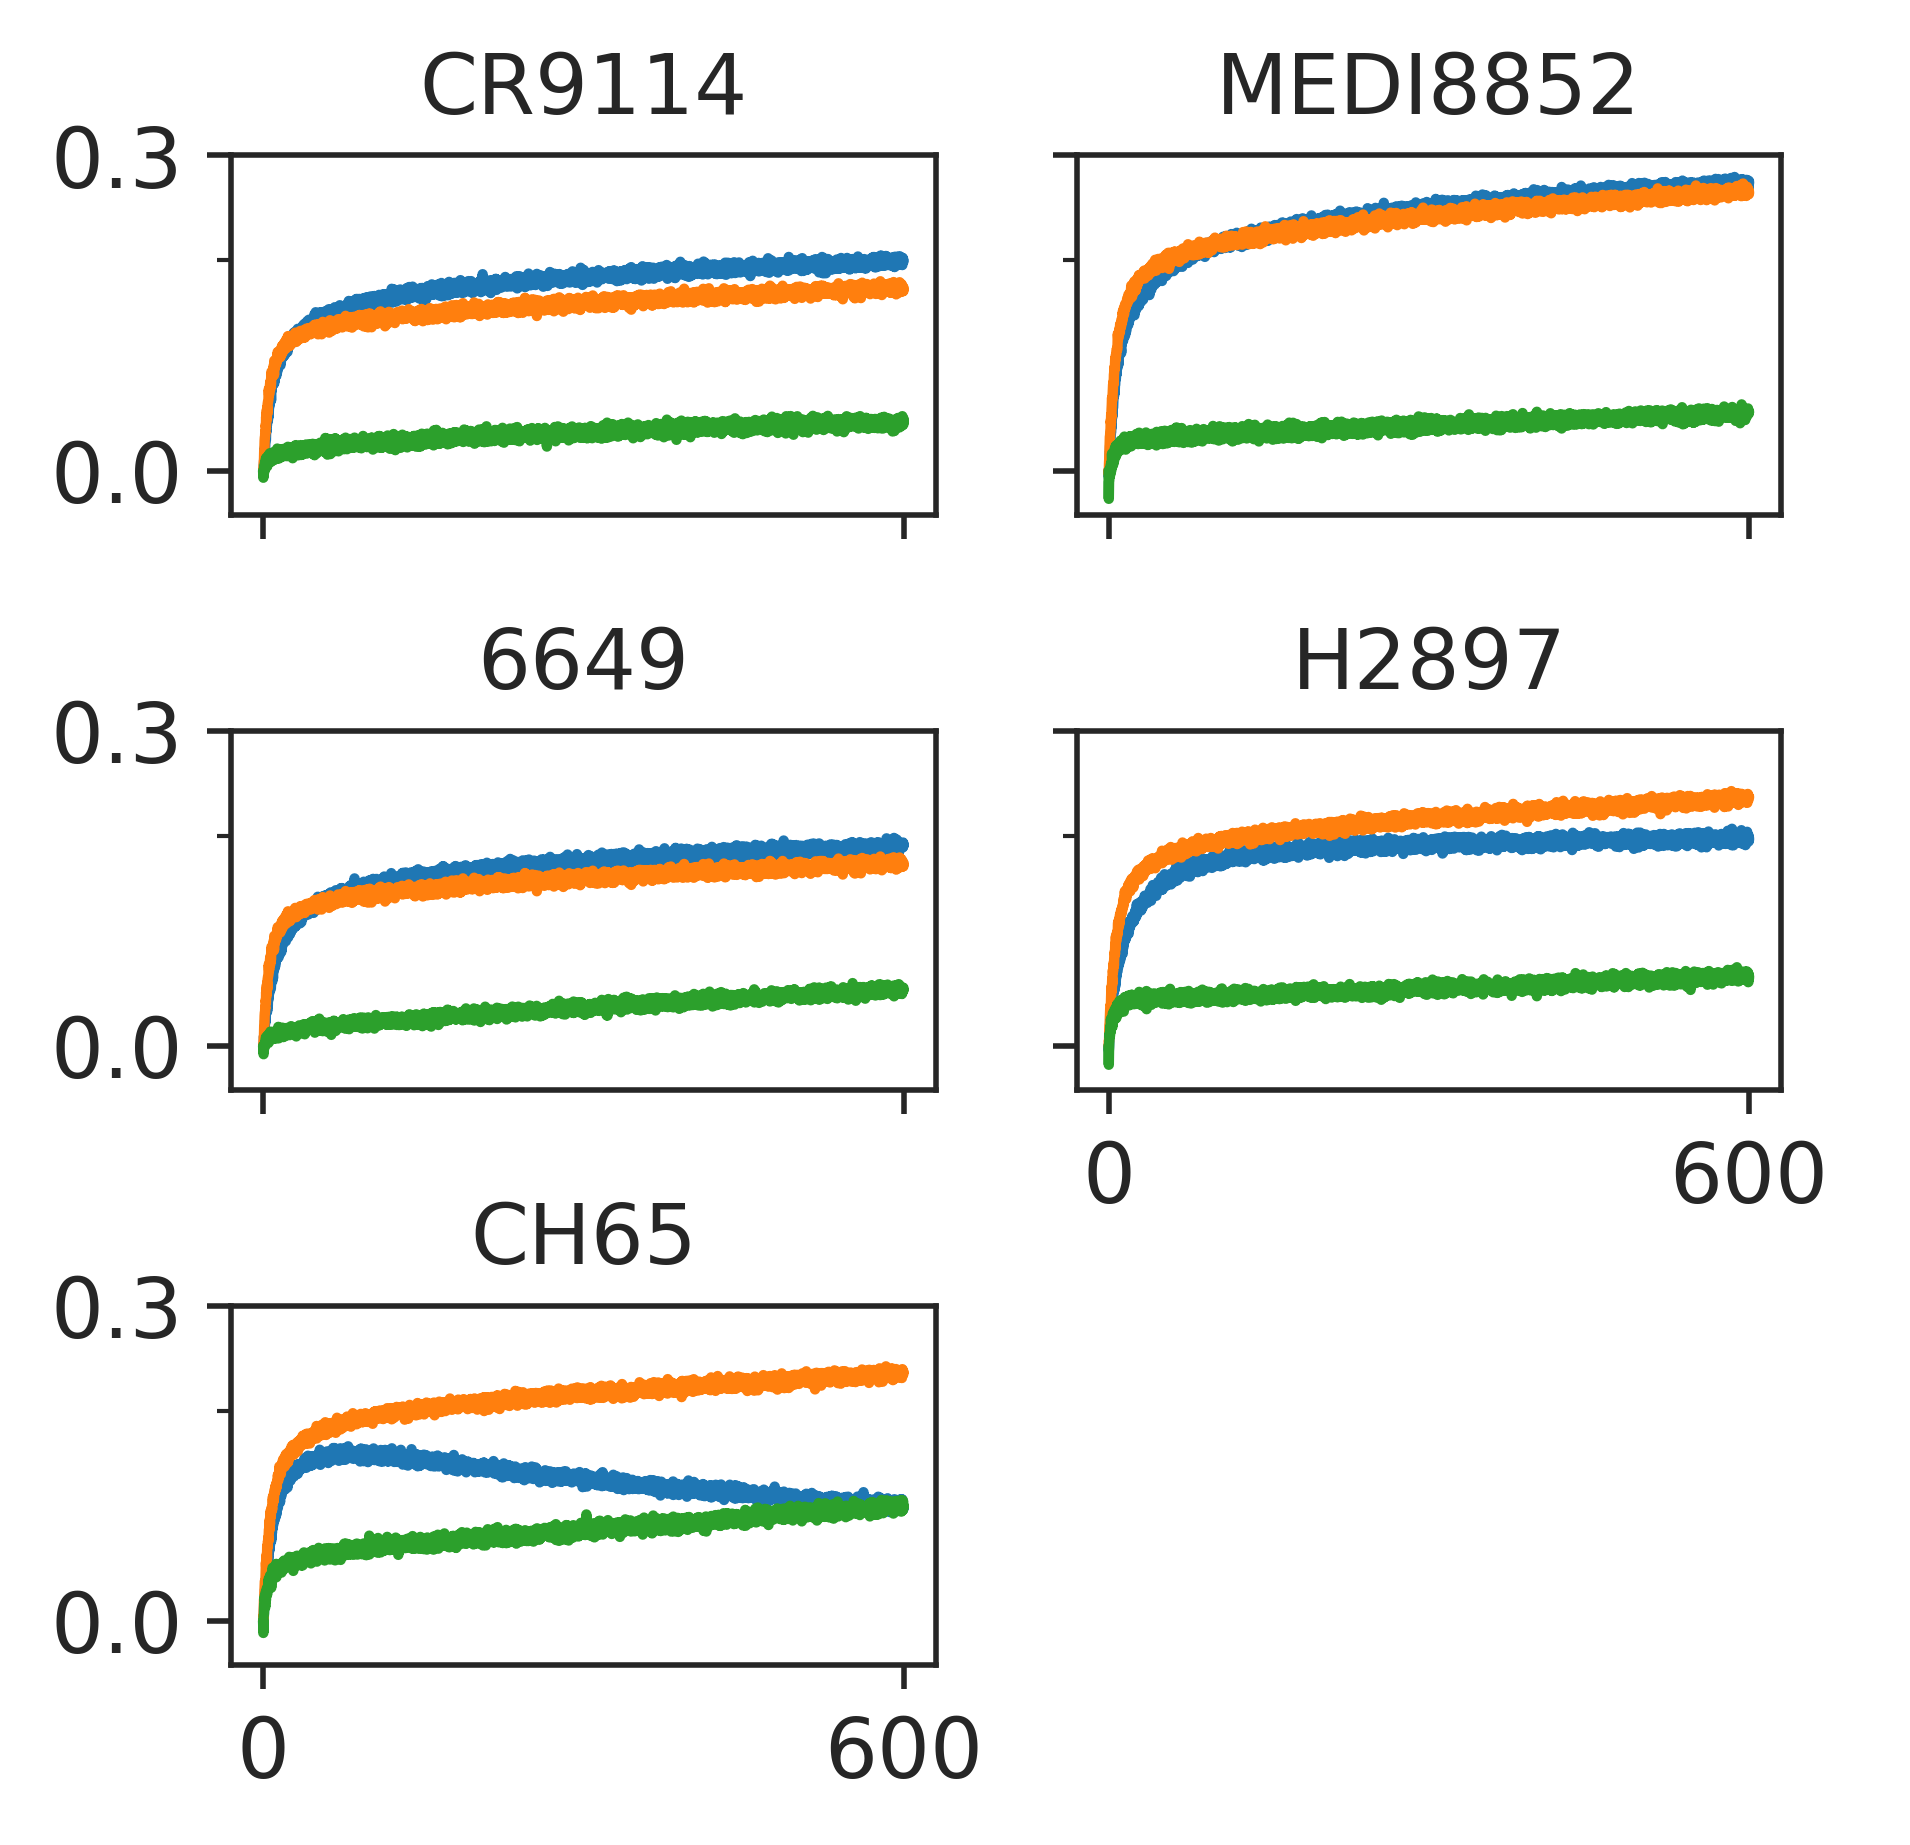

In [24]:
# N6

selectors = [[(1, "D11", "CR9114"), (1, "F11", "Buffer"), (1, "G11", "CR9114 self-block")],
             [(3, "D11", "MEDI8852"), (3, "E11", "Buffer"), (5, "A11", "MEDI8852 self-block")],
             [(1, "E11", "6649"), (1, "F11", "Buffer"), (1, "H11", "6649 self-block")],
             [(2, "D11", "CH65"), (2, "F11", "Buffer"), (4, "G11", "CH65 self-block")],
             [(2, "E11", "H2897"), (2, "F11", "Buffer"), (4, "H11", "H2897 self-block")]]

fig, axes = plt.subplots(3, 2, figsize=(4,4), sharex=False, sharey=True)

ax = axes[0,0]
selector = selectors[0]
Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
Exp.plot(ax=ax, x="time", legend=None)
ax.set_title("CR9114")

ax = axes[0,1]
selector = selectors[1]
Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
Exp.plot(ax=ax, x="time", legend=None)
ax.set_title("MEDI8852")

ax = axes[1,0]
selector = selectors[2]
Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
Exp.plot(ax=ax, x="time", legend=None)
ax.set_title("6649")

ax = axes[1,1]
selector = selectors[4]
Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
Exp.plot(ax=ax, x="time", legend=None)
ax.set_title("H2897")

ax = axes[2,0]
selector = selectors[3]
Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
Exp.plot(ax=ax, x="time", legend=None)
ax.set_title("CH65")

axes[2,1].axis('off') # hide last subplot

for ax_row in axes:
    for ax in ax_row:
        if ax is not None:
            ax.set_xticks([0,600])
            ax.set_ylim(top=0.3)
            ax.set_yticks([0, 0.3])
            # ax.get_legend().remove()
            ax.set_xlabel("")

axes[0,0].set_xticklabels([])
axes[0,1].set_xticklabels([])
axes[1,0].set_xticklabels([])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)

save_figure(fig, "Competition_N6")


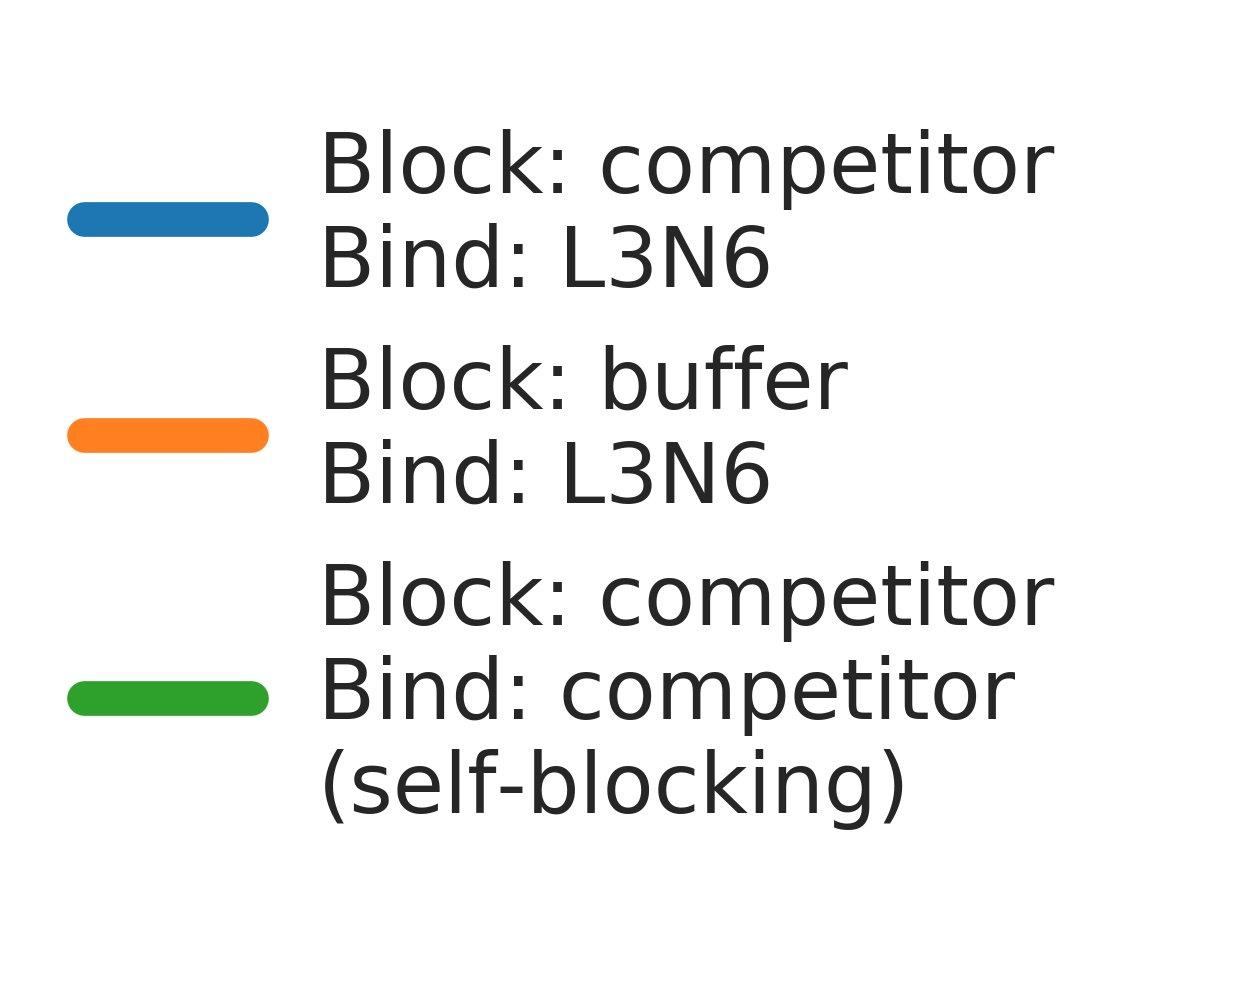

In [25]:
# Legend for N6

labels = ["Block: competitor\nBind: L3N6", "Block: buffer\nBind: L3N6", "Block: competitor\nBind: competitor\n(self-blocking)"]
colors = ["#1D77B3", "#FF7F21", "#2DA12C"]

fig, ax = plt.subplots(1, 1, figsize=(2,2))

for color, label in zip(colors, labels):
    ax.plot(0, 0, color=color, label=label, lw=5)

ax.set_axis_off() 
ax.legend(frameon=False)

save_figure(fig, "Competition_N6_legend", savefig_args={"bbox_inches": "tight", "pad_inches": 0})

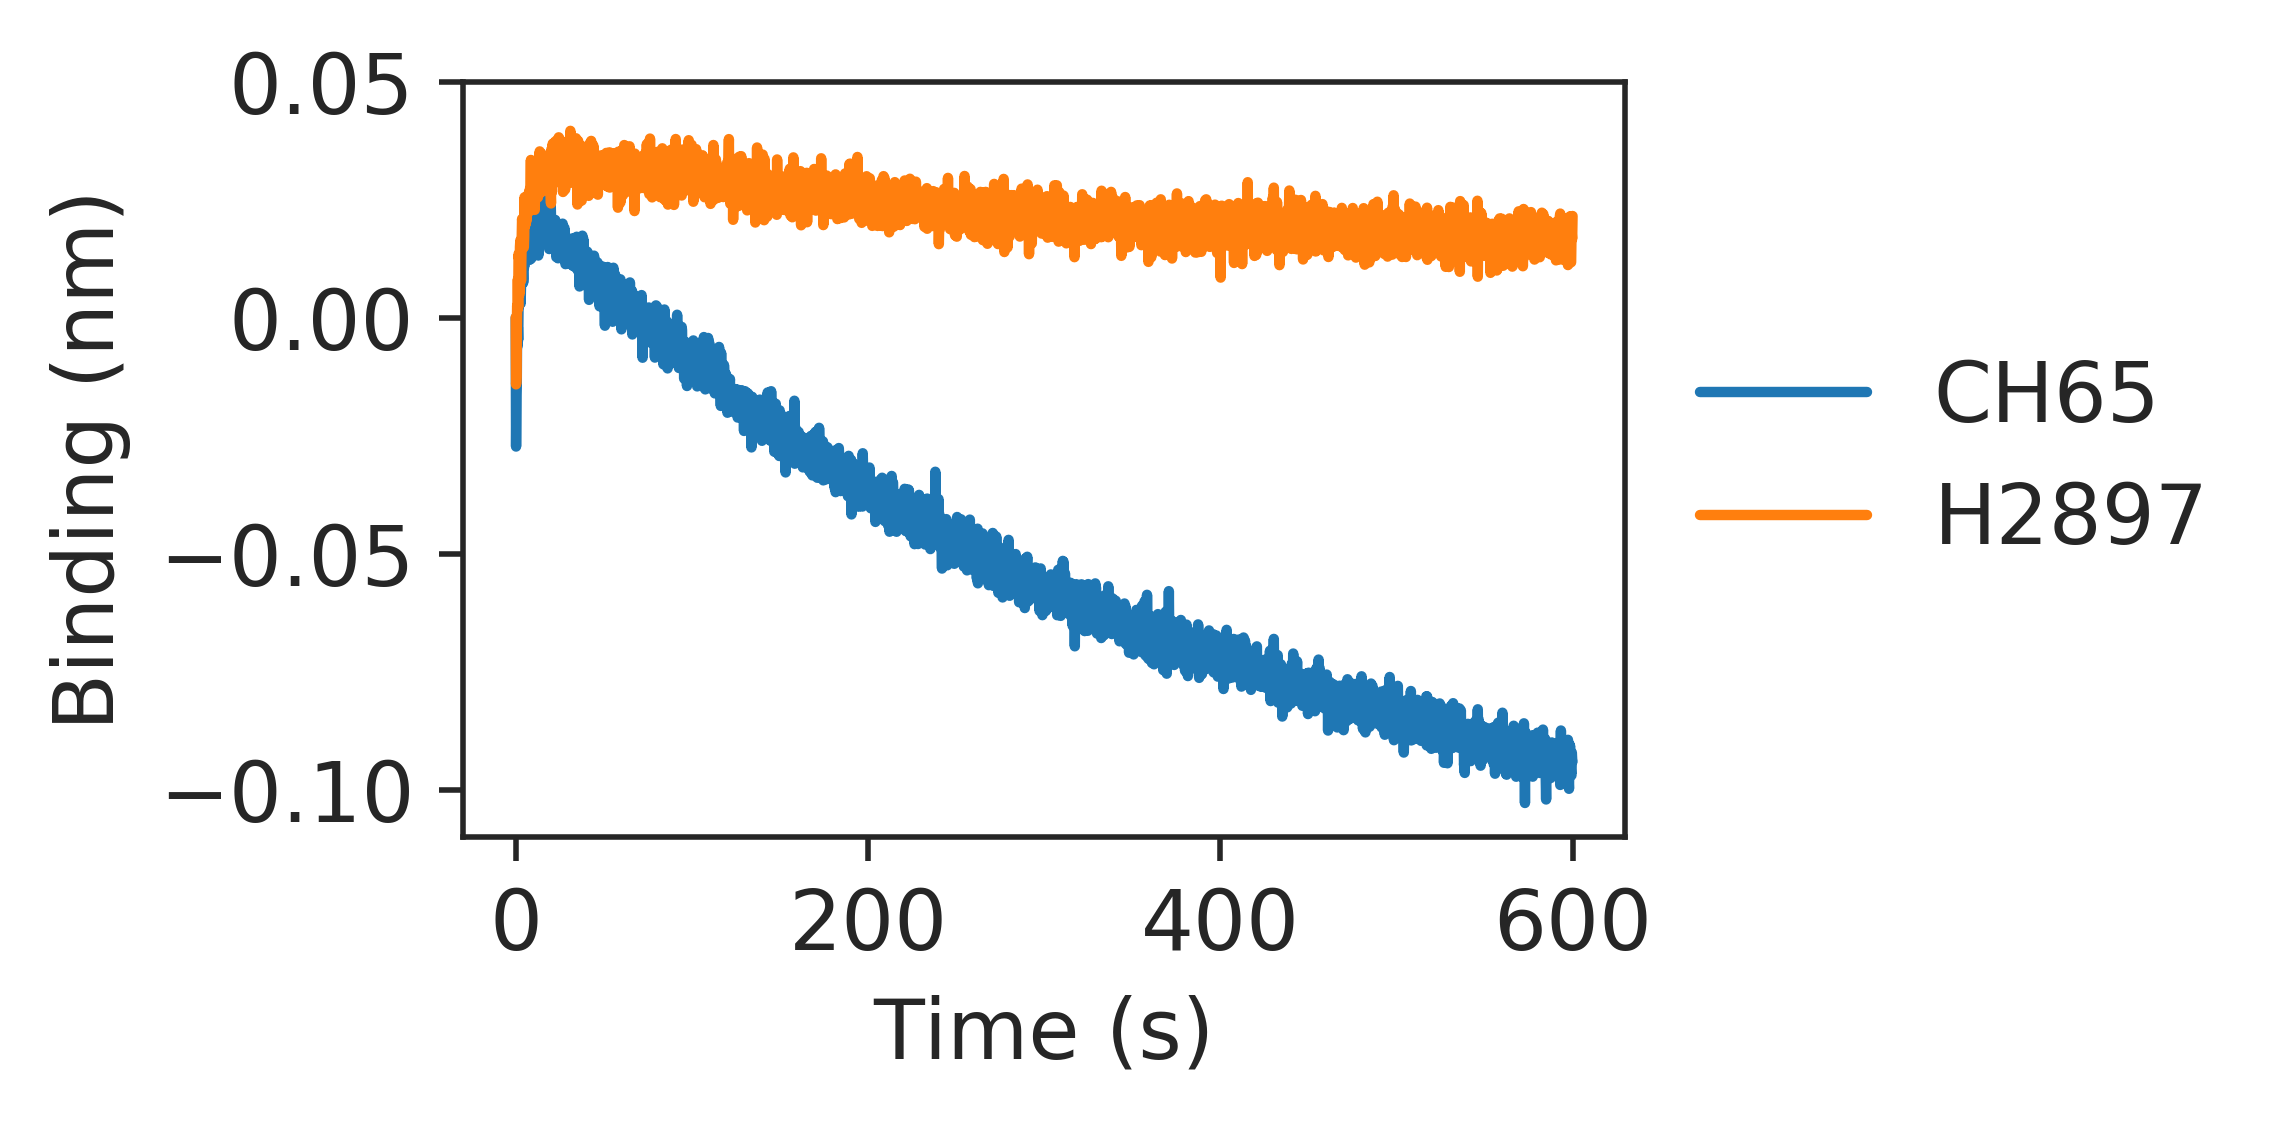

In [26]:
# Off rate

selectors = [[(4, "D11", "CH65"), 
              (4, "E11", "H2897")]]

for selector in selectors:
    Exp = assay_select_specific_baseline(Exp_All_Raw, selector)
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    Exp.plot(ax=ax, x="time")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Binding (nm)")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
    ax.set_ylim(top=0.05)
    
save_figure(fig, "Competition_offrate_CH65_H2897")

# Summarize competition binding as a table

In [27]:
##### Create table
columns = ["CR9114", "MEDI8852", "6649", "CH65", "H2897"]
index = ["N1, cross-block", "N1, self-block", "N6, cross-block", "N6, self-block"]
table_summary = pd.DataFrame(columns=columns, index=index)

##### Populate with values

# Choose timepoint for calculating binding ratio
time_index = 125 * 2 # 125th data point corresponds to 25 sec

### Get data from kinetics curves, calculate ratio

# N1

antibody_name = "N1"

selectors = [[(1, "A11", "CR9114"), (1, "C11", "Buffer"), (1, "G11", "CR9114 self-block")],
             [(3, "A11", "MEDI8852"), (3, "C11", "Buffer"), (5, "A11", "MEDI8852 self-block")],
             [(1, "B11", "6649"), (1, "C11", "Buffer"), (1, "H11", "6649 self-block")],
             [(2, "A11", "CH65"), (2, "C11", "Buffer"), (4, "G11", "CH65 self-block")],
             [(2, "B11", "H2897"), (2, "C11", "Buffer"), (4, "H11", "H2897 self-block")]]

for selector in selectors:
    
    col_name = selector[0][2] # name of competitor antibody
    x = assay_select_specific_baseline(Exp_All_Raw, selector).loc[time_index] # get data

    val = x[selector[0][2]] / x[selector[1][2]] # cross-block over buffer
    row_name = antibody_name + ", cross-block"
    table_summary[col_name].loc[row_name] = val

    val = x[selector[2][2]] / x[selector[1][2]] # self-block over buffer
    row_name = antibody_name + ", self-block"
    table_summary[col_name].loc[row_name] = val

# N6

antibody_name = "N6"

selectors = [[(1, "D11", "CR9114"), (1, "F11", "Buffer"), (1, "G11", "CR9114 self-block")],
             [(3, "D11", "MEDI8852"), (3, "E11", "Buffer"), (5, "A11", "MEDI8852 self-block")],
             [(1, "E11", "6649"), (1, "F11", "Buffer"), (1, "H11", "6649 self-block")],
             [(2, "D11", "CH65"), (2, "F11", "Buffer"), (4, "G11", "CH65 self-block")],
             [(2, "E11", "H2897"), (2, "F11", "Buffer"), (4, "H11", "H2897 self-block")]]

for selector in selectors:
    
    col_name = selector[0][2] # name of competitor antibody
    x = assay_select_specific_baseline(Exp_All_Raw, selector).loc[time_index] # get data

    val = x[selector[0][2]] / x[selector[1][2]] # cross-block over buffer
    row_name = antibody_name + ", cross-block"
    table_summary[col_name].loc[row_name] = val

    val = x[selector[2][2]] / x[selector[1][2]] # self-block over buffer
    row_name = antibody_name + ", self-block"
    table_summary[col_name].loc[row_name] = val
    
# Clean up nan (required for seaborn heatmap)
table_summary.fillna(value=np.nan, inplace=True)

table_summary

CR9114  MEDI8852      6649      CH65     H2897
N1, cross-block  0.897913  0.885078  0.993241  0.812178  0.941999
N1, self-block   0.162286  0.185806  0.109206  0.363488  0.281199
N6, cross-block  1.051843  0.906170  1.006459  0.825878  0.800735
N6, self-block   0.185804  0.180009  0.125032  0.344604  0.266590

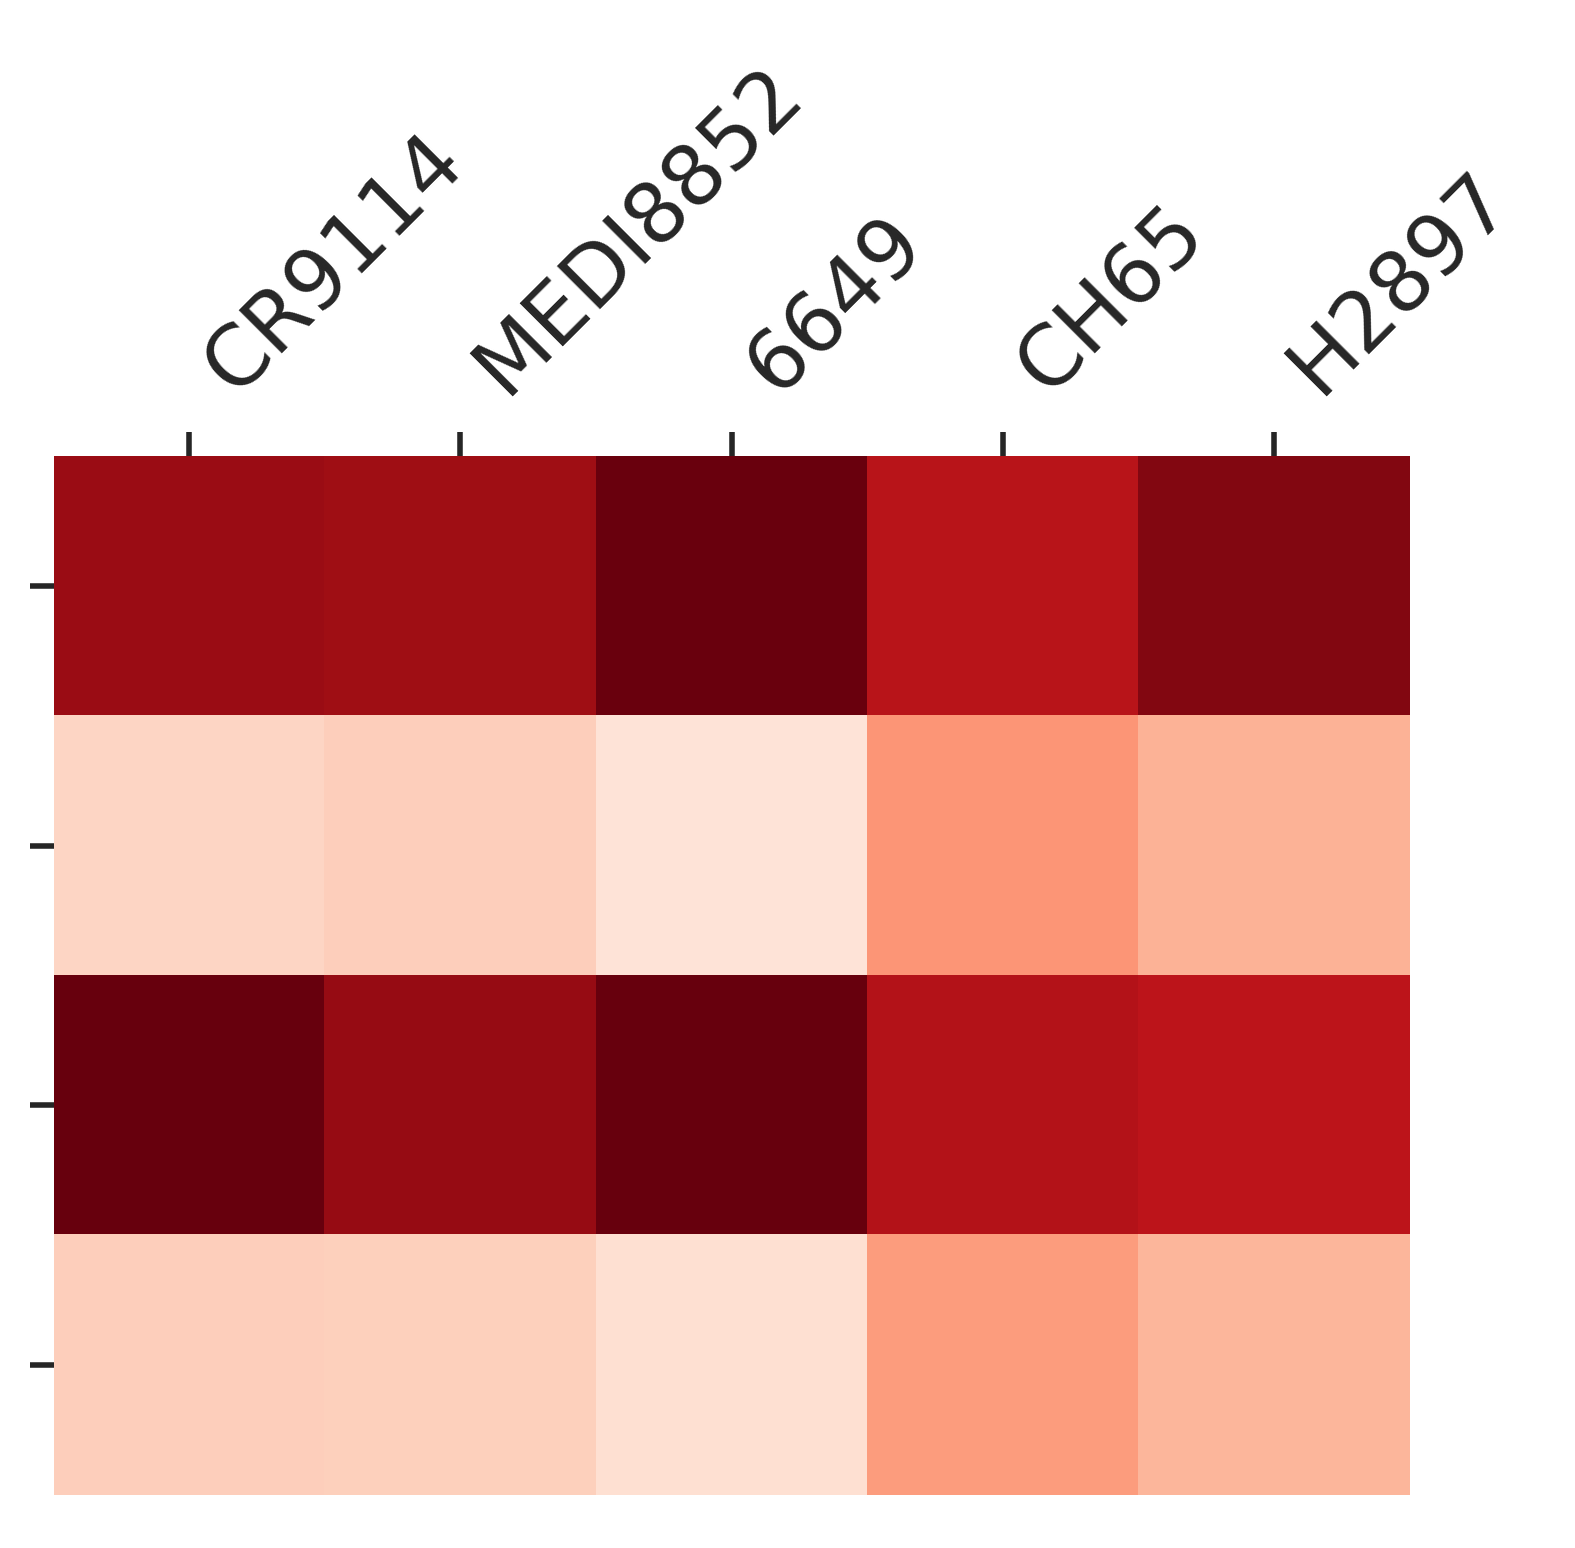

In [28]:
# Plot

dfx = table_summary

heatmap_args = {"vmin": 0, "vmax": 1, "cmap": "Reds", "cbar": None}

fig, ax = plt.subplots(1, 1, figsize=(3.5,2.75))

g = sns.heatmap(dfx, ax=ax, **heatmap_args)

ax.xaxis.tick_top()
ax.set_xticks(np.array(range(dfx.shape[1])) + 0.5)
xticklabels = ["CR9114", "MEDI8852", "6649", "CH65", "H2897"]
ax.set_xticklabels(xticklabels, rotation=45, ha="left")

ax.set_yticklabels([])

save_figure(fig, "Competition_heatmap")

CR9114  MEDI8852  6649  CH65  H2897
N1, cross-block      89        88    99    81     94
N1, self-block       16        18    10    36     28

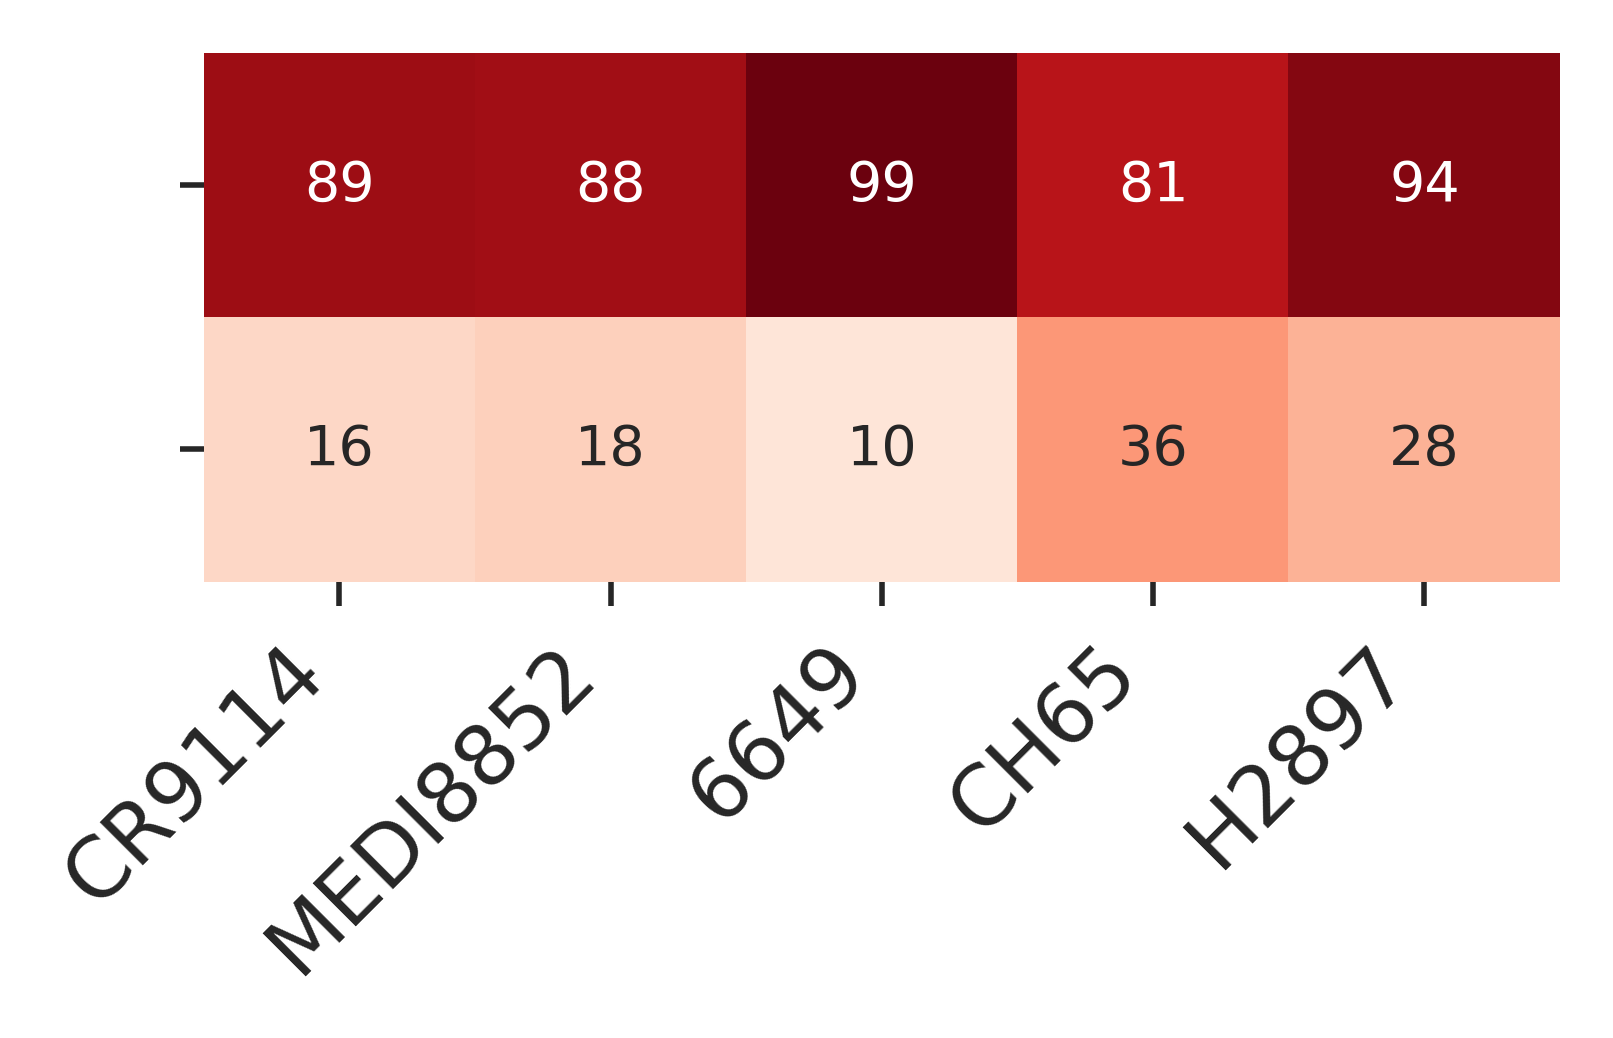

In [29]:
# Plot halves separately

# Top half

dfx = table_summary.iloc[0:2,] * 100
dfx = dfx.astype(np.int16)

heatmap_args = {"vmin": 0, "vmax": 100, "cmap": "Reds", "cbar": None, "annot": True, "annot_kws": {"size": 8}, "fmt": "d"}

fig, ax = plt.subplots(1, 1, figsize=(3.5,1.4))

g = sns.heatmap(dfx, ax=ax, **heatmap_args)

ax.xaxis.tick_bottom()
ax.set_xticks(np.array(range(dfx.shape[1])) + 0.5)
xticklabels = ["CR9114", "MEDI8852", "6649", "CH65", "H2897"]
ax.set_xticklabels(xticklabels, rotation=45, ha="right")

ax.set_yticklabels([])

save_figure(fig, "Competition_heatmap_part1")

dfx

CR9114  MEDI8852  6649  CH65  H2897
N6, cross-block     105        90   100    82     80
N6, self-block       18        18    12    34     26

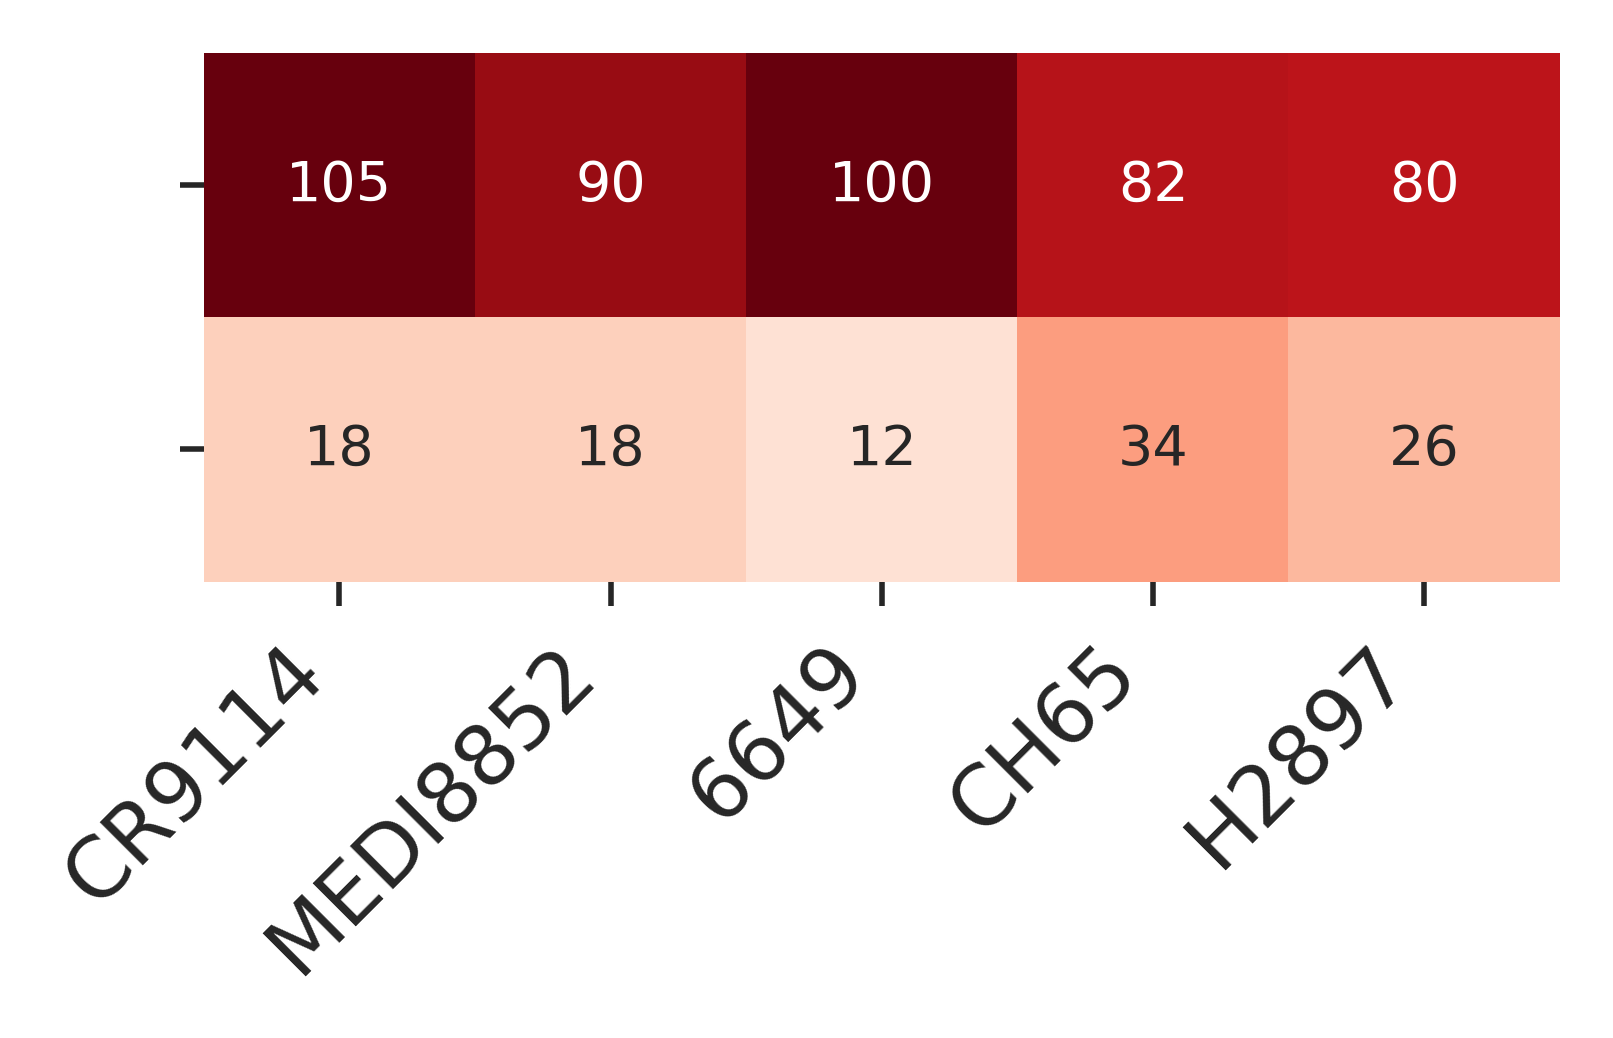

In [30]:
# Bottom half

dfx = table_summary.iloc[2:4,] * 100
dfx = dfx.astype(np.int16)

heatmap_args = {"vmin": 0, "vmax": 100, "cmap": "Reds", "cbar": None, "annot": True, "annot_kws": {"size": 8}, "fmt": "d"}

fig, ax = plt.subplots(1, 1, figsize=(3.5,1.4))

g = sns.heatmap(dfx, ax=ax, **heatmap_args)

ax.xaxis.tick_bottom()
ax.set_xticks(np.array(range(dfx.shape[1])) + 0.5)
xticklabels = ["CR9114", "MEDI8852", "6649", "CH65", "H2897"]
ax.set_xticklabels(xticklabels, rotation=45, ha="right")

ax.set_yticklabels([])

save_figure(fig, "Competition_heatmap_part2")

dfx

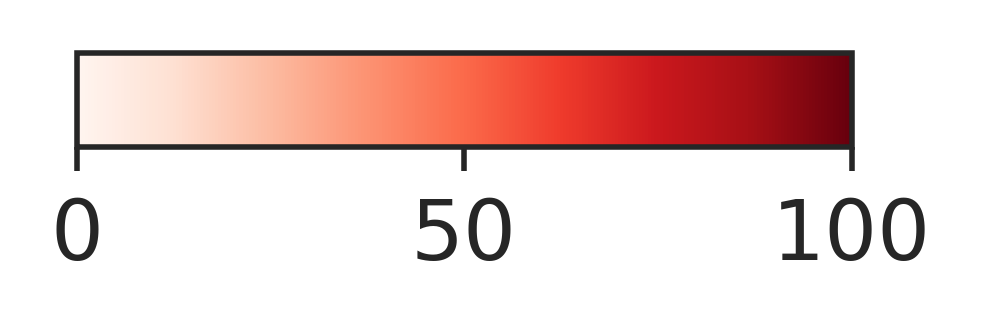

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(2,0.25))
norm = mpl.colors.Normalize(vmin=0, vmax=100)
cb = mpl.colorbar.ColorbarBase(ax, cmap="Reds", norm=norm, orientation="horizontal", ticks=[0, 50, 100])
# cb.set_label("Binding (OD 405 nm)")
save_figure(fig, "Competition_heatmap_cbar")